In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde, chi2
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

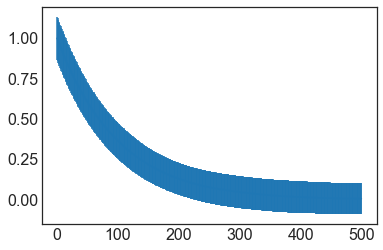

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

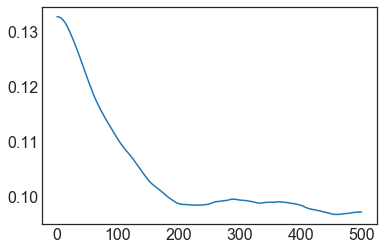

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [8]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[0,0],
                            out.values['amplitude'],
                            out.covar[1,1],
                            out.covar[0,1],
                              out.chisqr])
        print(out.fit_report(min_correl=0.25))
        
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = None
        print('fit did not work weights')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            out2.covar[0,0],
                            out2.values['amplitude'],
                            out2.covar[1,1],
                            out2.covar[0,1],
                            out2.chisqr])
        print(out2.fit_report(min_correl=0.25))
    
    if (fit_results is None) or (fit_std_results is None):
        continue
        
    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.37953197
    reduced chi-square = 7.6211e-04
    Akaike info crit   = -3587.71227
    Bayesian info crit = -3579.28305
[[Variables]]
    decay:      99.3941865 +/- 0.96000784 (0.97%) (init = 100)
    amplitude:  0.80861570 +/- 0.00548762 (0.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 36.8918773
    reduced chi-square = 0.07408007
    Akaike info crit   = -1299.30835
    Bayesian info crit = -1290.87913
[[Variables]]
    decay:      101.268683 +/- 1.05611196 (1.04%) (init = 100)
    amplitude:  0.79842691 +/- 0.0066952

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 145.561754
    reduced chi-square = 0.29229268
    Akaike info crit   = -613.003838
    Bayesian info crit = -604.574622
[[Variables]]
    decay:      134.809931 +/- 2.23845273 (1.66%) (init = 100)
    amplitude:  0.86587159 +/- 0.01147442 (1.33%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.735

***** Iteration  31  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.76536101
    reduced chi-square = 0.00354490
    Akaike info crit   = -2819.12644
    Bayesian info crit = -2810.69723
[[Variables]]
    decay:      83.3662645 +/- 1.64373890 (1.97%) (init = 100)
    amplitude:  0.93036171 +/- 0.012888

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.27414567
    reduced chi-square = 0.00255853
    Akaike info crit   = -2982.16611
    Bayesian info crit = -2973.73689
[[Variables]]
    decay:      91.1122577 +/- 1.15539912 (1.27%) (init = 100)
    amplitude:  1.17667745 +/- 0.01048771 (0.89%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 129.302164
    reduced chi-square = 0.25964290
    Akaike info crit   = -672.228038
    Bayesian info crit = -663.798822
[[Variables]]
    decay:      89.5533282 +/- 1.25571612 (1.40%) (init = 100)
    amplitude:  1.18923326 +/- 0.01336982 (1.12%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.60386591
    reduced chi-square = 0.00121258
    Akaike info crit   = -3355.50560
    Bayesian info crit = -3347.07639
[[Variables]]
    decay:      80.3961449 +/- 1.03246505 (1.28%) (init = 100)
    amplitude:  0.85030048 +/- 0.00767277 (0.90%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 58.3947673
    reduced chi-square = 0.11725857
    Akaike info crit   = -1069.69091
    Bayesian info crit = -1061.26169
[[Variables]]
    decay:      78.4011342 +/- 1.09530365 (1.40%) (init = 100)
    amplitude:  0.86529144 +/- 0.00963447 (1.11%) (init = 1)
[[Cor


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 7.72053445
    reduced chi-square = 0.01550308
    Akaike info crit   = -2081.36225
    Bayesian info crit = -2072.93304
[[Variables]]
    decay:      91.1586738 +/- 0.58628815 (0.64%) (init = 100)
    amplitude:  0.62732934 +/- 0.00323656 (0.52%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.719

***** Iteration  138  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 4.20515558
    reduced chi-square = 0.00844409
    Akaike info crit   = -2385.14840
    Bayesian info crit = -2376.71919
[[Variables]]
    decay:      83.9875475 +/- 2.01426222 (2.40%) (init = 100)
    amplitude:  1.17622514 +/- 0.0198

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 43.1224598
    reduced chi-square = 0.08659128
    Akaike info crit   = -1221.28206
    Bayesian info crit = -1212.85285
[[Variables]]
    decay:      92.3321746 +/- 1.29158767 (1.40%) (init = 100)
    amplitude:  0.67685971 +/- 0.00759778 (1.12%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.719

***** Iteration  172  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 4.25123787
    reduced chi-square = 0.00853662
    Akaike info crit   = -2379.69895
    Bayesian info crit = -2371.26973
[[Variables]]
    decay:      108.736540 +/- 3.08785776 (2.84%) (init = 100)
    amplitude:  0.88227553 +/- 0.01758

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 500
    # variables        = 2
    chi-square         = 501.630346
    reduced chi-square = 1.00728985
    Akaike info crit   = 5.62769329
    Bayesian info crit = 14.0569095
[[Variables]]
    decay:      72.8890287 +/- 2.01795048 (2.77%) (init = 100)
    amplitude:  1.33535041 +/- 0.02933545 (2.20%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.712

***** Iteration  206  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 2.84544146
    reduced chi-square = 0.00571374
    Akaike info crit   = -2580.44494
    Bayesian info crit = -2572.01572
[[Variables]]
    decay:      65.7208292 +/- 1.66501424 (2.53%) (init = 100)
    amplitude:  1.03299014 +/- 0.0183696

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.12710010
    reduced chi-square = 0.00226325
    Akaike info crit   = -3043.48003
    Bayesian info crit = -3035.05081
[[Variables]]
    decay:      69.5972348 +/- 1.13626317 (1.63%) (init = 100)
    amplitude:  0.98099947 +/- 0.01124337 (1.15%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 113.959397
    reduced chi-square = 0.22883413
    Akaike info crit   = -735.382941
    Bayesian info crit = -726.953724
[[Variables]]
    decay:      69.8120077 +/- 1.29058442 (1.85%) (init = 100)
    amplitude:  0.97739635 +/- 0.01430240 (1.46%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 44.1562193
    reduced chi-square = 0.08866711
    Akaike info crit   = -1209.43716
    Bayesian info crit = -1201.00794
[[Variables]]
    decay:      102.755270 +/- 1.08402184 (1.05%) (init = 100)
    amplitude:  0.85680400 +/- 0.00726922 (0.85%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.723

***** Iteration  277  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.61421834
    reduced chi-square = 0.00324140
    Akaike info crit   = -2863.87863
    Bayesian info crit = -2855.44941
[[Variables]]
    decay:      113.118904 +/- 1.54991003 (1.37%) (init = 100)
    amplitude:  1.10648161 +/- 0.01063

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 2.64594458
    reduced chi-square = 0.00531314
    Akaike info crit   = -2616.78999
    Bayesian info crit = -2608.36077
[[Variables]]
    decay:      126.495148 +/- 3.21332227 (2.54%) (init = 100)
    amplitude:  0.72724209 +/- 0.01291911 (1.78%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.707

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 250.779609
    reduced chi-square = 0.50357351
    Akaike info crit   = -341.016797
    Bayesian info crit = -332.587581
[[Variables]]
    decay:      133.297047 +/- 3.59577127 (2.70%) (init = 100)
    amplitude:  0.70292690 +/- 0.01514759 (2.15%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.45634367
    reduced chi-square = 9.1635e-04
    Akaike info crit   = -3495.55860
    Bayesian info crit = -3487.12938
[[Variables]]
    decay:      132.332023 +/- 0.85486303 (0.65%) (init = 100)
    amplitude:  1.16567943 +/- 0.00525400 (0.45%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 44.9584123
    reduced chi-square = 0.09027794
    Akaike info crit   = -1200.43510
    Bayesian info crit = -1192.00589
[[Variables]]
    decay:      131.465478 +/- 0.90453291 (0.69%) (init = 100)
    amplitude:  1.17423010 +/- 0.00645824 (0.55%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.74589537
    reduced chi-square = 0.00149778
    Akaike info crit   = -3249.88902
    Bayesian info crit = -3241.45981
[[Variables]]
    decay:      84.9502910 +/- 0.84809526 (1.00%) (init = 100)
    amplitude:  1.18325683 +/- 0.00830205 (0.70%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 69.7697141
    reduced chi-square = 0.14009983
    Akaike info crit   = -980.704039
    Bayesian info crit = -972.274823
[[Variables]]
    decay:      82.8678164 +/- 0.88219457 (1.06%) (init = 100)
    amplitude:  1.20230070 +/- 0.01022931 (0.85%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.59430282
    reduced chi-square = 0.00119338
    Akaike info crit   = -3363.48719
    Bayesian info crit = -3355.05798
[[Variables]]
    decay:      106.662103 +/- 1.07391788 (1.01%) (init = 100)
    amplitude:  0.93878346 +/- 0.00663765 (0.71%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 61.2160035
    reduced chi-square = 0.12292370
    Akaike info crit   = -1046.09972
    Bayesian info crit = -1037.67051
[[Variables]]
    decay:      106.696190 +/- 1.18804132 (1.11%) (init = 100)
    amplitude:  0.93700808 +/- 0.00839245 (0.90%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 33.6304815
    reduced chi-square = 0.06753109
    Akaike info crit   = -1345.58763
    Bayesian info crit = -1337.15841
[[Variables]]
    decay:      97.1173004 +/- 0.87457220 (0.90%) (init = 100)
    amplitude:  0.90301291 +/- 0.00653423 (0.72%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.721

***** Iteration  452  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.18014166
    reduced chi-square = 0.00236976
    Akaike info crit   = -3020.48681
    Bayesian info crit = -3012.05759
[[Variables]]
    decay:      71.4824637 +/- 0.88879743 (1.24%) (init = 100)
    amplitude:  1.30087327 +/- 0.01135

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 188.579926
    reduced chi-square = 0.37867455
    Akaike info crit   = -483.543085
    Bayesian info crit = -475.113869
[[Variables]]
    decay:      69.3476492 +/- 1.44339232 (2.08%) (init = 100)
    amplitude:  1.12112858 +/- 0.01846265 (1.65%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.710

***** Iteration  488  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 0.38105792
    reduced chi-square = 7.6518e-04
    Akaike info crit   = -3585.70600
    Bayesian info crit = -3577.27678
[[Variables]]
    decay:      102.048277 +/- 0.84488045 (0.83%) (init = 100)
    amplitude:  0.93345142 +/- 0.00542


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 308.045641
    reduced chi-square = 0.61856554
    Akaike info crit   = -238.180070
    Bayesian info crit = -229.750854
[[Variables]]
    decay:      56.0338217 +/- 2.49155241 (4.45%) (init = 100)
    amplitude:  0.76120891 +/- 0.02636099 (3.46%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

***** Iteration  524  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.13374414
    reduced chi-square = 0.00227659
    Akaike info crit   = -3040.54127
    Bayesian info crit = -3032.11206
[[Variables]]
    decay:      116.783744 +/- 1.67578504 (1.43%) (init = 100)
    amplitude:  0.87275738 +/- 0.0087

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 27.3946743
    reduced chi-square = 0.05500939
    Akaike info crit   = -1448.12974
    Bayesian info crit = -1439.70052
[[Variables]]
    decay:      90.0316944 +/- 0.66214670 (0.74%) (init = 100)
    amplitude:  1.04055883 +/- 0.00613668 (0.59%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.718

***** Iteration  559  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 500
    # variables        = 2
    chi-square         = 14.8636559
    reduced chi-square = 0.02984670
    Akaike info crit   = -1753.84453
    Bayesian info crit = -1745.41532
[[Variables]]
    decay:      81.7861296 +/- 3.89277605 (4.76%) (init = 100)
    amplitude:  1.12839543 +/- 0.03775

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 21.9417779
    reduced chi-square = 0.04405979
    Akaike info crit   = -1559.10781
    Bayesian info crit = -1550.67859
[[Variables]]
    decay:      119.264378 +/- 0.76336381 (0.64%) (init = 100)
    amplitude:  0.92266631 +/- 0.00474219 (0.51%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.729

***** Iteration  594  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.87764956
    reduced chi-square = 0.00176235
    Akaike info crit   = -3168.55800
    Bayesian info crit = -3160.12878
[[Variables]]
    decay:      115.953644 +/- 1.48528708 (1.28%) (init = 100)
    amplitude:  0.86299025 +/- 0.00775

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.29101486
    reduced chi-square = 5.8437e-04
    Akaike info crit   = -3720.49453
    Bayesian info crit = -3712.06531
[[Variables]]
    decay:      78.7708131 +/- 0.71658293 (0.91%) (init = 100)
    amplitude:  0.84173238 +/- 0.00537954 (0.64%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 29.1150694
    reduced chi-square = 0.05846399
    Akaike info crit   = -1417.67610
    Bayesian info crit = -1409.24689
[[Variables]]
    decay:      78.4167071 +/- 0.79398461 (1.01%) (init = 100)
    amplitude:  0.84291545 +/- 0.00680234 (0.81%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 51.3546456
    reduced chi-square = 0.10312178
    Akaike info crit   = -1133.92635
    Bayesian info crit = -1125.49713
[[Variables]]
    decay:      58.4120180 +/- 0.91871373 (1.57%) (init = 100)
    amplitude:  0.85712840 +/- 0.01053447 (1.23%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

***** Iteration  661  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 3.15603627
    reduced chi-square = 0.00633742
    Akaike info crit   = -2528.64560
    Bayesian info crit = -2520.21639
[[Variables]]
    decay:      82.1189720 +/- 1.42366319 (1.73%) (init = 100)
    amplitude:  1.42504094 +/- 0.01736

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 3.04959707
    reduced chi-square = 0.00612369
    Akaike info crit   = -2545.79931
    Bayesian info crit = -2537.37010
[[Variables]]
    decay:      77.0060716 +/- 1.67052495 (2.17%) (init = 100)
    amplitude:  1.15531075 +/- 0.01760812 (1.52%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 296.693875
    reduced chi-square = 0.59577083
    Akaike info crit   = -256.953607
    Bayesian info crit = -248.524391
[[Variables]]
    decay:      73.9348105 +/- 1.75769107 (2.38%) (init = 100)
    amplitude:  1.18591630 +/- 0.02239431 (1.89%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 4.31729439
    reduced chi-square = 0.00866927
    Akaike info crit   = -2371.98960
    Bayesian info crit = -2363.56038
[[Variables]]
    decay:      193.211025 +/- 4.64551134 (2.40%) (init = 100)
    amplitude:  0.85634432 +/- 0.01373360 (1.60%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.724

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 393.252010
    reduced chi-square = 0.78966267
    Akaike info crit   = -116.078723
    Bayesian info crit = -107.649507
[[Variables]]
    decay:      215.309132 +/- 5.62919267 (2.61%) (init = 100)
    amplitude:  0.79208710 +/- 0.01516784 (1.91%) (init = 1)
[[Cor


***** Iteration  767  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 1.15246817
    reduced chi-square = 0.00231419
    Akaike info crit   = -3032.35111
    Bayesian info crit = -3023.92189
[[Variables]]
    decay:      105.695410 +/- 1.65281408 (1.56%) (init = 100)
    amplitude:  0.84532430 +/- 0.00928384 (1.10%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 118.928876
    reduced chi-square = 0.23881300
    Akaike info crit   = -714.041233
    Bayesian info crit = -705.612017
[[Variables]]
    decay:      104.650566 +/- 1.80676098 (1.73%) (init = 100)
    amplitude:  0.85098115 +/- 0.0118

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.42485964
    reduced chi-square = 0.00486920
    Akaike info crit   = -2660.41723
    Bayesian info crit = -2651.98801
[[Variables]]
    decay:      175.443873 +/- 4.33627991 (2.47%) (init = 100)
    amplitude:  0.63804661 +/- 0.01070127 (1.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.719

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 193.520496
    reduced chi-square = 0.38859537
    Akaike info crit   = -470.612334
    Bayesian info crit = -462.183118
[[Variables]]
    decay:      197.910030 +/- 4.96232865 (2.51%) (init = 100)
    amplitude:  0.58629621 +/- 0.01103071 (1.88%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.63703574
    reduced chi-square = 0.00529525
    Akaike info crit   = -2618.47632
    Bayesian info crit = -2610.04710
[[Variables]]
    decay:      114.531580 +/- 2.33173512 (2.04%) (init = 100)
    amplitude:  0.94652716 +/- 0.01351405 (1.43%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 274.720701
    reduced chi-square = 0.55164799
    Akaike info crit   = -295.426575
    Bayesian info crit = -286.997359
[[Variables]]
    decay:      113.631900 +/- 2.54269678 (2.24%) (init = 100)
    amplitude:  0.95640995 +/- 0.01720530 (1.80%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 61.1189551
    reduced chi-square = 0.12272883
    Akaike info crit   = -1046.89302
    Bayesian info crit = -1038.46381
[[Variables]]
    decay:      82.1537831 +/- 1.09713299 (1.34%) (init = 100)
    amplitude:  0.90148851 +/- 0.00961780 (1.07%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.715

***** Iteration  870  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.95551692
    reduced chi-square = 0.00191871
    Akaike info crit   = -3126.05545
    Bayesian info crit = -3117.62624
[[Variables]]
    decay:      82.9401115 +/- 1.22583699 (1.48%) (init = 100)
    amplitude:  0.91531550 +/- 0.00950

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 24.7974590
    reduced chi-square = 0.04979409
    Akaike info crit   = -1497.93346
    Bayesian info crit = -1489.50424
[[Variables]]
    decay:      88.9561532 +/- 0.71797871 (0.81%) (init = 100)
    amplitude:  0.90823046 +/- 0.00587545 (0.65%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.718

***** Iteration  906  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 1.92696742
    reduced chi-square = 0.00386941
    Akaike info crit   = -2775.33031
    Bayesian info crit = -2766.90109
[[Variables]]
    decay:      64.5226638 +/- 1.37167336 (2.13%) (init = 100)
    amplitude:  1.02238103 +/- 0.01525

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 78.0639589
    reduced chi-square = 0.15675494
    Akaike info crit   = -924.539811
    Bayesian info crit = -916.110595
[[Variables]]
    decay:      113.573944 +/- 1.93863149 (1.71%) (init = 100)
    amplitude:  0.66851788 +/- 0.00917395 (1.37%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.727

***** Iteration  938  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 2.55352258
    reduced chi-square = 0.00512756
    Akaike info crit   = -2634.56714
    Bayesian info crit = -2626.13793
[[Variables]]
    decay:      133.622393 +/- 2.72545205 (2.04%) (init = 100)
    amplitude:  0.86986211 +/- 0.01237

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 500
    # variables        = 2
    chi-square         = 6.32746578
    reduced chi-square = 0.01270575
    Akaike info crit   = -2180.85415
    Bayesian info crit = -2172.42493
[[Variables]]
    decay:      78.7811833 +/- 2.75334600 (3.49%) (init = 100)
    amplitude:  1.02175656 +/- 0.02508081 (2.45%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 500
    # variables        = 2
    chi-square         = 636.130904
    reduced chi-square = 1.27737129
    Akaike info crit   = 124.398134
    Bayesian info crit = 132.827350
[[Variables]]
    decay:      75.7508615 +/- 2.92825266 (3.87%) (init = 100)
    amplitude:  1.05266163 +/- 0.03238097 (3.08%) (init = 1)
[[Corre

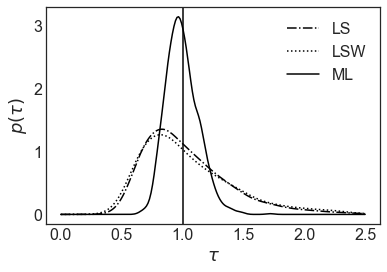

In [9]:
# decay time KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0,2.5,200)
densityLS = gaussian_kde(result_array.T[0])
densityLSW = gaussian_kde(result_array.T[6])
densityML = gaussian_kde(result_Bayes_array.T[2])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.savefig("tau_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

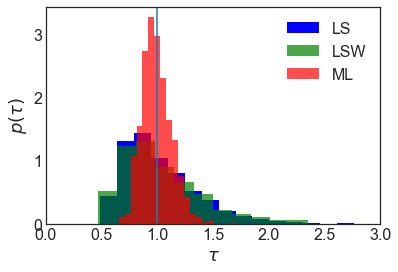

In [10]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],density=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[6],density=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[2],density=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [11]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

phiW = 1/result_array.T[9]
thetaW = 1/result_array.T[7]
omegaW = 1/result_array.T[10]
dAW = np.sqrt(-theta/(phi*theta-omega**2))
dTW = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

In [12]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.0511330280624347
Decay time LS std (real): 0.3905818920277206
Decay time LS stderr (real): 0.0039058189202772057
Decay time (mean-true)/stderr: 13.091499914902776
Decay time LS std (fit): 0.016478751794738906
Decay time LS std (fit corrected): 0.01657870257363243
Decay time LSW mean (real): 1.953151405981036
Decay time LSW std (real): 2.062856350876919
Decay time LSW stderr (real): 0.020628563508769193
Decay time (mean-true)/stderr: 46.20541830631357
Decay time LSW std (fit): 0.10150797451666932
Decay time LSW std (fit corrected): 0.01657870257363243
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101


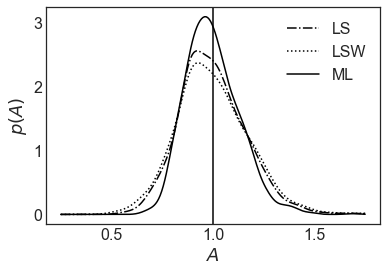

In [13]:
# amplitude KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0.25,1.75,200)
densityLS = gaussian_kde(result_array.T[2])
densityLSW = gaussian_kde(result_array.T[8])
densityML = gaussian_kde(result_Bayes_array.T[0])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
plt.savefig("A_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

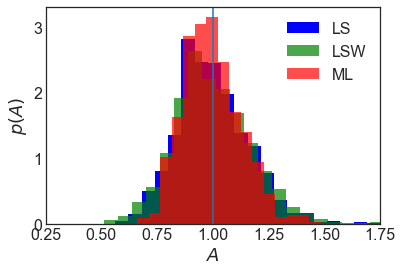

In [14]:
# amplitude
plt.hist(result_array.T[2],density=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[8],density=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[0],density=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [15]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.9984105682703185
Amplitude LS std (real): 0.16181660243234747
Amplitude LS stderr (real): 0.0016181660243234748
Amplitude LS std (fit): 0.01145025908410378
Amplitude LS std (fit corrected): 0.0113979437567719
Amplitude LSW mean (real): 4.692624086158618
Amplitude LSW std (real): 8.3673321023892
Amplitude LSW stderr (real): 0.08367332102389201
Amplitude LSW std (fit): 0.9950832668790089
Amplitude LSW std (fit corrected): 0.0113979437567719
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702


(1000, 12)
(1000, 4)
(0.3183106738638477, 5.548446448599749e-25)


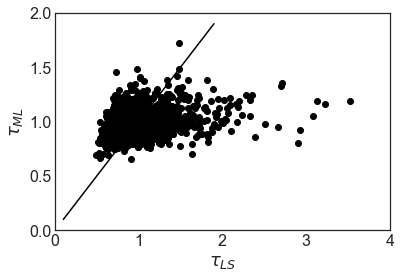

In [16]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2],color="k")
plt.plot([0.1,1.9],[0.1,1.9],"k")
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8370114347767423, 1.3727086902427204e-263)


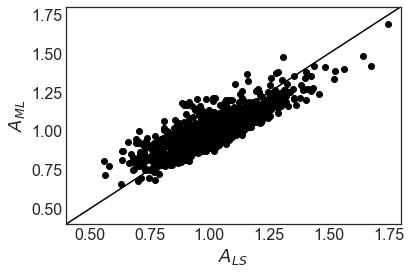

In [17]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0],color="k")
plt.plot([0,1.8],[0,1.8],"k")
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [18]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],dA,result_array.T[0],dT):
    print(i,a,da,t,dt)

0 0.808615696056012 0.00544211158822298 0.9939418654806541 0.009520460345979705
1 0.7384507401780944 0.014800775155431269 1.659481283174133 0.04862577555746138
2 0.8189945390255113 0.008341269650960773 1.2161571144605954 0.017689000724257463
3 1.177426213439023 0.008512380556837134 0.869670623699744 0.008946273247059084
4 1.0437891737470233 0.014007021533873081 0.6674355511975543 0.012763371773673647
5 0.883051617048809 0.00858219052936581 0.7431840677695469 0.010284184173800653
6 0.9986686993248759 0.005205087905933227 0.8289406605407509 0.006148559498558599
7 0.8705609103632095 0.007324202103499727 1.2761723469792459 0.015361640341763991
8 1.0469415961904982 0.004889410637600746 1.0666728821039506 0.0070945098128067305
9 0.8705229773500358 0.005136756260122944 1.404644623697107 0.011921526795272194
10 1.210331143970472 0.021603434174906247 0.6449979054220899 0.01641139632324621
11 1.0678373545348654 0.012159441384276045 1.5898917788383589 0.02633043239929993
12 1.0466327034058365 0.0

656 1.0419611587831445 0.010706304584901134 0.6016159816963211 0.008814440906433869
657 1.3796906367257336 0.02222836263394379 0.701316109097676 0.01609135223724567
658 1.0016502579041822 0.0196156387040846 0.6052074257861851 0.01690327110643452
659 0.8068790536838826 0.01054494900882596 1.209396393375598 0.02256727351677917
660 0.8448943450381698 0.008104959206695895 0.5985731767133358 0.00818731340133432
661 1.425040936832656 0.017156454556700167 0.8211897195886859 0.0140687801472775
662 0.9792009851114964 0.011699141806397096 0.6683429612381256 0.011377033103454235
663 1.1043645708874874 0.010658960854813097 0.815656013010224 0.011202964241582554
664 1.0718439886361044 0.01633558504317089 0.8307712651697817 0.018019844322990988
665 1.0101628959444144 0.009785476078363185 1.1163078044779504 0.015409466846674937
666 0.9449476385226756 0.01353094102886937 0.7002314306188846 0.014283221469951495
667 0.8350402235908381 0.005394747890803705 0.8595852550244348 0.007902538829889031
668 0.89

In [19]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))
print(acf.shape)

0.00E+00
-79527971.70080663
0.3989422804014327
2.59E-01
-0.18841818509930627
(500,)


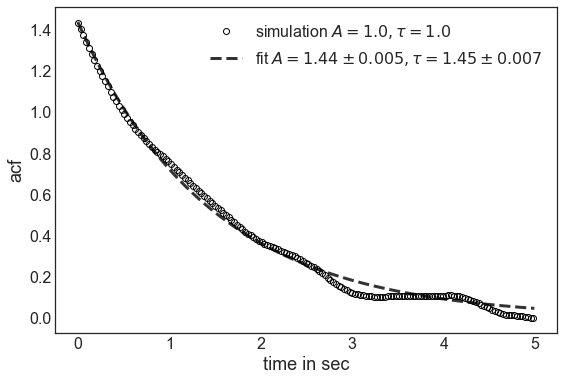

In [20]:
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,"k--",linewidth=3,label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [21]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [22]:
# plot deviation from true D as function of N
Nsim = np.array([2000,10000,50000])
Nsimfit = np.array([1500,10000,60000])
dD = np.array([0.36,0.05,0.014])

(0.005, 1)

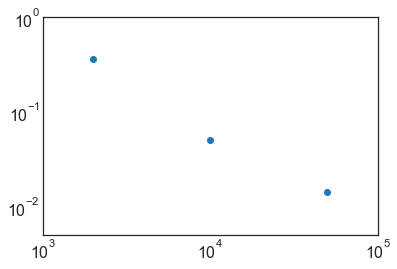

In [23]:
plt.plot(Nsim,dD,"o")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))

In [24]:
lnNsim = np.log(Nsim)
lndD = np.log(dD)

In [25]:
p = np.polyfit(lnNsim,lndD,1)

In [26]:
# dD = A*Nsim**gamma
# ln dD = ln A + gamma*ln Nsim
dDfit = np.exp(p[1])*Nsimfit**p[0]

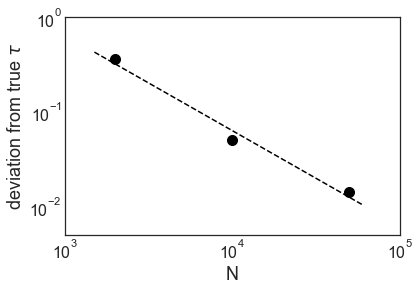

In [27]:
plt.plot(Nsim,dD,"ko",markersize=10)
plt.plot(Nsimfit,dDfit,"k--")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))
plt.xlabel("N")
plt.ylabel(r"deviation from true $\tau$")
plt.savefig("deviation.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6488.44draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8851791657755924, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
A,1.449213,0.020242,0.000122,1.409179,1.488717,28062.756745,1.000056
tau,1.443693,0.025239,0.000164,1.393781,1.492437,27556.787436,1.000006


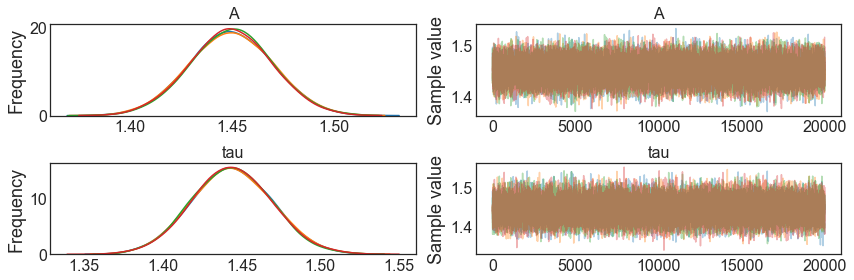

In [28]:
with pm.Model() as model:
    A = pm.Uniform('A', lower=0, upper=50)
    tau = pm.Uniform('tau', lower=0, upper=50)

    likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/tau),tau=1/acf_std**2,observed=acf)
    
    trace = pm.sample(20000,tune=10000)
    
pm.traceplot(trace)
pm.summary(trace)

[1.40944677 1.42906883 1.43553464 1.44919091 1.4629229  1.46936863
 1.48900616]
[1.39483644 1.41833223 1.42653589 1.443436   1.4607388  1.46909529
 1.49363284]
A_sigma 0.020149900269664678
tau_sigma 0.025381528710350154


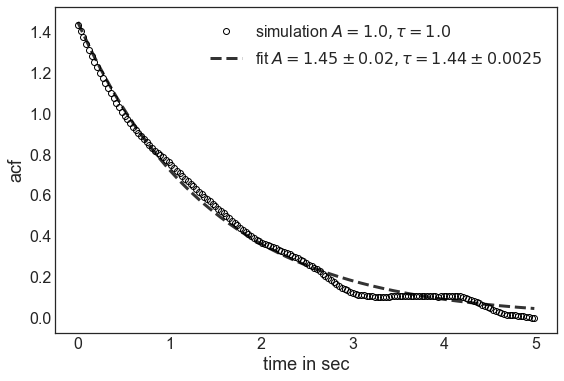

In [29]:
A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
tau_perc=np.percentile(trace['tau'],[2.5,15.865,25,50,75,84.135,97.5])
print(A_perc)
print(tau_perc)
print('A_sigma',(A_perc[5]-A_perc[1])/2)
print('tau_sigma',(tau_perc[5]-tau_perc[1])/2)
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t[::3],trace['A'].mean()*np.exp(-t[::3]/trace['tau'].mean()),"k--",linewidth=3,label=r"fit $A=1.45\pm0.02,\tau=1.44\pm0.0025$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
#plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

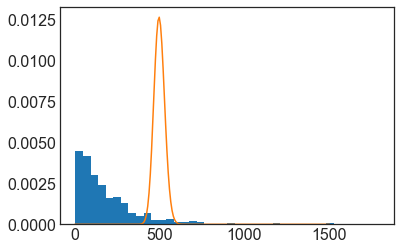

In [30]:
# lets look at the chi^2 distribution of the least-square fit
x=np.linspace(0,1500,200)
chi2dist = chi2.pdf(x,500-2)
plt.hist(result_array.T[11],bins=40,density=True)
plt.plot(x,chi2dist)

In [31]:
result_array.T[11].mean()

192.78086697829272

In [32]:
# use mcmc for all fits
mcmc_results = None

for i,y in enumerate(acf_all):
    with pm.Model() as model:
        A = pm.Uniform('A', lower=0, upper=50)
        tau = pm.Uniform('tau', lower=0, upper=50)

        likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/tau),tau=1/acf_std**2,observed=y)
    
        trace = pm.sample(20000,tune=10000)
    A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
    tau_perc=np.percentile(trace['tau'],[2.5,15.865,25,50,75,84.135,97.5])
    print(A_perc)
    print(tau_perc)
    A_sigma = (A_perc[5]-A_perc[1])/2
    tau_sigma = (tau_perc[5]-tau_perc[1])/2
    A_med = A_perc[3]
    tau_med = tau_perc[3]
    if mcmc_results is None:
        mcmc_results = np.array([A_med,tau_med,A_sigma,tau_sigma])
    else:
        mcmc_results = np.vstack((mcmc_results,np.array([A_med,tau_med,A_sigma,tau_sigma])))




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6505.67draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74955598 0.77300242 0.78112091 0.79788158 0.81488076 0.82318883
 0.84825239]
[0.93689697 0.97349977 0.98640246 1.01358439 1.0409898  1.05459028
 1.09597562]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6001.87draws/s]
The acceptance probability does not match the target. It is 0.7134765962587373, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6973330665753777, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61734993 0.63758918 0.64447096 0.6589504  0.67369921 0.68076052
 0.70191439]
[1.78315062 1.86544208 1.89388701 1.95663622 2.02153814 2.05398199
 2.15530043]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6648.78draws/s]
The acceptance probability does not match the target. It is 0.634531027765606, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7360674  0.75836538 0.76607747 0.78209975 0.79831109 0.80607698
 0.82918634]
[1.20071684 1.24800951 1.26466629 1.29965849 1.33559854 1.3532124
 1.40892459]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6511.41draws/s]
The acceptance probability does not match the target. It is 0.8844337297616512, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.14246163 1.16704408 1.17541445 1.19301707 1.21069917 1.21927731
 1.24435985]
[0.80941393 0.83022167 0.83752368 0.85260358 0.86778476 0.87532664
 0.89793746]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6830.55draws/s]
The acceptance probability does not match the target. It is 0.8805930569680976, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01099515 1.03789363 1.0469329  1.06627255 1.08581919 1.09527796
 1.12353061]
[0.60600601 0.62505009 0.6314622  0.64490217 0.65869552 0.66541661
 0.6855272 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6565.28draws/s]
The acceptance probability does not match the target. It is 0.8954614934892081, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82993603 0.85815218 0.86762796 0.88748903 0.90757189 0.91716446
 0.94653506]
[0.67731646 0.70484985 0.7145961  0.73506788 0.75613359 0.7666423
 0.79910961]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6735.28draws/s]
The acceptance probability does not match the target. It is 0.6584632642930828, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.95214063 0.97738579 0.98604217 1.0039731  1.02200583 1.03082828
 1.05758226]
[0.77109506 0.79616987 0.80458259 0.82240655 0.84083759 0.84988348
 0.87685732]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6683.67draws/s]


[0.81923258 0.83940257 0.84637854 0.86101874 0.87563144 0.88268431
 0.90339034]
[1.22340987 1.26067669 1.27345119 1.30021943 1.32799509 1.34157765
 1.38200075]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6595.42draws/s]
The acceptance probability does not match the target. It is 0.6766297614229319, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99950417 1.02234324 1.0301975  1.04662712 1.06288428 1.07076592
 1.09416264]
[1.00770302 1.03614717 1.04577026 1.06636483 1.08732265 1.09758779
 1.12886949]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6505.86draws/s]
The acceptance probability does not match the target. It is 0.6812684321629051, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6371600063002006, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81038084 0.8303697  0.83724577 0.85161327 0.866194   0.87322783
 0.89412486]
[1.35706213 1.40002369 1.41497849 1.44648043 1.47930727 1.4952434
 1.5422501 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6505.78draws/s]
The acceptance probability does not match the target. It is 0.7096421937284996, but should be close to 0.8. Try to increase the number of tuning steps.


[1.18755754 1.21530537 1.22473136 1.24393233 1.26378814 1.27325418
 1.30174828]
[0.58597065 0.60111073 0.60628977 0.61708318 0.62820703 0.63350857
 0.64984532]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6249.10draws/s]
The acceptance probability does not match the target. It is 0.8836606539717585, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6667668683623474, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.98186449 1.00147702 1.00825845 1.02243129 1.0365574  1.04313016
 1.06304822]
[1.59798631 1.63953823 1.65433501 1.68494674 1.7167415  1.73252242
 1.77916199]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6133.26draws/s]
The acceptance probability does not match the target. It is 0.6016521506062109, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96215719 0.98149689 0.98797566 1.00166109 1.01535349 1.02207733
 1.04141378]
[1.69832224 1.74458212 1.76036235 1.7941589  1.82859553 1.84544375
 1.89666278]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6456.86draws/s]


[0.89299839 0.91111126 0.91722618 0.92983916 0.94250726 0.94869765
 0.96731835]
[1.78176355 1.82861044 1.84488608 1.87901687 1.91470453 1.93210371
 1.98460906]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6509.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70129256 0.72024089 0.72679708 0.74055904 0.75455994 0.76129157
 0.7812358 ]
[1.50680236 1.56036705 1.57860426 1.61784376 1.65902647 1.67886087
 1.73994645]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6693.28draws/s]


[0.78447621 0.80775015 0.81560001 0.832186   0.84908109 0.85721074
 0.88211889]
[0.97125365 1.00744283 1.02037513 1.04649852 1.07333688 1.0866771
 1.1271528 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6342.86draws/s]
The acceptance probability does not match the target. It is 0.7025251361003858, but should be close to 0.8. Try to increase the number of tuning steps.


[0.66711465 0.68621284 0.69281743 0.70662204 0.72039101 0.72709026
 0.7466957 ]
[1.68882878 1.75386131 1.77646862 1.82524138 1.87595457 1.90064176
 1.97684366]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6632.43draws/s]
The acceptance probability does not match the target. It is 0.6455322984673159, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8866873  0.90971387 0.91746575 0.93357542 0.95010236 0.95797934
 0.98133892]
[0.98515404 1.01603481 1.02651013 1.04939486 1.07242183 1.08359713
 1.11747476]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6752.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.833758   0.85754574 0.86553528 0.88202592 0.89865685 0.90678541
 0.93115823]
[0.93862575 0.97035823 0.98179044 1.00518705 1.02910923 1.04059125
 1.07660113]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6806.77draws/s]
The acceptance probability does not match the target. It is 0.6695708658450104, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.12193542 1.14655879 1.15494679 1.17244059 1.18994835 1.19833185
 1.22375151]
[0.71631919 0.73310065 0.73892559 0.751032   0.76345337 0.76943496
 0.7872956 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6022.07draws/s]
The acceptance probability does not match the target. It is 0.9168672214133493, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87963993 0.89747738 0.90367056 0.91637417 0.92949123 0.93564254
 0.95411756]
[1.67146142 1.71493885 1.73049365 1.7630612  1.79577276 1.81178992
 1.85986353]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6122.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.90939713 0.92601868 0.93172129 0.94362794 0.95556738 0.96137392
 0.97850694]
[2.10842009 2.16194123 2.18084537 2.21990156 2.26013423 2.27974848
 2.33939191]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6875.82draws/s]
The acceptance probability does not match the target. It is 0.6575444413893554, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.02858019 1.0558862  1.06501868 1.08437549 1.10391321 1.11312534
 1.14110575]
[0.61464572 0.63301371 0.63937773 0.65273573 0.66636498 0.67315307
 0.69337724]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6603.35draws/s]
The acceptance probability does not match the target. It is 0.7123293692366276, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82478515 0.84394622 0.85063398 0.86435004 0.87821409 0.88485088
 0.90494741]
[1.37859191 1.41879063 1.43291857 1.46216261 1.49239417 1.50711282
 1.55129724]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6842.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.93236061 0.95899524 0.96780364 0.9866152  1.00566527 1.0148843
 1.0416883 ]
[0.64997143 0.67066927 0.67782926 0.69319544 0.70863862 0.71635275
 0.73943601]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6348.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86375014 0.88201031 0.88833289 0.90140932 0.91450391 0.92083597
 0.93945726]
[1.65938442 1.70471973 1.72022556 1.7538331  1.78803508 1.80469258
 1.85514355]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6463.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8790834  0.89776966 0.90409915 0.91752329 0.93100102 0.93758582
 0.95686005]
[1.61130039 1.65631963 1.67177804 1.70440114 1.73767083 1.75425014
 1.80451031]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5980.09draws/s]
The acceptance probability does not match the target. It is 0.9093269897373353, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78842202 0.811011   0.81882605 0.83512949 0.85122362 0.85916499
 0.88220947]
[1.08408799 1.12293567 1.13652052 1.16478217 1.19430138 1.20872245
 1.25252838]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6471.64draws/s]
The acceptance probability does not match the target. It is 0.6115808965355066, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.22413454 1.24750343 1.25549952 1.2721251  1.28860315 1.29662257
 1.32030486]
[0.95838626 0.98069679 0.98838779 1.00452667 1.0208373  1.02866182
 1.05244358]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6655.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83247343 0.85762441 0.86607098 0.88418551 0.90215217 0.91086937
 0.93731966]
[0.82636849 0.85746211 0.86816348 0.89104158 0.91410108 0.92532905
 0.9593454 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6424.20draws/s]
The acceptance probability does not match the target. It is 0.6966306392019158, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6934196907972854, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82013086 0.84224634 0.84968653 0.86525864 0.88105445 0.88879548
 0.91129743]
[1.25658148 1.30142178 1.31702261 1.34964867 1.38336925 1.3994386
 1.4498968 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6757.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.89527709 0.91925799 0.92744081 0.94499148 0.96251728 0.97108256
 0.99596382]
[0.76720125 0.79122463 0.79927959 0.81668008 0.83449136 0.84313835
 0.86928196]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6730.33draws/s]
The acceptance probability does not match the target. It is 0.6867457213642706, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.96176481 0.98985788 0.99926749 1.01910926 1.0389574  1.04856781
 1.07641752]
[0.61980622 0.64082043 0.64810992 0.66348014 0.67950806 0.68720629
 0.71111075]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6616.26draws/s]
The acceptance probability does not match the target. It is 0.7050440166926606, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86563505 0.88786026 0.89550872 0.91148487 0.9277353  0.93561021
 0.95861144]
[1.03380767 1.06708168 1.07841259 1.10224851 1.12679831 1.13902688
 1.17489254]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6698.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82424014 0.85325039 0.86310263 0.88406719 0.90530001 0.91563621
 0.94688978]
[0.58925444 0.61559627 0.62478085 0.64437775 0.66437934 0.67425422
 0.70401949]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6655.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81424167 0.83992061 0.8488564  0.8677716  0.88654407 0.89566833
 0.92270402]
[0.76832996 0.79925574 0.80964762 0.83196274 0.85538612 0.86677746
 0.90211744]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6530.49draws/s]
The acceptance probability does not match the target. It is 0.7083592680026655, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.13712178 1.16305605 1.17195708 1.19053205 1.2093935  1.2182648
 1.2456895 ]
[0.67641293 0.69428742 0.70041631 0.7132948  0.72651304 0.73278082
 0.75205847]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6321.83draws/s]
The acceptance probability does not match the target. It is 0.8836114739219127, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03229154 1.05432335 1.06190739 1.07746037 1.09315675 1.10071615
 1.12326103]
[1.13700676 1.16723515 1.17777169 1.19974604 1.22225677 1.23311381
 1.26656442]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6534.47draws/s]
The acceptance probability does not match the target. It is 0.8795443383059359, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6858452528471682, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.43264097 1.4545427  1.46219772 1.47767456 1.49321835 1.50096496
 1.52288392]
[0.90525006 0.92030008 0.92551192 0.93646464 0.94736145 0.95258088
 0.96846089]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6855.15draws/s]
The acceptance probability does not match the target. It is 0.88272520978601, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87188538 0.89448011 0.90237754 0.91854321 0.93488831 0.94286092
 0.96639592]
[0.89673121 0.92429245 0.93368802 0.95332893 0.97342407 0.98312058
 1.01337453]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6808.14draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.01697118 1.03698075 1.04369147 1.05793501 1.07220885 1.07910502
 1.10007681]
[1.22033893 1.24932248 1.25928909 1.28008973 1.30078652 1.3110835
 1.34259797]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6835.15draws/s]


[1.08288347 1.1088029  1.11738631 1.13515557 1.15366399 1.16268689
 1.18926636]
[0.67901953 0.69715365 0.70352451 0.71655267 0.72996442 0.73642718
 0.75588189]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6332.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.21701491 1.23483213 1.24100608 1.25375391 1.26675974 1.27276415
 1.29089883]
[1.7833627  1.81727032 1.82922548 1.85451007 1.88028619 1.89284296
 1.93091629]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5733.43draws/s]
The acceptance probability does not match the target. It is 0.9027809944399577, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5996752796945373, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59126669 0.61323653 0.62093462 0.63714643 0.65386689 0.66193792
 0.68608739]
[1.24643682 1.31090279 1.33344266 1.38141636 1.43128305 1.45597689
 1.53075625]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6799.86draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6009225088170426, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.20257384 1.22440789 1.23192824 1.2479429  1.26372591 1.27139418
 1.29469375]
[0.96934968 0.99047572 0.99780337 1.01289295 1.02827129 1.03569716
 1.05808713]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6496.66draws/s]
The acceptance probability does not match the target. It is 0.6924151699190365, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0372097  1.06424257 1.07344195 1.09255004 1.11208975 1.12156046
 1.15015482]
[0.59257412 0.60977614 0.6157732  0.628438   0.64110162 0.64717857
 0.66580262]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6614.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.00018359 1.02464629 1.03284458 1.05065479 1.06828529 1.07701746
 1.10273845]
[0.80080229 0.824219   0.83225375 0.84944236 0.86709381 0.87569055
 0.90144308]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6490.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83466339 0.86039756 0.86905449 0.88728402 0.90578956 0.9146101
 0.94160894]
[0.73301709 0.76022895 0.76951353 0.78905103 0.80931378 0.8193228
 0.84946319]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6104.21draws/s]


[1.72558612 1.74445908 1.75096163 1.76451221 1.7780793  1.78481406
 1.80402478]
[1.42360528 1.44274077 1.44933311 1.46346357 1.47739143 1.48424445
 1.50482673]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6604.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9778839  1.00220122 1.01061493 1.028066   1.04578774 1.05431189
 1.07954382]
[0.77613505 0.79889711 0.80672776 0.8231367  0.84013287 0.84821776
 0.87335609]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6729.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86289597 0.89069946 0.90010932 0.91957228 0.93918968 0.94874583
 0.97770747]
[0.63923986 0.66443145 0.67300396 0.69116239 0.70953257 0.71896763
 0.74676999]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6084.24draws/s]
The acceptance probability does not match the target. It is 0.8990645900313814, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77585953 0.80295617 0.81250901 0.8318201  0.85153276 0.86106259
 0.88905293]
[0.76481701 0.79917883 0.81098323 0.83618626 0.86251002 0.87580013
 0.915925  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6129.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.04144114 1.05733416 1.06284255 1.07423317 1.08564217 1.0911568
 1.10748948]
[2.2322786  2.27899511 2.29586231 2.32993087 2.36532621 2.38274434
 2.4353828 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6772.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73154095 0.75496426 0.7629898  0.78010297 0.79737023 0.80568092
 0.83004076]
[0.89278183 0.92743033 0.93986812 0.96585532 0.992632   1.0057534
 1.04554182]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6405.36draws/s]
The acceptance probability does not match the target. It is 0.6170719582331069, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96387776 0.98607291 0.99380518 1.00959489 1.02581843 1.03342513
 1.05644114]
[0.94896648 0.97452863 0.98339665 1.00184487 1.02044222 1.02962308
 1.05742963]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6433.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94082404 0.96419462 0.97233299 0.98916134 1.00589759 1.01393403
 1.03820868]
[0.92091611 0.94864786 0.958101   0.97834239 0.99885381 1.00883706
 1.03893677]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6469.63draws/s]
The acceptance probability does not match the target. It is 0.6893581439289725, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5750089404946575, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77509083 0.79570852 0.80295035 0.81795347 0.8331553  0.84056825
 0.86267002]
[1.20926355 1.2508071  1.26494065 1.29529914 1.32614864 1.34108968
 1.38668134]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6601.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.173855   1.19557836 1.20288995 1.21835559 1.23363464 1.24120055
 1.26309709]
[0.98394343 1.00420685 1.01114068 1.02589017 1.04094385 1.04848802
 1.07066331]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6023.40draws/s]
The acceptance probability does not match the target. It is 0.7064181760887587, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84672041 0.86985046 0.87756741 0.89365715 0.91002643 0.91804216
 0.94178906]
[1.19637364 1.23920538 1.25375561 1.28487264 1.31647247 1.3321901
 1.37999552]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6603.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.98703717 1.01118827 1.01942806 1.03675269 1.05391078 1.06232401
 1.08693418]
[0.84928909 0.8734517  0.88206179 0.90026852 0.91867313 0.92785533
 0.9551229 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6413.40draws/s]
The acceptance probability does not match the target. It is 0.6622584094992874, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73888211 0.76028144 0.76758908 0.78301768 0.79855189 0.80603263
 0.82855499]
[1.09307751 1.13261125 1.14600706 1.17429188 1.20341911 1.21784846
 1.26123593]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6216.87draws/s]
The acceptance probability does not match the target. It is 0.6981542326876404, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.90318058 0.93275158 0.94270808 0.96302513 0.9839358  0.99410049
 1.02490469]
[0.57119622 0.59300097 0.6006668  0.61667592 0.63321734 0.64144738
 0.66611261]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:23<00:00, 5025.07draws/s]
The acceptance probability does not match the target. It is 0.8847821291673746, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.879279759623912, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7681048  0.80249024 0.81384413 0.83764027 0.86179643 0.8735257
 0.90830236]
[0.91163612 0.96785487 0.98813674 1.03147899 1.07764143 1.10157839
 1.17535919]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6594.66draws/s]
The acceptance probability does not match the target. It is 0.8923327171786873, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.90091111 0.92518668 0.93331581 0.95029252 0.96763639 0.97593648
 1.00109409]
[0.81532757 0.84077224 0.84967093 0.86802629 0.88690615 0.89601213
 0.9234809 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6307.25draws/s]
The acceptance probability does not match the target. It is 0.7110781472985125, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8898616739723739, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.20699847 1.23423095 1.24349117 1.26322976 1.28275201 1.29230226
 1.32087527]
[0.65323186 0.67096482 0.67719839 0.68986309 0.70288896 0.70943069
 0.72891734]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6177.68draws/s]
The acceptance probability does not match the target. It is 0.7113284135140169, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94742466 0.97667239 0.98671054 1.00759732 1.02854221 1.0388121
 1.06818198]
[0.57530369 0.59628997 0.60374381 0.61974248 0.63596177 0.64402706
 0.66906632]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6224.68draws/s]
The acceptance probability does not match the target. It is 0.7197245783023363, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83721189 0.86691617 0.8770188  0.89825298 0.91943259 0.9298304
 0.96094432]
[0.53282081 0.55514163 0.56280871 0.57925602 0.59607483 0.60439808
 0.62893921]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5949.69draws/s]
The acceptance probability does not match the target. It is 0.6928704188660939, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.13846921 1.16300511 1.17141379 1.18914065 1.20682398 1.21528744
 1.24039868]
[0.84939068 0.87166237 0.87947762 0.89575655 0.91232288 0.92032275
 0.94466153]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6196.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.2745846  1.29585172 1.30294918 1.31790915 1.33269724 1.33990449
 1.36133666]
[1.00166337 1.01951141 1.0258964  1.03886354 1.05218959 1.05863448
 1.07825084]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6292.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.96020364 0.98453274 0.99289324 1.01025886 1.0276376  1.03610296
 1.06160071]
[0.80609796 0.83039512 0.83908953 0.85677251 0.87487172 0.88379739
 0.91004457]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6255.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.89081823 0.91459217 0.92287776 0.93996285 0.9574144  0.96592515
 0.99053268]
[0.8999646  0.92927015 0.93963982 0.96163351 0.98414591 0.99505452
 1.0284648 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6194.07draws/s]


[0.92608113 0.94938521 0.95756405 0.9742536  0.99115    0.99944044
 1.02385757]
[0.88157568 0.90800302 0.91734445 0.9367458  0.95683177 0.96641229
 0.99564091]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6501.80draws/s]
The acceptance probability does not match the target. It is 0.8947723686715578, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.22102305 1.249908   1.25991289 1.28056881 1.30135763 1.3113517
 1.34068436]
[0.54664409 0.56163924 0.56675574 0.57747695 0.58843965 0.59395755
 0.6099051 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6160.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.89749412 0.92635824 0.93611737 0.95626739 0.97680369 0.98661535
 1.01642211]
[0.57840033 0.60015962 0.60768608 0.62356071 0.63996984 0.64787107
 0.67194267]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6616.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72377135 0.750198   0.75931316 0.77845383 0.79771565 0.80699734
 0.83457215]
[0.6943475  0.72596503 0.73695694 0.75984405 0.78357472 0.79537173
 0.83104564]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6461.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.21878391 1.2441253  1.25292104 1.27095354 1.28920406 1.29788492
 1.32370306]
[0.69689046 0.7133166  0.71896778 0.73074775 0.74275366 0.74862208
 0.76602595]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6274.43draws/s]
The acceptance probability does not match the target. It is 0.6671757148906141, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.2407017  1.26437758 1.27247907 1.28919577 1.30616613 1.31444876
 1.33862468]
[0.80591951 0.82321045 0.82924429 0.84182468 0.85453285 0.86073612
 0.87953191]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5939.96draws/s]
The acceptance probability does not match the target. It is 0.878823827715946, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3809365576333032, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.719916384360032, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65836553 0.68154848 0.68949922 0.7058271  0.72250898 0.73063221
 0.75516744]
[1.12730135 1.17919762 1.19758395 1.23609519 1.27590353 1.2958701
 1.35578963]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6330.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67205972 0.69415943 0.7019467  0.71779006 0.73398069 0.74170974
 0.7649766 ]
[1.02529462 1.06652266 1.08105857 1.11205822 1.14379222 1.15943871
 1.20768719]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5944.67draws/s]
The acceptance probability does not match the target. It is 0.8807050612896042, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4156578278897736, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.93116684 0.95540934 0.96339746 0.98026767 0.99731496 1.00551039
 1.03005888]
[1.19663678 1.23737015 1.25163302 1.28168755 1.31254154 1.32755252
 1.37450542]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6091.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.93899799 0.96490439 0.97380639 0.99236603 1.01113114 1.02009413
 1.04676513]
[0.87975154 0.91132398 0.92227054 0.94573552 0.96946573 0.98110715
 1.01687217]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6371.49draws/s]
The acceptance probability does not match the target. It is 0.7018380624559182, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79060397 0.80824356 0.81427912 0.82679103 0.8396146  0.84578916
 0.86394485]
[1.65641401 1.70396885 1.72049784 1.7550121  1.7901923  1.8078138
 1.86095162]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6729.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.11714771 1.14574083 1.15557997 1.17586791 1.19611108 1.20601109
 1.23541732]
[0.5656136  0.58217995 0.58791625 0.5999734  0.61231234 0.61844768
 0.63684311]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6367.77draws/s]
The acceptance probability does not match the target. It is 0.9117667581300342, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9193144  0.94443282 0.95291883 0.97061118 0.98833706 0.99681111
 1.02252493]
[0.78160008 0.80661765 0.81509553 0.83321876 0.8513997  0.86044976
 0.88817498]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6547.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.91343994 0.93732116 0.94562371 0.96265024 0.97988061 0.98837344
 1.01316437]
[0.77463655 0.79803917 0.80592106 0.82268616 0.83950568 0.84776978
 0.87261696]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6427.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.31843024 1.34105741 1.34865025 1.36461971 1.38032845 1.38807586
 1.41092288]
[1.01450454 1.03509623 1.04211822 1.05705135 1.07221516 1.07970082
 1.10179917]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6939.08draws/s]
The acceptance probability does not match the target. It is 0.640767456240274, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.10605684 1.1358834  1.14610677 1.16792485 1.18962468 1.20010919
 1.23129154]
[0.48133525 0.49603166 0.50124369 0.5120953  0.52311519 0.52855211
 0.54452961]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6652.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.95935838 0.98197142 0.98958779 1.00564267 1.02199622 1.02990813
 1.05357255]
[1.02448069 1.0546243  1.06494117 1.08698173 1.10920105 1.12031543
 1.1530653 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6734.62draws/s]
The acceptance probability does not match the target. It is 0.716953287779587, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.22275055 1.24274192 1.24948992 1.26366284 1.2776718  1.28454888
 1.30511897]
[1.31915215 1.34478139 1.35387007 1.37283785 1.39233877 1.40151354
 1.430012  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6755.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.91388867 0.94054948 0.94951436 0.96835782 0.98743119 0.99661411
 1.02398521]
[0.64621145 0.66743457 0.67473346 0.69039182 0.70630557 0.71411833
 0.73704071]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6187.86draws/s]
The acceptance probability does not match the target. It is 0.8856083545922228, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87987974 0.90398491 0.91216766 0.9295477  0.94728934 0.95593791
 0.98135347]
[1.05329409 1.09223545 1.10568336 1.13429728 1.16351902 1.17821099
 1.22105451]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6523.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84094204 0.86935455 0.87898626 0.89914888 0.91963153 0.92964212
 0.95963888]
[0.68898759 0.71887168 0.72941874 0.75137304 0.77418136 0.78532415
 0.82002327]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6722.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.00259461 1.02531638 1.0330813  1.04943585 1.06564754 1.07358203
 1.09704162]
[0.96810267 0.99474799 1.003823   1.02329394 1.04336163 1.05316318
 1.08275484]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6537.01draws/s]
The acceptance probability does not match the target. It is 0.8894610406110504, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84307392 0.86989422 0.8792593  0.89868319 0.91803314 0.92730765
 0.95579703]
[0.69662781 0.72346444 0.73306626 0.75306942 0.77352865 0.7836741
 0.81438728]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6636.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.10511964 1.12368229 1.13004165 1.14302562 1.15594158 1.16223051
 1.18048616]
[1.5103044  1.54105928 1.55167017 1.57396938 1.59692193 1.60784187
 1.64151201]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6633.66draws/s]
The acceptance probability does not match the target. It is 0.7208312189133396, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827915636999143, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88790847 0.91288088 0.92132255 0.93919494 0.95725543 0.96575072
 0.9915564 ]
[0.72037585 0.74345457 0.75152961 0.76838514 0.78550717 0.79401232
 0.81932787]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6492.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.0571707  1.08498534 1.09442492 1.11397008 1.13393327 1.1437971
 1.17248845]
[0.56663212 0.5832082  0.58891731 0.60084362 0.61313391 0.61921576
 0.63706136]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6863.00draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8395202  0.86977106 0.8802518  0.90186746 0.92370692 0.93440156
 0.96562397]
[0.51845502 0.54049907 0.54823506 0.5647159  0.58162007 0.58992442
 0.61551058]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6531.65draws/s]
The acceptance probability does not match the target. It is 0.6371157935010677, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82380722 0.85073697 0.85989001 0.87952853 0.89883417 0.90821196
 0.93660018]
[0.76683713 0.79910219 0.81016767 0.83380777 0.85822658 0.87005199
 0.90678335]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6331.68draws/s]


[1.08949182 1.11686241 1.12610092 1.14544832 1.1651488  1.17447128
 1.20260848]
[0.58061101 0.59646497 0.60191154 0.61351561 0.62535276 0.63107931
 0.64823158]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6656.69draws/s]
The acceptance probability does not match the target. It is 0.5963916652105421, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1696242  1.18986387 1.1968339  1.21117797 1.22568263 1.23273307
 1.25368957]
[1.22613383 1.2524709  1.26124349 1.27993415 1.29897613 1.30801156
 1.3359859 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6508.07draws/s]
The acceptance probability does not match the target. It is 0.7087105845272983, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.02270118 1.04656063 1.05469638 1.07183669 1.08916788 1.0976044
 1.12217648]
[0.84876033 0.87326581 0.88185269 0.89916968 0.91698924 0.92555612
 0.95161747]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6740.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81290689 0.83806685 0.84665667 0.86478009 0.88299836 0.89184211
 0.91803217]
[0.73029124 0.75628192 0.76536833 0.78441575 0.80403643 0.81353946
 0.84252077]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6663.93draws/s]
The acceptance probability does not match the target. It is 0.7032693499222029, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7192819031873461, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.0471953  1.07249718 1.08087114 1.09831083 1.1164157  1.12494523
 1.15064067]
[0.90902682 0.93643208 0.94574179 0.96554308 0.98578345 0.99572755
 1.0264108 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6761.54draws/s]
The acceptance probability does not match the target. It is 0.8807118017328892, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81314159 0.83664572 0.84450868 0.86131717 0.87836268 0.88677667
 0.91095609]
[0.84485642 0.8740229  0.88411253 0.90497885 0.92627477 0.93673098
 0.96847223]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6480.06draws/s]
The acceptance probability does not match the target. It is 0.6738274236264251, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6120771182180968, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87580027 0.90410759 0.91410205 0.93454557 0.95536361 0.96518956
 0.99520672]
[0.55908921 0.58044671 0.58792692 0.60336053 0.61941017 0.62733929
 0.6512502 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6104.59draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.22759414 1.24640008 1.25291388 1.2662766  1.27980004 1.28635044
 1.3061903 ]
[1.33514383 1.35993536 1.36851495 1.38619795 1.40408864 1.41291138
 1.43902735]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6560.53draws/s]
The acceptance probability does not match the target. It is 0.6963307922155622, but should be close to 0.8. Try to increase the number of tuning steps.


[1.51770147 1.53971218 1.54718696 1.56265158 1.57818988 1.58559652
 1.60766331]
[0.99633377 1.01256935 1.01823491 1.03012928 1.04204225 1.04790401
 1.06535241]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6596.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8286773  0.85514446 0.86384629 0.88247647 0.90128572 0.9103769
 0.93746772]
[0.75050272 0.78007024 0.79008094 0.81143874 0.83313325 0.84376233
 0.87593695]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6716.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.10887313 1.13032921 1.13754043 1.15274668 1.1682336  1.17570093
 1.19815438]
[1.04732004 1.07133977 1.07965431 1.09715544 1.11476615 1.12335744
 1.14889402]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6676.38draws/s]
The acceptance probability does not match the target. It is 0.6802392592797611, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.18572446 1.20879121 1.21662472 1.23288236 1.24907436 1.25710213
 1.2812472 ]
[0.92222808 0.94292367 0.95016985 0.96536005 0.9804326  0.98794573
 1.01034145]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6549.85draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5422112971350479, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788003327352766, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74847981 0.76961241 0.77673633 0.79158613 0.80681216 0.81397665
 0.83549941]
[1.24427255 1.28777848 1.30265907 1.33445863 1.36769293 1.38362834
 1.43346969]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6476.88draws/s]
The acceptance probability does not match the target. It is 0.7114387518321219, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.96184881 0.98680067 0.99530576 1.01305987 1.03082047 1.03945852
 1.06526251]
[0.96004258 0.99208576 1.00292309 1.0263866  1.05030248 1.06250406
 1.09915387]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5715.04draws/s]
The acceptance probability does not match the target. It is 0.8881414540161048, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7228042  0.74838723 0.75695135 0.77509839 0.79351379 0.802467
 0.82984436]
[1.20848793 1.26869777 1.28965747 1.33456458 1.38094853 1.40357825
 1.47382666]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6863.68draws/s]
The acceptance probability does not match the target. It is 0.6755009787261104, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7120535145030112, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83593754 0.85892531 0.86668015 0.8829401  0.89924779 0.90715523
 0.93074816]
[0.8783787  0.90633476 0.91579551 0.9356673  0.95586242 0.96602511
 0.99619329]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6418.01draws/s]
The acceptance probability does not match the target. It is 0.898313101294202, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.16132925 1.18687435 1.1957667  1.21408977 1.23281211 1.24186374
 1.26854767]
[0.62342477 0.63820526 0.64332259 0.65405096 0.66486559 0.6700628
 0.68595103]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6390.67draws/s]
The acceptance probability does not match the target. It is 0.8915347042685695, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.28875468 1.30946926 1.3165021  1.33108184 1.34572426 1.3529362
 1.37381824]
[1.13871704 1.15949385 1.16675173 1.18207207 1.1976927  1.2053374
 1.22831071]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6509.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.03905477 1.06202276 1.06971601 1.08569602 1.10176243 1.10962079
 1.13303511]
[0.94561364 0.96970484 0.97802023 0.99568656 1.01366329 1.02215676
 1.04831647]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6546.35draws/s]
The acceptance probability does not match the target. It is 0.685047863731732, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6760962509678305, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87134678 0.89270684 0.90010829 0.91568806 0.93131635 0.93893468
 0.96141295]
[1.15999222 1.1965042  1.20882112 1.23552517 1.26267988 1.27603881
 1.31561821]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6777.54draws/s]
The acceptance probability does not match the target. It is 0.8840182521149588, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.29365407 1.31809715 1.32654547 1.34393708 1.36155041 1.37010888
 1.39563861]
[0.79918432 0.81671286 0.82297848 0.83592105 0.84903809 0.8553163
 0.87433179]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6534.22draws/s]


[1.18562447 1.20738029 1.21482474 1.23033277 1.24582388 1.25322812
 1.27594256]
[0.98413264 1.00528404 1.01262018 1.02768753 1.0431948  1.05058583
 1.07354209]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6259.86draws/s]
The acceptance probability does not match the target. It is 0.7063018463355766, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95181957 0.975431   0.98344701 0.99978963 1.01632047 1.02446567
 1.04881571]
[0.98388963 1.01351588 1.02371674 1.0452957  1.06718709 1.07817738
 1.11135821]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6549.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82715637 0.84783849 0.85497016 0.86979739 0.88495326 0.89215397
 0.91386465]
[1.18080979 1.21730662 1.23014174 1.25721174 1.28464781 1.29816439
 1.33878004]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6343.89draws/s]
The acceptance probability does not match the target. It is 0.88454241307523, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.21294792 1.23850935 1.2472983  1.26543567 1.28362867 1.29253084
 1.31912048]
[0.83614483 0.85834794 0.86598881 0.88212247 0.89836767 0.90643207
 0.93039252]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6238.45draws/s]
The acceptance probability does not match the target. It is 0.8923355291923801, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87789103 0.90032625 0.90785511 0.92391035 0.94000407 0.9478963
 0.97160079]
[1.02870413 1.06128286 1.07236337 1.09608821 1.1201885  1.13198099
 1.16796737]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6450.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77377187 0.79862586 0.80720395 0.82435418 0.84194953 0.85047475
 0.87538221]
[0.79476352 0.82347362 0.83359207 0.85491107 0.87680546 0.88781038
 0.92075969]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6745.79draws/s]
The acceptance probability does not match the target. It is 0.46523058922410987, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14519528 1.16710285 1.17471374 1.1901514  1.20577722 1.21348544
 1.23584705]
[1.00480454 1.02723965 1.03504448 1.05135198 1.06794329 1.07599969
 1.10029677]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6382.83draws/s]
The acceptance probability does not match the target. It is 0.7196050677805331, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6946096723715459, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84888725 0.86603946 0.87198901 0.88463046 0.89711254 0.9030661
 0.9205758 ]
[1.89152488 1.94354493 1.96195007 2.00002322 2.03941786 2.05912721
 2.11821173]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6309.66draws/s]
The acceptance probability does not match the target. It is 0.7191898609351697, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11266604 1.13995139 1.14946586 1.16908057 1.18904854 1.19877954
 1.22815117]
[0.56224088 0.5781148  0.58342571 0.59490057 0.60637925 0.61195738
 0.62880907]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6500.90draws/s]
The acceptance probability does not match the target. It is 0.7176111318041845, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97383301 0.99508828 1.00268341 1.01809759 1.03355493 1.04102905
 1.06289082]
[0.92333036 0.94569357 0.95349644 0.97001532 0.98656593 0.99458942
 1.01861844]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6575.67draws/s]


[1.55451476 1.57632239 1.58391515 1.59965197 1.61537008 1.62308287
 1.64605296]
[0.95304179 0.96871303 0.97405236 0.98520998 0.99643011 1.00198883
 1.01844584]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5943.46draws/s]
The acceptance probability does not match the target. It is 0.8844265790256878, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91950711 0.94060505 0.94791981 0.96324401 0.97847012 0.98582158
 1.00786493]
[1.35336478 1.39414177 1.40857713 1.43867998 1.46931431 1.48444675
 1.53067244]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6695.08draws/s]


[1.09138645 1.11216257 1.11894877 1.13322978 1.14763572 1.15467947
 1.17557092]
[1.21556925 1.24282034 1.25225599 1.2719162  1.29185362 1.30155775
 1.3312127 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6418.52draws/s]
The acceptance probability does not match the target. It is 0.7136920686278139, but should be close to 0.8. Try to increase the number of tuning steps.


[1.25768196 1.28587243 1.29533671 1.31514174 1.33506443 1.34465893
 1.37328277]
[0.58552997 0.60009985 0.60506017 0.61576517 0.626708   0.63200166
 0.64782633]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6022.65draws/s]
The acceptance probability does not match the target. It is 0.885299573717826, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6933120492709973, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81914353 0.83969238 0.84675601 0.8618666  0.87688721 0.88424239
 0.9058941 ]
[1.3798262  1.426254   1.44235117 1.47641158 1.51098949 1.52785555
 1.5803088 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6526.87draws/s]


[0.71328516 0.73772138 0.74614751 0.76345788 0.78127296 0.78982658
 0.8153138 ]
[0.87735443 0.91480888 0.92773418 0.95487149 0.98336772 0.99733239
 1.03948175]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6283.48draws/s]
The acceptance probability does not match the target. It is 0.8934798689057849, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8789856618080231, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75773041 0.78569076 0.79528132 0.81511433 0.83541203 0.84514251
 0.87423677]
[0.64943366 0.67831102 0.68844508 0.71006405 0.73272519 0.7438135
 0.77787188]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6465.25draws/s]
The acceptance probability does not match the target. It is 0.8853638936588683, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57653297 0.60115031 0.60936756 0.62682504 0.64431662 0.65297036
 0.67872571]
[0.82425936 0.86584714 0.88070008 0.91225762 0.94447813 0.9605489
 1.00955658]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6263.01draws/s]


[1.15735976 1.18110105 1.18927371 1.20597985 1.2229008  1.23109461
 1.25558916]
[0.77641659 0.79401915 0.80001373 0.81286406 0.82586627 0.83210996
 0.85090736]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6334.76draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.03482381 1.05610042 1.06368646 1.0791983  1.09502416 1.10273486
 1.12592006]
[1.07782924 1.10577886 1.11537234 1.13558917 1.15611033 1.16600334
 1.19573999]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6164.92draws/s]
The acceptance probability does not match the target. It is 0.7197176883933354, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13992743 1.1660243  1.17494648 1.19359072 1.21227489 1.22111504
 1.24777615]
[0.65718494 0.6735879  0.67927332 0.69128002 0.70353006 0.70960145
 0.72747773]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5926.48draws/s]
The acceptance probability does not match the target. It is 0.6609558882315955, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.25813717 1.28040262 1.28778036 1.30351965 1.31940881 1.32705974
 1.34982541]
[1.04291101 1.06504682 1.07266265 1.08887641 1.10521163 1.11313409
 1.13679333]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6358.53draws/s]
The acceptance probability does not match the target. It is 0.8851836403689072, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85837009 0.8820413  0.89019172 0.90734201 0.92440571 0.93277124
 0.95716448]
[0.82439413 0.85094739 0.86008525 0.87923914 0.89899244 0.90879982
 0.93752217]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6336.66draws/s]
The acceptance probability does not match the target. It is 0.7213241905558068, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.98741756 1.01528412 1.02478502 1.04476299 1.06465551 1.07448563
 1.10323492]
[0.79951186 0.8292976  0.83971599 0.86141492 0.88425572 0.89523232
 0.92912429]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6495.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.02784681 1.05355914 1.06256905 1.08066138 1.09908063 1.10789983
 1.13435732]
[0.77928889 0.80287514 0.81095962 0.82809587 0.84571475 0.85458238
 0.88026796]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6718.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82191667 0.84584233 0.85403117 0.87086604 0.88793477 0.89632108
 0.92093468]
[0.92874135 0.96221761 0.97392209 0.99847037 1.02343932 1.0357341
 1.07322195]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6686.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.06394027 1.08831132 1.09639899 1.11335984 1.13034271 1.13858297
 1.16269228]
[0.87952464 0.90292255 0.91098738 0.92794229 0.94525211 0.95372902
 0.97938431]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6353.91draws/s]
The acceptance probability does not match the target. It is 0.6862649822777185, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65751756 0.68349846 0.69271451 0.71143132 0.73041786 0.73964634
 0.7674488 ]
[0.91473768 0.96291863 0.97983399 1.01596239 1.05349389 1.07225323
 1.12972584]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6661.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.19238926 1.2204294  1.2298961  1.24962191 1.26979146 1.2793819
 1.30798341]
[0.56280266 0.57760605 0.58275324 0.5933456  0.60427515 0.60945136
 0.6253699 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6572.49draws/s]
The acceptance probability does not match the target. It is 0.5829718701403868, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80035373 0.81976816 0.82646354 0.84044623 0.85447207 0.86138379
 0.88200867]
[1.44093785 1.48716422 1.50341005 1.53662773 1.5704614  1.58723479
 1.63753697]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5850.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58390771 0.61156477 0.62119361 0.64173069 0.66238083 0.67256411
 0.70275392]
[0.94697125 1.00937755 1.03146726 1.08009614 1.13138566 1.15718998
 1.23730474]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6598.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.02834059 1.05750387 1.0676338  1.088289   1.10920667 1.11926857
 1.14943846]
[0.56416448 0.58318526 0.58991095 0.60360679 0.61805097 0.62511624
 0.64645072]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6643.03draws/s]
The acceptance probability does not match the target. It is 0.8848828513526097, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.08493889 1.10789346 1.11595367 1.13265186 1.14908209 1.15694621
 1.18090972]
[0.87126682 0.89259932 0.90004864 0.91548341 0.93148747 0.93912976
 0.96238656]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6764.20draws/s]
The acceptance probability does not match the target. It is 0.6931849481243053, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.22937498 1.25438166 1.26295637 1.28069295 1.29851042 1.30720846
 1.33331911]
[0.78888198 0.80828727 0.81484943 0.82883065 0.84287535 0.84961363
 0.87010698]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6749.28draws/s]
The acceptance probability does not match the target. It is 0.6903238841763301, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.1210387  1.14579833 1.15422495 1.17188749 1.18967651 1.19824814
 1.2241865 ]
[0.78813056 0.80897896 0.8159762  0.83069316 0.84577319 0.85326453
 0.87559247]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6613.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9710539  0.99744566 1.00647693 1.02523085 1.04436784 1.05374633
 1.08115198]
[0.72594611 0.75058723 0.759051   0.77661713 0.79501766 0.80388336
 0.83085199]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6789.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.03783311 1.06554492 1.07501037 1.09458964 1.1147015  1.12460283
 1.15332561]
[0.59099074 0.60914568 0.61542271 0.6287108  0.64238142 0.64899283
 0.66844261]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6457.70draws/s]
The acceptance probability does not match the target. It is 0.7168399263022196, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78427841 0.80544001 0.8127515  0.82801103 0.84341221 0.85087336
 0.87328723]
[1.23266922 1.2757431  1.29093041 1.32280827 1.35523777 1.37128241
 1.41906013]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6821.72draws/s]
The acceptance probability does not match the target. It is 0.8807329634220796, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.11216603 1.13835846 1.14735431 1.16612851 1.18485464 1.19399168
 1.22070647]
[0.6351982  0.65174155 0.65760981 0.66956685 0.6817194  0.68771412
 0.70551047]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6677.64draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78956649 0.81475595 0.82321431 0.84128312 0.85939341 0.86825432
 0.89462142]
[0.83762446 0.87107437 0.88256595 0.90697471 0.93214244 0.94454947
 0.9818243 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5731.55draws/s]
The acceptance probability does not match the target. It is 0.8945938487958123, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8947408561408177, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69886909 0.72138473 0.72921963 0.7458921  0.76241609 0.77055904
 0.79493228]
[1.29349927 1.35095269 1.37100481 1.41450452 1.45888091 1.48103193
 1.54884617]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6736.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92516498 0.9471428  0.95487633 0.97061787 0.98628804 0.99401414
 1.01687656]
[1.09759024 1.13020464 1.1417022  1.16521902 1.1895967  1.20169258
 1.23778923]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6793.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94966562 0.97822264 0.98800251 1.00816097 1.0287312  1.03864554
 1.06795337]
[0.59231104 0.61343975 0.62071579 0.63620418 0.65203529 0.65995182
 0.68341389]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6835.54draws/s]
The acceptance probability does not match the target. It is 0.8946507567654494, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6873299643267947, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94234937 0.96536966 0.97342308 0.99003016 1.00664776 1.01475204
 1.03848293]
[0.86758823 0.89298819 0.90166374 0.91968447 0.93832899 0.94724363
 0.97385286]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6640.17draws/s]
The acceptance probability does not match the target. It is 0.8912636063314907, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7075280330138257, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.89541511 0.91504271 0.92162821 0.93548952 0.94927351 0.95593017
 0.97621195]
[1.35085812 1.38728021 1.39973649 1.42597652 1.45299976 1.46632807
 1.50665901]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 7028.74draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83824245 0.86851256 0.87895966 0.90054676 0.9224242  0.93282194
 0.96447285]
[0.48326787 0.50380837 0.51072723 0.52547969 0.54066469 0.54802186
 0.57082867]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 3760.21draws/s]
The acceptance probability does not match the target. It is 0.8831297188658058, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.03431677 1.05761206 1.06565955 1.08207461 1.09893274 1.10708159
 1.13119569]
[0.89421683 0.91909094 0.92730425 0.94463002 0.96220668 0.97096918
 0.99738604]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6598.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.06208537 1.08373895 1.09127889 1.10693785 1.12263776 1.13034836
 1.15272068]
[0.96557984 0.98896734 0.99680195 1.01344346 1.03048429 1.03877143
 1.06371521]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6347.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61690061 0.64049667 0.64868494 0.66574942 0.68304629 0.6913802
 0.71656068]
[1.04575334 1.09879755 1.1173316  1.15683163 1.19763122 1.21774451
 1.27951613]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6494.31draws/s]
The acceptance probability does not match the target. It is 0.6893458389364269, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62072364 0.64119636 0.64830064 0.66347676 0.67866971 0.6860025
 0.70799504]
[1.28425952 1.34055486 1.35988684 1.40149214 1.44379627 1.46524532
 1.53001757]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6125.34draws/s]
The acceptance probability does not match the target. It is 0.9037564573528666, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7089579848861135, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.07510605 1.09626976 1.10360966 1.1188478  1.1339837  1.14145075
 1.1635064 ]
[1.04793358 1.07249601 1.08100989 1.09879389 1.11691643 1.12562371
 1.15219935]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6091.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6223486  0.64824203 0.65713963 0.6758834  0.69513829 0.7043068
 0.7321118 ]
[0.82938978 0.87508256 0.89070298 0.92482682 0.96021832 0.97782405
 1.0300379 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6615.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80530108 0.82837545 0.83620914 0.85259418 0.86936673 0.87758682
 0.90180142]
[1.05847424 1.09692814 1.11058234 1.13931818 1.16843146 1.18297283
 1.22667725]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6434.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.95027942 0.97202983 0.9792502  0.99446311 1.0100027  1.01755517
 1.03980438]
[1.16409656 1.1976158  1.20914942 1.23322046 1.25771538 1.27019253
 1.30644879]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 3932.82draws/s]
The acceptance probability does not match the target. It is 0.6924458338373171, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90563963 0.92570859 0.93279422 0.94730083 0.96196746 0.96911683
 0.9898692 ]
[1.40622222 1.44667677 1.46100567 1.49085616 1.52160913 1.5369078
 1.58184497]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6650.77draws/s]
The acceptance probability does not match the target. It is 0.6771386929971779, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84020123 0.86073933 0.86775625 0.88237973 0.8969511  0.90428082
 0.92566609]
[1.25273914 1.29137293 1.30443988 1.33221889 1.36067333 1.37463309
 1.41772612]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:22<00:00, 5319.96draws/s]
The acceptance probability does not match the target. It is 0.6881524358831157, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.01329583 1.03260941 1.03908348 1.05268792 1.066471   1.07322824
 1.09271227]
[1.42119531 1.4549587  1.46645144 1.4906008  1.51553514 1.52765697
 1.56367358]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5556.52draws/s]


[0.8578032  0.88400878 0.89305526 0.91145552 0.93034186 0.93935782
 0.96669728]
[0.7661613  0.79485501 0.8050341  0.82624564 0.84805671 0.85888763
 0.89141011]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5988.32draws/s]
Auto-assigning NUTS sampler...


[0.95781581 0.9840109  0.9928803  1.01152259 1.03004153 1.0389708
 1.06573169]
[0.73346004 0.75781903 0.76607314 0.78362662 0.80121929 0.81012694
 0.83631524]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6271.42draws/s]
The acceptance probability does not match the target. It is 0.6235936367859581, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7090575308107419, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.45317633 1.4789919  1.48773684 1.50607797 1.52436222 1.5334178
 1.55980883]
[0.63538471 0.64787159 0.65210429 0.6608678  0.66958715 0.67388555
 0.68654585]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6525.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.15235723 1.1716042  1.17845536 1.19209964 1.20592907 1.21255224
 1.23226717]
[1.27884952 1.30385875 1.31239317 1.33069399 1.34934949 1.35824943
 1.38523614]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6267.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87103974 0.88773544 0.89348985 0.90559214 0.91773598 0.92356862
 0.94065316]
[2.04874689 2.10281292 2.12175521 2.16155514 2.20221003 2.22274427
 2.2840308 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6037.64draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.97086289 0.99199024 0.99908854 1.01390668 1.02873266 1.03598443
 1.05771003]
[1.15606261 1.18583525 1.19631601 1.21796495 1.24005676 1.25099396
 1.28386107]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6347.46draws/s]


[0.87450158 0.89662272 0.90410281 0.91985853 0.93564193 0.94329381
 0.96594087]
[1.19524591 1.23389636 1.24743487 1.27544321 1.30430586 1.31863885
 1.36158942]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6268.03draws/s]


[0.81203633 0.84211501 0.85206469 0.87330837 0.8945761  0.90489255
 0.93584147]
[0.53889784 0.56248468 0.5708218  0.58816064 0.60595995 0.61463236
 0.64190998]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5477.76draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8045089  0.81833731 0.82308534 0.83293457 0.84270732 0.84739897
 0.86171301]
[3.66858479 3.782457   3.82168226 3.90514126 3.99328307 4.03706128
 4.16961495]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5889.07draws/s]
The acceptance probability does not match the target. It is 0.5913966592583719, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81776061 0.83835213 0.8453032  0.86040567 0.87527253 0.88261278
 0.90419927]
[1.2843839  1.32586621 1.34012759 1.37020834 1.40103646 1.41618664
 1.46262307]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 3180.38draws/s]
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3518962337703311, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.99244102 1.02194574 1.03229136 1.05330054 1.07465073 1.08503264
 1.11552141]
[0.49700612 0.51374392 0.51956412 0.53165311 0.54426012 0.55021734
 0.56801232]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5912.82draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5377841415154511, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8968159157696526, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83571868 0.86186472 0.87056014 0.88922816 0.9076266  0.91656129
 0.94349508]
[0.80221231 0.8326761  0.8432645  0.86575918 0.88890102 0.90026974
 0.93444598]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6455.99draws/s]
Auto-assigning NUTS sampler...


[1.10081466 1.1220929  1.12927085 1.14428599 1.15970312 1.16727552
 1.18897901]
[1.10042229 1.12640643 1.13525973 1.15398233 1.17300515 1.18218691
 1.20953723]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6124.00draws/s]
The acceptance probability does not match the target. It is 0.6757725794204398, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6934199711085962, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54967558 0.56573122 0.57128501 0.58284183 0.59465326 0.60035477
 0.61735428]
[2.46989872 2.58008288 2.61833631 2.70050361 2.78732946 2.83045565
 2.96308518]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5902.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84112972 0.86425995 0.8724662  0.8894749  0.906447   0.91478684
 0.94002639]
[1.18373821 1.22876073 1.24468736 1.27830989 1.31270362 1.32959415
 1.38108507]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6361.54draws/s]
The acceptance probability does not match the target. It is 0.8958891235110786, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6614357456306084, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.95707311 0.97548252 0.98183641 0.99499231 1.00807984 1.01444452
 1.03349846]
[1.39207745 1.42393589 1.43488832 1.45797385 1.48136313 1.49277163
 1.52653037]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6321.93draws/s]
The acceptance probability does not match the target. It is 0.7105838794448011, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6877365548715656, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.17178047 1.19540494 1.20335247 1.21999458 1.23662115 1.24471463
 1.26891667]
[0.789052   0.80695154 0.81279564 0.82504805 0.8375433  0.84367547
 0.86245597]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5617.08draws/s]
The acceptance probability does not match the target. It is 0.7085781113070532, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5530545694974613, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70265894 0.72283357 0.72966994 0.74376076 0.75830819 0.76530808
 0.78635185]
[1.74397234 1.81414393 1.83843467 1.8904543  1.94548887 1.97239004
 2.05322827]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6401.90draws/s]
The acceptance probability does not match the target. It is 0.6993976553293954, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.05097626 1.07647766 1.08530903 1.10368944 1.12173145 1.13050412
 1.15701829]
[0.70258851 0.72234529 0.72904586 0.74321626 0.7577144  0.7650467
 0.78584465]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6495.60draws/s]
The acceptance probability does not match the target. It is 0.7076265386306039, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.31601515 1.33542596 1.34189091 1.35531813 1.3690743  1.37580564
 1.39589142]
[1.40997735 1.43576053 1.44461078 1.46303295 1.48164111 1.49090172
 1.51763872]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6313.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8162452  0.83488327 0.84148565 0.85521821 0.86893301 0.87574089
 0.89523649]
[1.47488163 1.51854959 1.53378569 1.56579744 1.59846437 1.61473242
 1.66269479]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5957.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.20339526 1.22326835 1.23016978 1.24454508 1.25873123 1.26555334
 1.28600909]
[1.3071802  1.33452063 1.34387312 1.36338264 1.38327893 1.39309327
 1.42197963]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6496.97draws/s]


[1.02182639 1.04764556 1.05657208 1.0748587  1.09346756 1.10237289
 1.12936541]
[0.73738083 0.76016614 0.76786879 0.7841921  0.80052751 0.8089184
 0.83352511]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6370.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.04495904 1.06971718 1.07819427 1.09616401 1.113911   1.12247015
 1.14819881]
[0.77382549 0.79523747 0.80258317 0.8184779  0.8345017  0.84241996
 0.86613749]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6502.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.97525352 0.99801013 1.00598692 1.02271625 1.03926755 1.04727222
 1.0716534 ]
[1.02828933 1.06013794 1.07080486 1.09334816 1.11635632 1.12746633
 1.16152586]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5888.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64845593 0.66880856 0.67564962 0.69008225 0.70465362 0.71184556
 0.73330817]
[1.39676484 1.4541326  1.47443689 1.51645264 1.5602569  1.581509
 1.64784104]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6365.15draws/s]
The acceptance probability does not match the target. It is 0.716894691574994, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71526092 0.74009922 0.74862369 0.76658884 0.78426692 0.79315843
 0.81983501]
[0.74394586 0.77470092 0.78500846 0.80774682 0.83033471 0.8415713
 0.87616655]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6495.64draws/s]
Auto-assigning NUTS sampler...


[1.17699603 1.20188215 1.2103457  1.22778059 1.245698   1.25437944
 1.28046231]
[0.83851027 0.86052367 0.86806444 0.88388004 0.89970362 0.90751086
 0.93115701]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6240.43draws/s]
The acceptance probability does not match the target. It is 0.6396137654642778, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.28329739 1.30840525 1.31713632 1.33512789 1.35298699 1.36181572
 1.38718316]
[0.69759662 0.71275974 0.71807185 0.72907847 0.7400438  0.74539607
 0.76179257]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6603.97draws/s]


[1.0048209  1.03190884 1.04112691 1.06056199 1.08008954 1.08951684
 1.11746223]
[0.59354321 0.61124434 0.6174381  0.63018537 0.64322615 0.64971056
 0.66887998]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6593.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84387576 0.86463423 0.87178473 0.8863919  0.90134366 0.90850848
 0.92991937]
[1.17133413 1.20612177 1.21845941 1.24402157 1.26989403 1.28275839
 1.32161804]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6588.27draws/s]
The acceptance probability does not match the target. It is 0.5678968230535427, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6429424595246741, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79960902 0.82506041 0.8337298  0.85220168 0.87067397 0.87962064
 0.90624843]
[0.81976    0.8527465  0.86425627 0.88851421 0.91331035 0.92601905
 0.96224661]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6242.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.40977578 1.4286743  1.43537202 1.44895801 1.46268209 1.4692694
 1.48871799]
[1.39564523 1.41868204 1.4268234  1.4437348  1.46061523 1.46896448
 1.49356967]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6511.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.99124424 1.0119718  1.01902628 1.03357932 1.04807538 1.05520177
 1.07665046]
[1.18250544 1.21239967 1.22249606 1.24391279 1.26579035 1.27664963
 1.3092202 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6429.06draws/s]
Auto-assigning NUTS sampler...


[0.92948221 0.95303544 0.96112128 0.97775941 0.99467949 1.00290326
 1.02758686]
[0.87511223 0.90138072 0.9104747  0.92981743 0.94909278 0.95858022
 0.98738377]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6222.37draws/s]
The acceptance probability does not match the target. It is 0.8829775851191207, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87048482 0.90081582 0.91168044 0.93397969 0.95603383 0.96692344
 0.99959671]
[0.4705081  0.48961008 0.49647118 0.51079739 0.52540699 0.53261721
 0.55470559]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6225.21draws/s]
The acceptance probability does not match the target. It is 0.6888062825674444, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6387459433476391, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92700172 0.94982138 0.95788841 0.97443552 0.99110985 0.99911091
 1.02338028]
[0.78914346 0.81074106 0.8180804  0.83360665 0.84976681 0.85758358
 0.88077224]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6574.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72127679 0.74286787 0.75018386 0.7656417  0.78112991 0.7887494
 0.81142793]
[1.04036778 1.07673742 1.08975226 1.11680213 1.14470918 1.15835831
 1.20005752]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6494.46draws/s]
Auto-assigning NUTS sampler...


[1.00385756 1.02930879 1.03789463 1.0558915  1.07381447 1.08250869
 1.10909167]
[0.78682015 0.81077699 0.81909452 0.83636521 0.85403882 0.8626208
 0.88904402]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:22<00:00, 5362.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.93764998 0.96055183 0.96814297 0.98404603 1.00025761 1.00790904
 1.03152662]
[1.0290962  1.05992038 1.07032218 1.09238497 1.11497486 1.12592055
 1.15924344]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6174.53draws/s]


[1.07786434 1.10163976 1.1098369  1.12691539 1.14433265 1.15277563
 1.17829221]
[0.81022918 0.83173682 0.83897956 0.85431117 0.86996288 0.8774205
 0.90015025]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:23<00:00, 5133.44draws/s]
The acceptance probability does not match the target. It is 0.879166100498396, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6269102721862774, but should be close to 0.8. Try to increase the number of tuning steps.


[0.6227749  0.63878079 0.64404304 0.65512481 0.66636559 0.67165167
 0.68787846]
[2.58959666 2.68579519 2.71954864 2.79116764 2.86772864 2.90567207
 3.02451025]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5932.85draws/s]
Auto-assigning NUTS sampler...


[0.59541639 0.62009113 0.62850024 0.64610986 0.66412337 0.67290716
 0.69938951]
[0.99796171 1.05257809 1.07201204 1.11347484 1.15569559 1.17687466
 1.2437244 ]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6447.49draws/s]
The acceptance probability does not match the target. It is 0.6779276662251839, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9723003  0.99391007 1.00095519 1.01588514 1.03071613 1.03800078
 1.05958098]
[1.12236562 1.15144333 1.1612537  1.18213282 1.20364067 1.21394123
 1.24523832]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 1556.87draws/s]
The acceptance probability does not match the target. It is 0.8791417643974063, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53498275 0.55591956 0.56314093 0.57805365 0.5933767  0.60085053
 0.62335391]
[1.40421832 1.4769979  1.50319743 1.55918453 1.61695456 1.64526117
 1.73478598]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6351.48draws/s]


[0.73267707 0.75414035 0.76165142 0.77713511 0.79264827 0.80017235
 0.82260917]
[0.98972306 1.02446482 1.03631211 1.06169399 1.08744575 1.09980242
 1.13708616]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5920.72draws/s]


[0.6416917  0.65981028 0.66592132 0.67876364 0.69162693 0.69779458
 0.71611624]
[1.88824271 1.95879076 1.9838452  2.03796851 2.09336202 2.12079615
 2.20596471]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5597.78draws/s]
The acceptance probability does not match the target. It is 0.8806033277066951, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.0050749  1.03192316 1.04094667 1.05992817 1.07906528 1.08813868
 1.11549952]
[0.61502391 0.63301014 0.63925255 0.65232959 0.66560226 0.67208741
 0.69162907]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:22<00:00, 5260.14draws/s]
The acceptance probability does not match the target. It is 0.5697917106923508, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5596756846946007, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88964367 0.91846788 0.92856752 0.94941663 0.97002055 0.98017722
 1.0100015 ]
[0.60631323 0.63006557 0.63833822 0.65615209 0.67436768 0.68349764
 0.71101212]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5804.86draws/s]


[0.88794652 0.91619744 0.92594067 0.9462031  0.96643984 0.97634044
 1.00550142]
[0.57219035 0.59354722 0.60076561 0.61652278 0.63247811 0.64023993
 0.66398884]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5552.96draws/s]
The acceptance probability does not match the target. It is 0.6749526907354554, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.21423337 1.23823151 1.24643985 1.26319167 1.28019781 1.288224
 1.31256116]
[0.76377039 0.78016746 0.78585136 0.79756847 0.80952348 0.815353
 0.83280851]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6254.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.05443321 1.0793318  1.08765866 1.10544469 1.12310316 1.13165004
 1.15744292]
[0.81696571 0.83981212 0.84769715 0.86472536 0.88208491 0.89041218
 0.91553232]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5971.96draws/s]
The acceptance probability does not match the target. It is 0.7157802635213586, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82388453 0.83802515 0.8429587  0.85284072 0.86281126 0.8676562
 0.88178603]
[3.28792255 3.38002422 3.41196605 3.48071075 3.55134373 3.58670922
 3.69312823]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6132.76draws/s]
The acceptance probability does not match the target. It is 0.7189067921056791, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.72160331 0.75327021 0.76397791 0.78677921 0.80976533 0.82113583
 0.85460762]
[0.42389681 0.44537016 0.45285818 0.4686666  0.4849998  0.49309003
 0.51815182]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6171.08draws/s]
The acceptance probability does not match the target. It is 0.6969492276551552, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62050355 0.63791684 0.64411488 0.65694619 0.66988692 0.67602712
 0.69427168]
[1.76689956 1.83403567 1.85718876 1.90583528 1.95758553 1.98273536
 2.05936344]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6370.86draws/s]
Auto-assigning NUTS sampler...


[0.9167525  0.94014209 0.94801622 0.96486917 0.98195831 0.9899934
 1.01443635]
[0.83694115 0.8613685  0.86985341 0.88805222 0.90649171 0.91562589
 0.94268793]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6125.09draws/s]
The acceptance probability does not match the target. It is 0.6302080753077365, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80662089 0.83300942 0.84211781 0.86121242 0.88072264 0.88990408
 0.91744651]
[0.79128031 0.82408829 0.83565989 0.86041245 0.88572245 0.89827532
 0.93677887]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6259.69draws/s]
The acceptance probability does not match the target. It is 0.7200773135273097, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85079411 0.87528036 0.88358437 0.90126844 0.91916016 0.927691
 0.95379268]
[0.80004771 0.82798224 0.83763604 0.85830373 0.87901805 0.88928833
 0.92036195]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5923.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84979624 0.86984101 0.87662291 0.89097891 0.90544295 0.91257173
 0.93364423]
[1.54627838 1.59621628 1.61323241 1.64980624 1.68747773 1.70602745
 1.76163144]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6001.05draws/s]


[1.00246959 1.02737944 1.03582891 1.05341603 1.07100185 1.07970743
 1.10495255]
[0.79537566 0.81845052 0.82652051 0.84341847 0.86060654 0.86889808
 0.89432588]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6426.51draws/s]
The acceptance probability does not match the target. It is 0.7213720315827903, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88307335 0.90299233 0.90973288 0.92394661 0.93815455 0.94502412
 0.96612242]
[1.25537982 1.28978652 1.3015813  1.32630377 1.35181583 1.36425471
 1.40176886]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6586.79draws/s]
The acceptance probability does not match the target. It is 0.8835580546629914, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.06662358 1.09419284 1.10361168 1.12300596 1.14287745 1.15235626
 1.18096658]
[0.59969601 0.61739239 0.62356465 0.63630381 0.649199   0.65551278
 0.67451328]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6537.12draws/s]
The acceptance probability does not match the target. It is 0.669002210040003, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7758945  0.79574158 0.80259141 0.81693777 0.83159999 0.83865488
 0.85990299]
[1.44042484 1.49002993 1.50752044 1.54347073 1.58051387 1.59853212
 1.65230391]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6195.19draws/s]
The acceptance probability does not match the target. It is 0.7172079373340805, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7083147056162554, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7131844032957045, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.00569656 1.03088799 1.039198   1.05705229 1.07519228 1.08395455
 1.10984066]
[0.86918504 0.89613016 0.90576127 0.9255031  0.94586462 0.95578267
 0.98620276]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6656.65draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9170227  0.94558627 0.95553707 0.9764961  0.99757175 1.00782503
 1.03771548]
[0.64448597 0.6705867  0.67956683 0.69871868 0.71849424 0.72836944
 0.75797277]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6354.06draws/s]
The acceptance probability does not match the target. It is 0.8817534197158277, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.10953498 1.1362034  1.14537319 1.16427099 1.18316013 1.19248896
 1.21955144]
[0.63845949 0.65544956 0.66133093 0.67386529 0.68661111 0.69280989
 0.71152775]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6111.84draws/s]


[1.19015066 1.2165345  1.22555407 1.24442883 1.26313566 1.27226332
 1.2991212 ]
[0.64843882 0.66500442 0.67069852 0.68257196 0.69470505 0.70059764
 0.71827449]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6777.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92353501 0.95040996 0.9596766  0.97892604 0.99837618 1.00787475
 1.03613713]
[0.60725645 0.62757872 0.63447099 0.64890747 0.66398411 0.67128383
 0.69299215]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6526.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9263971  0.95216564 0.96097994 0.97949364 0.99803632 1.00687769
 1.03357825]
[0.68689186 0.70892146 0.71665769 0.73266611 0.74920323 0.75733208
 0.78151277]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6316.97draws/s]


[1.15157892 1.17996501 1.18961404 1.20988612 1.23037809 1.24016546
 1.2698437 ]
[0.59293226 0.6102201  0.61618768 0.62886628 0.6419877  0.64830974
 0.66755738]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6650.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9377628  0.96192985 0.97032768 0.98797884 1.00566481 1.01434862
 1.03982799]
[0.82438653 0.85027867 0.85913034 0.87809118 0.89713724 0.90656129
 0.93451207]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6261.41draws/s]
The acceptance probability does not match the target. It is 0.6932068818265751, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87406045 0.89413014 0.90114993 0.91568617 0.93055966 0.9376998
 0.95911098]
[1.13800918 1.16972431 1.18077018 1.20390711 1.22774352 1.23922157
 1.27304836]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6244.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.40502643 1.43065995 1.43979459 1.45826303 1.47710795 1.48611619
 1.51326364]
[0.71213105 0.72768991 0.73305081 0.74432451 0.75584301 0.76143298
 0.77810944]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5561.78draws/s]


[0.87509095 0.89427643 0.90083574 0.91442626 0.92818269 0.93482865
 0.95438571]
[1.81636943 1.87141175 1.89074979 1.93173101 1.97287489 1.993072
 2.05568844]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6285.20draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.95150303 0.96956244 0.97583233 0.98865131 1.00170504 1.00794468
 1.02667641]
[1.75325756 1.79763549 1.81318404 1.84546486 1.87876472 1.89530011
 1.94396878]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6523.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73458497 0.75992144 0.76859755 0.78661969 0.8046804  0.81354245
 0.83957141]
[0.85779029 0.89519616 0.90787725 0.93517827 0.96314779 0.97747748
 1.02060552]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6795.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.00558152 1.03022003 1.03869239 1.05654845 1.07408602 1.08270483
 1.10845523]
[0.77382554 0.7966307  0.8042537  0.82037787 0.8368785  0.84489534
 0.86935868]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6291.43draws/s]


[1.08757536 1.1148625  1.12403121 1.1430463  1.16230858 1.17172722
 1.19930361]
[0.60557777 0.62241609 0.62827899 0.64025636 0.65259628 0.65857676
 0.67637982]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6565.59draws/s]
The acceptance probability does not match the target. It is 0.5552292541668628, but should be close to 0.8. Try to increase the number of tuning steps.


[1.21387928 1.23301959 1.23953989 1.25312131 1.26660935 1.27324672
 1.29295627]
[1.46982534 1.49906963 1.50892259 1.5299961  1.5512357  1.56171714
 1.59280393]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6481.77draws/s]
The acceptance probability does not match the target. It is 0.6603804485568885, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83938066 0.86496758 0.87366998 0.89125262 0.90937294 0.91823924
 0.94455338]
[0.81714672 0.84744947 0.85777503 0.87951738 0.90176383 0.91289633
 0.94664066]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6140.45draws/s]
The acceptance probability does not match the target. It is 0.6682067070965462, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96592322 0.99465402 1.0047353  1.02547431 1.04627645 1.05644134
 1.08588768]
[0.55989106 0.57990222 0.58681896 0.60136414 0.61618161 0.62361194
 0.6454821 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6502.71draws/s]
The acceptance probability does not match the target. It is 0.8864542034495062, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87125337 0.89735239 0.90627625 0.92472654 0.94346408 0.95263005
 0.979241  ]
[0.66508253 0.68803952 0.69581823 0.71247858 0.72919157 0.7375096
 0.76249058]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6629.90draws/s]
The acceptance probability does not match the target. It is 0.7130946074993446, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.25435781 1.2794785  1.28808983 1.30560233 1.3232931  1.33187033
 1.35745842]
[0.8558403  0.87664207 0.8838563  0.89889165 0.91425659 0.92171023
 0.94406871]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6025.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75795899 0.77929993 0.78659159 0.80199474 0.81753476 0.82503772
 0.84798052]
[1.46145516 1.52064487 1.54013712 1.58241019 1.62580427 1.64705755
 1.71163731]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6420.86draws/s]
The acceptance probability does not match the target. It is 0.6621487797651927, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9064755  0.92812838 0.93559191 0.95112339 0.96673401 0.97425141
 0.99642516]
[1.0602418  1.09144141 1.10183551 1.12431503 1.14728524 1.15864093
 1.19220884]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6787.99draws/s]


[0.7969815  0.8229704  0.83195822 0.85067747 0.86951383 0.87855265
 0.90605065]
[0.6501347  0.67483834 0.68327884 0.70122083 0.71941212 0.72876416
 0.75589587]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5969.09draws/s]


[1.03654289 1.05985385 1.0677232  1.08431435 1.10096497 1.10907515
 1.13260621]
[0.82280743 0.8438661  0.85117447 0.86612251 0.88153938 0.88891893
 0.91125299]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6449.40draws/s]
Auto-assigning NUTS sampler...


[0.83177258 0.86166779 0.87201534 0.89344485 0.9155236  0.92613996
 0.95863963]
[0.53588075 0.56035928 0.56869151 0.58670376 0.60510993 0.61403782
 0.64090574]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6193.06draws/s]


[0.98896675 1.00818722 1.01474225 1.02824499 1.04182706 1.04838844
 1.06806641]
[1.45866881 1.49383692 1.50597196 1.5313554  1.55738448 1.57007658
 1.60913326]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6459.55draws/s]


[1.01561319 1.04041215 1.04872138 1.06629487 1.08391861 1.0923609
 1.11739242]
[0.75884149 0.78015102 0.78747374 0.802618   0.81817297 0.82577956
 0.84856041]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6336.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8764759  0.89965813 0.90775237 0.92451585 0.94133507 0.94952499
 0.97394478]
[0.88256809 0.91059889 0.92034331 0.9407715  0.96135447 0.97146178
 1.00218346]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6029.11draws/s]
The acceptance probability does not match the target. It is 0.6536059396927301, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9714646  0.99109443 0.9980888  1.01217953 1.02645665 1.03319096
 1.05340929]
[1.62595436 1.67004536 1.68539997 1.71829408 1.7521208  1.76863131
 1.81872518]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6110.14draws/s]
The acceptance probability does not match the target. It is 0.6832167278969695, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.98277367 1.00463147 1.01202874 1.02743233 1.04291855 1.05050367
 1.07321715]
[0.99052566 1.01618796 1.0250571  1.04343858 1.06233712 1.07154305
 1.09979923]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6285.56draws/s]
The acceptance probability does not match the target. It is 0.6789817182053397, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6730474060136219, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71364418 0.73311697 0.73987355 0.75403931 0.76819287 0.77503422
 0.79544319]
[1.35526567 1.40223237 1.41846767 1.45289325 1.48861839 1.50616749
 1.55903328]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6199.38draws/s]
The acceptance probability does not match the target. It is 0.8931980671704187, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79644895 0.82527914 0.83500958 0.85531623 0.87580922 0.88577151
 0.91572116]
[0.62319582 0.64995106 0.65922144 0.679391   0.70035198 0.71056788
 0.74194815]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6213.11draws/s]


[0.97431207 0.99615941 1.00365404 1.01886851 1.03421266 1.04154375
 1.06368666]
[1.06214694 1.09099504 1.10067219 1.12072353 1.14153485 1.15176782
 1.18297684]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6219.14draws/s]
The acceptance probability does not match the target. It is 0.7153346794866331, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96149435 0.98590555 0.99421353 1.01165368 1.02932266 1.03785696
 1.06303054]
[0.78598701 0.80912581 0.81726807 0.83404654 0.85133217 0.85981022
 0.88496251]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6334.68draws/s]
The acceptance probability does not match the target. It is 0.6616563805000424, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86958249 0.89261161 0.90070986 0.9176532  0.93466999 0.94292425
 0.96775524]
[1.08995566 1.12843398 1.14186119 1.17032646 1.19927444 1.21361819
 1.25724876]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6724.94draws/s]
The acceptance probability does not match the target. It is 0.7116473428528298, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.97815073 1.00156725 1.00964863 1.02633923 1.04299239 1.05115358
 1.07494258]
[0.84226955 0.86586358 0.87378459 0.89046767 0.90759883 0.91605432
 0.94188039]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6296.33draws/s]
The acceptance probability does not match the target. It is 0.8947013856117413, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.80651669 0.83061535 0.83883406 0.85621955 0.87372897 0.88230181
 0.90770658]
[0.9519923  0.98831897 1.00127717 1.02828761 1.05584673 1.06917504
 1.11094081]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6294.14draws/s]


[1.05347172 1.07667423 1.08461554 1.10080316 1.11743117 1.12541237
 1.14895849]
[1.07215931 1.10219869 1.11247854 1.13385112 1.15614681 1.16690232
 1.19970619]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6534.63draws/s]
The acceptance probability does not match the target. It is 0.8978050473544852, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83554633 0.85990916 0.86813463 0.88511653 0.90211882 0.91033701
 0.93482734]
[0.80289796 0.82892755 0.83803168 0.85686003 0.87624266 0.88587271
 0.91525816]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6729.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.95316474 0.97460775 0.98186881 0.9973587  1.01293442 1.02050997
 1.04311342]
[1.17170122 1.20527388 1.21703656 1.24139302 1.26630786 1.27845263
 1.31508857]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6333.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83287756 0.86087267 0.8702217  0.89007127 0.9101704  0.91994029
 0.94843889]
[0.55476344 0.57569247 0.58280815 0.59823219 0.61374581 0.62140056
 0.64428736]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6620.06draws/s]
The acceptance probability does not match the target. It is 0.8919062377053368, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.14353619 1.16821138 1.17681682 1.19473536 1.21249327 1.22110208
 1.24701628]
[0.76557014 0.78523507 0.79209773 0.8063019  0.82076433 0.82791098
 0.84927548]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6240.56draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.96455006 0.98468032 0.99157691 1.00581756 1.02010936 1.02710388
 1.04774225]
[1.32446319 1.35874607 1.370445   1.39506698 1.42059436 1.43290021
 1.47103811]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6672.51draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73561228 0.75587953 0.76293009 0.77756521 0.7925798  0.79960658
 0.82081342]
[1.29041624 1.33610759 1.35220894 1.38581479 1.42027499 1.4373099
 1.48922319]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6680.95draws/s]


[0.76559261 0.79082571 0.79915525 0.81630515 0.83383626 0.84240285
 0.86796998]
[0.79336144 0.82340173 0.83367535 0.85545828 0.8775842  0.88867878
 0.92293761]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6799.65draws/s]
The acceptance probability does not match the target. It is 0.7153063739022493, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86439335 0.88754318 0.89573373 0.91270023 0.92986349 0.93823526
 0.96296293]
[0.83948742 0.86671289 0.87594317 0.89553538 0.91566855 0.92564735
 0.955424  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6613.28draws/s]
The acceptance probability does not match the target. It is 0.7189085755052711, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.15668185 1.18213825 1.19086844 1.20905303 1.22729413 1.23619732
 1.26282042]
[0.71072663 0.72895916 0.73539325 0.7486076  0.76195914 0.76835842
 0.78809813]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6739.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.89810847 0.92370837 0.93238259 0.95069475 0.96930372 0.97815064
 1.00467186]
[0.68209475 0.70470527 0.71245379 0.72895704 0.74569023 0.7539119
 0.77853709]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5734.71draws/s]
The acceptance probability does not match the target. It is 0.8868825940225279, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898555981146321, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6867032  0.71076239 0.71916542 0.73648608 0.75418584 0.76284218
 0.78914187]
[1.07805125 1.13057048 1.14880678 1.18658993 1.22658889 1.24621605
 1.30667617]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6474.41draws/s]
The acceptance probability does not match the target. It is 0.9086988713214794, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6900751628828062, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92951915 0.94917903 0.95566076 0.96956187 0.98322932 0.99012361
 1.01001762]
[1.30785039 1.33976386 1.35110764 1.37492804 1.39900325 1.41081036
 1.44652778]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6479.37draws/s]
The acceptance probability does not match the target. It is 0.8804722866980457, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6006143428962045, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94630874 0.96836513 0.97599071 0.99186971 1.0079314  1.01581095
 1.03939068]
[1.21433823 1.25242342 1.26546477 1.29325843 1.32126442 1.33478634
 1.37663394]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6784.35draws/s]
The acceptance probability does not match the target. It is 0.6237271294773623, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.630053077912818, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9760979  0.99956527 1.00733541 1.02373404 1.04059084 1.04888626
 1.07289101]
[1.00857901 1.03881243 1.0493914  1.07165614 1.09443586 1.1054307
 1.13878178]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6521.18draws/s]
The acceptance probability does not match the target. It is 0.698100716970825, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06391423 1.0921461  1.10179497 1.12143115 1.14160218 1.15118418
 1.18096793]
[0.56342394 0.58041505 0.58617562 0.59847683 0.6106958  0.61682661
 0.63509232]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6605.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71886656 0.74379812 0.75228619 0.76987491 0.78785161 0.7966887
 0.8225836 ]
[0.76422442 0.79545378 0.80611741 0.8286111  0.85212856 0.86365186
 0.89857173]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6528.49draws/s]
Auto-assigning NUTS sampler...


[0.80854847 0.83501297 0.84410001 0.86286943 0.88200841 0.89138113
 0.91833229]
[0.75993917 0.79057412 0.80131529 0.82412001 0.84796942 0.85949799
 0.8950806 ]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6527.21draws/s]
The acceptance probability does not match the target. It is 0.7182183839341637, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.72471044 0.7509588  0.75988411 0.77851207 0.79724821 0.80631788
 0.8340167 ]
[0.64536577 0.67217887 0.68134443 0.70087555 0.72061635 0.73027741
 0.75991724]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6367.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.22706702 1.24841946 1.25574897 1.27062378 1.28589151 1.29305911
 1.31479724]
[1.0341942  1.05487957 1.0619716  1.07651941 1.09136329 1.09869858
 1.12065884]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5745.33draws/s]
The acceptance probability does not match the target. It is 0.6016127984308774, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3307770974695465, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71715251 0.74129515 0.74987115 0.76806872 0.78653412 0.79553081
 0.82294341]
[1.31890671 1.38658204 1.41054939 1.46120563 1.51265088 1.53853466
 1.6165611 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6763.14draws/s]
Auto-assigning NUTS sampler...


[0.84201571 0.86873492 0.87756056 0.89626324 0.91500998 0.9240622
 0.95158815]
[0.68995585 0.71492597 0.72380192 0.74231216 0.76137972 0.77046139
 0.7988529 ]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6426.17draws/s]
The acceptance probability does not match the target. It is 0.893572985627705, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03069524 1.05356801 1.06148988 1.07786531 1.09456541 1.10260431
 1.12667871]
[0.92988775 0.95503436 0.96363229 0.98185728 1.00039774 1.00963848
 1.0372123 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6813.30draws/s]


[1.06225924 1.09100264 1.10059969 1.12084089 1.14085066 1.15081495
 1.18047642]
[0.64565203 0.66669023 0.67393091 0.68948636 0.70539128 0.71320827
 0.73679326]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6607.07draws/s]


[0.95989819 0.98350661 0.99147651 1.00823459 1.02485642 1.03289041
 1.05655747]
[0.85703341 0.88085145 0.88902264 0.90654287 0.92417119 0.9330338
 0.95918023]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5530.44draws/s]
The acceptance probability does not match the target. It is 0.6783387892079226, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827186689832878, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7153553284920035, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72765309 0.7512112  0.75925961 0.77614639 0.79298277 0.80136163
 0.82622482]
[1.41114239 1.47576105 1.49876826 1.54678618 1.59715209 1.62241015
 1.69828603]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6331.12draws/s]
The acceptance probability does not match the target. It is 0.8820053195494649, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77516057 0.79759712 0.80523108 0.82124563 0.83754813 0.84524077
 0.86876467]
[1.15812999 1.2009913  1.21591623 1.24783965 1.28105521 1.29689721
 1.34683217]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6638.87draws/s]
Auto-assigning NUTS sampler...


[1.04932129 1.07015422 1.07746147 1.09219876 1.10703654 1.11429817
 1.13567552]
[1.0952273  1.12056626 1.12928161 1.1480487  1.1668677  1.1760113
 1.20392799]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6703.55draws/s]


[1.35133961 1.37739922 1.38629644 1.40465573 1.42311478 1.43209849
 1.4589533 ]
[0.65352231 0.66731617 0.67218906 0.68217273 0.69247097 0.69749201
 0.71240786]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6577.88draws/s]
The acceptance probability does not match the target. It is 0.68431533196973, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.0403659  1.06456353 1.07278999 1.08983791 1.10698701 1.11544479
 1.14013179]
[0.9048311  0.93069364 0.93951302 0.95837933 0.9773392  0.98710243
 1.01579463]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6411.00draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5663910406656585, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83881464 0.86143406 0.86916304 0.88501768 0.90123994 0.90900132
 0.93221375]
[1.16400144 1.20454986 1.21853729 1.24798138 1.2785416  1.29368897
 1.33941507]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5889.32draws/s]
The acceptance probability does not match the target. It is 0.8849265092104173, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74983931 0.77230459 0.78009669 0.79611062 0.81194295 0.81985796
 0.8438058 ]
[1.27523383 1.32664358 1.34421046 1.38173723 1.41991925 1.43912967
 1.49703172]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6015.48draws/s]
The acceptance probability does not match the target. It is 0.8840649542981855, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7187135223991884, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6221761549604081, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78337367 0.80058029 0.80649942 0.81886063 0.83128024 0.83733553
 0.85551459]
[2.03142906 2.0934399  2.11526255 2.16083394 2.20774366 2.23085928
 2.30059213]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6222.83draws/s]
Auto-assigning NUTS sampler...


[1.23034319 1.25414105 1.26214858 1.27897538 1.295948   1.30396415
 1.3279265 ]
[0.81952684 0.83709408 0.84317741 0.85569307 0.86879113 0.8750652
 0.89410418]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6366.90draws/s]
The acceptance probability does not match the target. It is 0.8831227134328705, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6132464690476386, but should be close to 0.8. Try to increase the number of tuning steps.


[0.66103626 0.68124462 0.68812213 0.70263289 0.71736622 0.72445953
 0.74539672]
[1.23665909 1.28307175 1.29935482 1.33359987 1.36918911 1.38626813
 1.43811162]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:22<00:00, 5397.29draws/s]
The acceptance probability does not match the target. It is 0.9118328639432539, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9081059125510589, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78044448 0.80210318 0.8095709  0.82521659 0.84085769 0.84842891
 0.87134723]
[1.34012324 1.39087521 1.40846416 1.44531391 1.48311606 1.5020836
 1.55932911]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6635.75draws/s]
Auto-assigning NUTS sampler...


[1.07486747 1.10318017 1.11268267 1.13270823 1.15312483 1.16291844
 1.19251279]
[0.58815149 0.60632084 0.6125505  0.62574128 0.63918414 0.64589568
 0.66584373]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6662.32draws/s]


[1.23048315 1.25723929 1.26649476 1.28555399 1.30488878 1.31403871
 1.3411931 ]
[0.62086337 0.63616281 0.6413974  0.65222643 0.66334057 0.66863656
 0.6848707 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5971.38draws/s]
The acceptance probability does not match the target. It is 0.6801890247761083, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9020014082112818, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.00923471 1.03017995 1.03738242 1.05234672 1.06752844 1.07490766
 1.09619404]
[1.2236527  1.25620979 1.26731795 1.29059115 1.31468359 1.32636411
 1.36175208]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6525.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86431592 0.89208397 0.90154832 0.92153619 0.9417015  0.95145214
 0.98065249]
[0.67698444 0.7038738  0.71304139 0.73278253 0.7530975  0.76321619
 0.79370967]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6284.65draws/s]
The acceptance probability does not match the target. It is 0.8890380025221877, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85526631 0.87918249 0.88746244 0.90458705 0.92198115 0.93042279
 0.95555991]
[0.88523019 0.91545705 0.92582515 0.94795192 0.97092954 0.98226377
 1.01559281]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6573.70draws/s]
The acceptance probability does not match the target. It is 0.5774423015255781, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6739299994817084, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7053122497287185, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88837797 0.91183063 0.91978465 0.93656106 0.95382665 0.96197296
 0.98670583]
[0.9175633  0.94736535 0.95760247 0.97935101 1.00137547 1.01235182
 1.04479998]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6652.01draws/s]


[0.89758254 0.92086663 0.9287179  0.94487261 0.96116957 0.96902768
 0.99233202]
[0.94692014 0.97605254 0.98588447 1.00699134 1.0285214  1.03927203
 1.07183996]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6652.92draws/s]
The acceptance probability does not match the target. It is 0.8794082863836763, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.98899327 1.0111765  1.01868549 1.0345901  1.05047347 1.05830387
 1.08158989]
[1.01156141 1.0389513  1.04832499 1.06825833 1.08892294 1.09892332
 1.12857972]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6432.42draws/s]


[0.8937458  0.91341612 0.92014683 0.93382369 0.94763931 0.95425859
 0.97367546]
[1.38522736 1.42208956 1.43492246 1.46172318 1.48956121 1.50310549
 1.54370515]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6914.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.07298687 1.09727098 1.10571146 1.12364334 1.14119932 1.14978075
 1.17543597]
[0.71489637 0.73340817 0.73990253 0.75321179 0.76681363 0.7734749
 0.79341864]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6534.60draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92109323 0.93964947 0.9459092  0.95892383 0.97191855 0.97818159
 0.99683858]
[1.54432997 1.58218794 1.59542814 1.62286119 1.65172935 1.66586895
 1.70816351]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6163.20draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9189617  0.94478694 0.95377346 0.9723766  0.99106331 1.0004091
 1.0273107 ]
[1.0197561  1.05779605 1.0717532  1.10064901 1.13063364 1.1456875
 1.19065499]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5542.98draws/s]
The acceptance probability does not match the target. It is 0.9075844838649024, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68708491 0.70975585 0.71751659 0.73393951 0.75050976 0.75856577
 0.78330971]
[1.5003826  1.57177599 1.59717285 1.65053324 1.70575663 1.73244744
 1.8162938 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5796.46draws/s]
The acceptance probability does not match the target. It is 0.8986978315772228, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853242092872731, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95677855 0.97573428 0.98233329 0.99566151 1.00903457 1.01548629
 1.03500791]
[1.54185976 1.5804546  1.59382995 1.62186987 1.65060923 1.66464116
 1.70755417]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6193.65draws/s]


[0.88189547 0.90504029 0.91301557 0.92931735 0.94607632 0.95409099
 0.97784916]
[1.26972945 1.31449297 1.330486   1.36292165 1.39723279 1.41403232
 1.46497839]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6178.90draws/s]
The acceptance probability does not match the target. It is 0.8787087201711349, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8808716468967385, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01873973 1.03643961 1.04243283 1.05506812 1.06765702 1.0737837
 1.09182051]
[1.59720802 1.63171412 1.64363857 1.66855524 1.69341094 1.70585455
 1.74328662]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6465.56draws/s]


[0.79221627 0.82012023 0.82957939 0.84969037 0.87008295 0.87996228
 0.9100002 ]
[0.56632579 0.58980265 0.59801359 0.61526874 0.6325488  0.64114494
 0.66678608]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6215.98draws/s]
The acceptance probability does not match the target. It is 0.7107657526190045, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04757354 1.07202348 1.08051157 1.09770513 1.11531745 1.12382127
 1.14926774]
[0.76538076 0.78600192 0.7930637  0.80787617 0.82277851 0.83013085
 0.85212065]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5838.95draws/s]
The acceptance probability does not match the target. It is 0.7152714724744654, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7181093191058037, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.13708567 1.15824205 1.16555299 1.18102678 1.19651298 1.20388245
 1.22590668]
[1.11582969 1.14213618 1.15095907 1.16976152 1.18869665 1.19805777
 1.22576736]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6649.69draws/s]
The acceptance probability does not match the target. It is 0.7086288696454255, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.16307217 1.18220387 1.18868689 1.20224386 1.215991   1.22262746
 1.24249881]
[1.40154274 1.429868   1.43974911 1.4600848  1.48107988 1.49138437
 1.52174522]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6543.76draws/s]
The acceptance probability does not match the target. It is 0.659827400450745, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1284016  1.15014279 1.15736598 1.17250217 1.18778528 1.19527026
 1.21753341]
[1.19689891 1.22576574 1.23560232 1.25645722 1.2773864  1.28773829
 1.31914399]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6395.46draws/s]
The acceptance probability does not match the target. It is 0.8928429921419226, but should be close to 0.8. Try to increase the number of tuning steps.


[1.24201494 1.26540966 1.27336295 1.28973506 1.30600518 1.31397318
 1.33778776]
[0.90239341 0.92207927 0.92887582 0.94307664 0.95739512 0.96436418
 0.98515838]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5863.28draws/s]
The acceptance probability does not match the target. It is 0.6903027128450522, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72321131 0.74883874 0.75767337 0.77586771 0.79466767 0.80389261
 0.83098612]
[1.12731676 1.18271614 1.20234523 1.24309764 1.28596052 1.30759389
 1.37304773]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6143.99draws/s]
The acceptance probability does not match the target. It is 0.6740188212685145, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.04893575 1.06809077 1.07469237 1.08827262 1.10191074 1.10867579
 1.12845448]
[1.4189991  1.45195153 1.46303444 1.48657585 1.51102328 1.52258527
 1.55751817]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6722.41draws/s]
The acceptance probability does not match the target. It is 0.6244024140004623, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8824974694911091, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9414025  0.96488127 0.97277159 0.98947328 1.00603682 1.01424985
 1.03841976]
[0.90567949 0.93272961 0.94174388 0.96132157 0.98152368 0.99105281
 1.02068176]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5943.35draws/s]
The acceptance probability does not match the target. It is 0.6859362067122522, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7203863772620878, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90541276 0.92689161 0.93431961 0.94959209 0.96516842 0.97274316
 0.99509077]
[1.17943004 1.21579797 1.22826176 1.2540881  1.28119208 1.29414969
 1.33360437]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6588.48draws/s]


[0.8946739  0.92017674 0.92904359 0.94735513 0.96593611 0.97493127
 1.00198399]
[0.75959696 0.78605844 0.79529615 0.81485749 0.83498011 0.84481371
 0.87498311]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6825.55draws/s]


[0.9460541  0.9675733  0.97497055 0.99014361 1.00544905 1.01277707
 1.03497942]
[1.02648206 1.05331657 1.06267295 1.08200029 1.10197993 1.11182891
 1.1417286 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6525.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.04820722 1.07216181 1.08028852 1.0970367  1.11390136 1.12213481
 1.14660141]
[0.86456646 0.88758834 0.89560038 0.91224076 0.9291459  0.93768702
 0.96324043]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6534.35draws/s]
Auto-assigning NUTS sampler...


[0.98081199 1.00596309 1.01465787 1.03278537 1.0508359  1.05972331
 1.08602877]
[0.68733668 0.70759889 0.71451616 0.72894294 0.74361232 0.75073843
 0.77225441]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6453.50draws/s]


[0.95881863 0.98451518 0.99321771 1.0115131  1.03028509 1.0392517
 1.06596383]
[0.65830463 0.67837909 0.68514355 0.69964599 0.71420469 0.72130293
 0.74253996]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6673.91draws/s]
Auto-assigning NUTS sampler...


[0.82775423 0.85435463 0.86357876 0.88235942 0.90125328 0.91071938
 0.93852633]
[0.62746056 0.65037161 0.65835126 0.67517006 0.69207693 0.70050509
 0.7258649 ]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6628.29draws/s]


[0.96445646 0.9853272  0.99258486 1.00731242 1.02192796 1.02902372
 1.04991458]
[1.18996092 1.21988171 1.23063494 1.25335261 1.27622505 1.28753904
 1.32128197]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6547.67draws/s]
The acceptance probability does not match the target. It is 0.6619757377168694, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.30138888 1.3241779  1.33183364 1.34813509 1.36445888 1.37251907
 1.39563132]
[0.84706648 0.86362017 0.86934188 0.88130153 0.89326254 0.8991336
 0.91655592]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6381.48draws/s]


[1.1329081  1.15294278 1.15964265 1.17392686 1.18809487 1.19488467
 1.21571608]
[1.25985436 1.28663655 1.29592412 1.31531334 1.33463407 1.34433455
 1.37293432]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6516.74draws/s]
Auto-assigning NUTS sampler...


[0.72595006 0.74676828 0.75376217 0.76859312 0.78341364 0.79049641
 0.8121639 ]
[1.20919321 1.25184318 1.26648931 1.29759934 1.32934052 1.34500519
 1.39340519]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6204.96draws/s]


[0.94747979 0.96441379 0.9703026  0.98251633 0.99473121 1.00064307
 1.01836345]
[1.91532818 1.96162821 1.97766453 2.01097476 2.0457298  2.06250866
 2.11249677]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6381.82draws/s]
The acceptance probability does not match the target. It is 0.8897388186100814, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83575732 0.86065308 0.86909883 0.88696269 0.90502062 0.91377435
 0.93951392]
[0.76116438 0.78817505 0.79748123 0.81720765 0.8376278  0.84749953
 0.87751121]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5917.80draws/s]
The acceptance probability does not match the target. It is 0.884044783818013, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83324277 0.85384189 0.86098988 0.87559229 0.89051011 0.89789547
 0.91943299]
[1.38630924 1.43206135 1.44783411 1.4807953  1.51449614 1.53092792
 1.58203827]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6253.02draws/s]


[0.96929934 0.99631707 1.00527775 1.02435249 1.04318288 1.05227845
 1.08025222]
[0.6414987  0.66142025 0.66843941 0.68292044 0.69774326 0.70503706
 0.72709553]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6420.76draws/s]


[1.1167017  1.13752578 1.14425003 1.15883146 1.1733118  1.1802674
 1.20102732]
[1.17005704 1.19555972 1.20422735 1.22248207 1.24099214 1.24998292
 1.2773428 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5991.64draws/s]


[0.91515682 0.93597763 0.94282986 0.9576961  0.97278437 0.98017016
 1.0019022 ]
[1.45620673 1.50049796 1.51617973 1.54857152 1.58189651 1.59798955
 1.64731315]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6395.15draws/s]
The acceptance probability does not match the target. It is 0.7178019573386367, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79408112 0.81848472 0.82680304 0.84407461 0.86120551 0.86956084
 0.8953385 ]
[0.7846652  0.81241816 0.82194588 0.84207347 0.86268562 0.87271349
 0.90302197]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6456.84draws/s]
The acceptance probability does not match the target. It is 0.6990133310247271, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02955599 1.05143701 1.05910225 1.07473892 1.09033428 1.09785788
 1.1212438 ]
[0.96121206 0.98503117 0.99314455 1.01029537 1.02767419 1.03623789
 1.06209902]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6570.85draws/s]
The acceptance probability does not match the target. It is 0.6797433588273837, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90358772 0.92345306 0.93041613 0.94471771 0.95923957 0.96608706
 0.98719874]
[1.22043603 1.25338956 1.2649971  1.28913897 1.31349913 1.32542487
 1.36082299]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6475.49draws/s]
The acceptance probability does not match the target. It is 0.8844780091128328, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8934692537223997, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93118452 0.9583155  0.96744032 0.98635984 1.0054637  1.01452423
 1.04214878]
[0.6630279  0.68485967 0.69261427 0.70892638 0.72546182 0.73354061
 0.75800382]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6738.91draws/s]


[0.88859926 0.91576321 0.9253132  0.94450777 0.96412638 0.97374661
 1.00210236]
[0.59779418 0.61838665 0.62550913 0.64062685 0.65600243 0.66354934
 0.68654651]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6438.32draws/s]
Auto-assigning NUTS sampler...


[0.96199892 0.98760146 0.99641016 1.0147271  1.03309532 1.04209169
 1.06893268]
[0.71793269 0.74040681 0.74818795 0.7643118  0.78092065 0.78913223
 0.81412893]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6564.42draws/s]


[1.17345449 1.19225228 1.19850349 1.21193884 1.22510385 1.23166831
 1.25069597]
[1.44198918 1.4701434  1.47999486 1.50005468 1.5208154  1.53097277
 1.56123988]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6321.22draws/s]
The acceptance probability does not match the target. It is 0.8807092384106262, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82480163 0.84606867 0.85350148 0.8687755  0.88406684 0.89162652
 0.91398389]
[1.19071596 1.23039393 1.24391247 1.27266059 1.30165844 1.31622107
 1.3603109 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6303.27draws/s]


[1.0131342  1.03589237 1.04373415 1.05973694 1.07608394 1.08400931
 1.10724537]
[1.12187959 1.1536517  1.16482888 1.18799921 1.21164283 1.2231572
 1.25924571]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6531.65draws/s]
The acceptance probability does not match the target. It is 0.884151108741544, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04872979 1.073924   1.0825005  1.10023899 1.11783836 1.12638771
 1.15221502]
[0.71979086 0.73899457 0.745596   0.75930226 0.77325508 0.78007037
 0.80069225]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6449.82draws/s]
The acceptance probability does not match the target. It is 0.6945254111151694, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6654295267994556, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89027773 0.91564119 0.92425556 0.94193652 0.96021037 0.96887656
 0.99500488]
[0.79697828 0.82451819 0.83390609 0.85402547 0.87470589 0.88459574
 0.91457126]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6218.24draws/s]


[1.31822661 1.34357105 1.35224183 1.37010318 1.38807321 1.39690186
 1.42241238]
[0.68829492 0.70280007 0.7077937  0.71819613 0.72872624 0.73396972
 0.74906693]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6681.63draws/s]
The acceptance probability does not match the target. It is 0.8852242785372716, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93501443 0.96375914 0.97368079 0.99410219 1.01468924 1.02468792
 1.05430236]
[0.53285129 0.55100212 0.55738393 0.57064116 0.58440343 0.59101581
 0.61076082]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6513.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7221611  0.74159235 0.74833048 0.76222521 0.77651009 0.78335476
 0.80371361]
[1.47039543 1.52193143 1.54046764 1.57856898 1.61799732 1.63764643
 1.69656581]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6713.03draws/s]
The acceptance probability does not match the target. It is 0.6777837639423158, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23839706 1.25957995 1.26661876 1.28137252 1.29628789 1.3035017
 1.32494895]
[1.15824882 1.18160677 1.18963476 1.20647414 1.22363261 1.23208515
 1.25753835]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6981.33draws/s]
The acceptance probability does not match the target. It is 0.5805297105014438, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.9925609  1.02056045 1.03019014 1.05024301 1.0703563  1.08002516
 1.10936306]
[0.52789019 0.54398492 0.549501   0.56111128 0.57277325 0.57855009
 0.59581907]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6208.74draws/s]
The acceptance probability does not match the target. It is 0.9055839109177334, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88153641 0.91021275 0.91988779 0.94016298 0.96057764 0.97042346
 1.00036208]
[0.53784827 0.55789879 0.56460517 0.5789929  0.59360657 0.60081804
 0.62222801]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5777.21draws/s]


[1.18890833 1.21013988 1.21718424 1.23205895 1.24704965 1.25417666
 1.27511061]
[1.53480486 1.57096805 1.58355965 1.61012704 1.63745173 1.6508806
 1.69163064]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6813.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69552257 0.720727   0.72939955 0.74742262 0.76556942 0.77453832
 0.80135556]
[0.75907691 0.79312653 0.80474483 0.82924594 0.85445599 0.8670506
 0.90545738]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6568.41draws/s]


[0.79190928 0.81085101 0.81747698 0.83099772 0.84491947 0.85172768
 0.87192416]
[1.49837762 1.54576622 1.56195536 1.59634216 1.63198482 1.64949874
 1.70174664]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6416.69draws/s]


[1.19187638 1.2201942  1.22992955 1.24990379 1.26985615 1.27975706
 1.3083823 ]
[0.54873422 0.56321167 0.56824634 0.57872697 0.58934191 0.59448488
 0.60993876]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6411.93draws/s]
The acceptance probability does not match the target. It is 0.6512409486152385, but should be close to 0.8. Try to increase the number of tuning steps.


[0.68260148 0.70097651 0.70714836 0.71996401 0.73292149 0.73924183
 0.75794603]
[1.5440285  1.59478134 1.61259827 1.65039461 1.68906184 1.70817588
 1.76601684]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6356.83draws/s]
The acceptance probability does not match the target. It is 0.7105052832139074, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05271456 1.07359534 1.08077142 1.09579507 1.11089651 1.11823368
 1.13996617]
[1.30109592 1.3346824  1.34640961 1.37111028 1.39616928 1.40813384
 1.44480376]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6370.84draws/s]
The acceptance probability does not match the target. It is 0.6564583206271658, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85492364 0.87526445 0.88200025 0.89622582 0.91041329 0.91715475
 0.93771759]
[1.35850781 1.39801406 1.41163186 1.44045067 1.47006188 1.48462579
 1.52872518]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6001.47draws/s]


[1.06448317 1.08370038 1.09011419 1.1036059  1.11729594 1.12398831
 1.14348817]
[1.54391567 1.57951412 1.59210165 1.61802154 1.64452073 1.65757283
 1.69654459]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6347.78draws/s]
The acceptance probability does not match the target. It is 0.6882636873731207, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08573459 1.10783595 1.1153628  1.13090816 1.14665642 1.1541747
 1.17696397]
[1.02243856 1.04693071 1.05538023 1.07322611 1.09138491 1.10018193
 1.1265917 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6228.84draws/s]
The acceptance probability does not match the target. It is 0.7171331245264432, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8273396  0.85326695 0.86209557 0.88054335 0.89924224 0.90829707
 0.93570533]
[0.78655854 0.8178779  0.82861037 0.85128278 0.87445952 0.88608737
 0.92073368]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6498.96draws/s]
The acceptance probability does not match the target. It is 0.6993147197042169, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15028058 1.1753081  1.18395549 1.20174816 1.2196842  1.22836824
 1.25434475]
[0.78698126 0.80726275 0.81423767 0.82909025 0.84404764 0.8514704
 0.87334185]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6502.47draws/s]
The acceptance probability does not match the target. It is 0.6772930662935744, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96350859 0.98507038 0.99225642 1.00726418 1.02255018 1.02994227
 1.05149267]
[1.0830927  1.1113311  1.12097014 1.14136299 1.16254549 1.17241085
 1.20365832]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6383.38draws/s]
The acceptance probability does not match the target. It is 0.8870440244434398, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7160025527210536, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11417647 1.13549527 1.14278515 1.15769464 1.1725074  1.17993674
 1.2018934 ]
[1.219872   1.24878498 1.25877114 1.2794894  1.30102358 1.31142291
 1.34274418]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6445.11draws/s]
The acceptance probability does not match the target. It is 0.5748792230664969, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00250964 1.02507348 1.03281273 1.04911986 1.06538021 1.07305477
 1.09613752]
[0.96526532 0.9911153  1.00025289 1.01904146 1.03809826 1.04763056
 1.0760074 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6280.44draws/s]


[0.66317086 0.68566634 0.69341324 0.7097033  0.7261991  0.73413569
 0.75803124]
[1.09821031 1.14615559 1.16313028 1.19880519 1.2356378  1.25386224
 1.30946631]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5950.11draws/s]
The acceptance probability does not match the target. It is 0.9036721310987312, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08889612 1.11060028 1.11814332 1.13390029 1.14946952 1.1569701
 1.17931809]
[1.16837716 1.1973958  1.2076247  1.22893393 1.25081474 1.26156876
 1.2934488 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6359.44draws/s]


[0.74745511 0.76757684 0.77445409 0.78887063 0.80341857 0.81058615
 0.83177758]
[1.29790287 1.34161167 1.35671891 1.38938429 1.42244455 1.43904397
 1.48881339]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6333.85draws/s]
The acceptance probability does not match the target. It is 0.5922502318980609, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99582975 1.02424012 1.03382539 1.05406547 1.07448028 1.08417961
 1.11397409]
[0.53384143 0.55110611 0.55709342 0.56960194 0.58217995 0.58838408
 0.60696476]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6321.55draws/s]
The acceptance probability does not match the target. It is 0.718354826600003, but should be close to 0.8. Try to increase the number of tuning steps.


[1.36912068 1.38915049 1.3958611  1.40999238 1.42400058 1.4309758
 1.45159146]
[1.28950485 1.31286804 1.3209809  1.33742498 1.35405204 1.36214338
 1.38670677]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6434.31draws/s]


[1.07303254 1.10100741 1.11024445 1.13020199 1.14990802 1.15949601
 1.18771929]
[0.72238311 0.74565302 0.75366626 0.77106248 0.78866391 0.79748927
 0.82398944]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6330.35draws/s]
The acceptance probability does not match the target. It is 0.8803540974416086, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70623856 0.72622293 0.73339568 0.74795387 0.76293253 0.77013936
 0.791338  ]
[1.22849747 1.27254435 1.28775491 1.32032155 1.35391142 1.3698749
 1.41959834]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6648.94draws/s]


[0.89077083 0.91844929 0.92796005 0.94776551 0.967713   0.97753544
 1.00641585]
[0.60754459 0.62971666 0.63755962 0.65385317 0.67064228 0.67876411
 0.70300464]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6589.14draws/s]
The acceptance probability does not match the target. It is 0.8797524555079, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07606492 1.09985999 1.10794999 1.12480036 1.14174893 1.14985487
 1.17420934]
[0.84615442 0.86807991 0.87572552 0.89153094 0.90745727 0.91518818
 0.93853542]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6368.98draws/s]
The acceptance probability does not match the target. It is 0.6339619311992389, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72672314 0.74941967 0.75727428 0.77366901 0.79004513 0.79787356
 0.82138735]
[0.93500775 0.96979074 0.98190298 1.00779696 1.03427114 1.04708025
 1.08686845]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 1717.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.85170777 0.87816385 0.88711209 0.90584739 0.92473426 0.93390624
 0.96135175]
[0.64038558 0.66307417 0.67086221 0.68716079 0.70390883 0.71226529
 0.73704055]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6569.24draws/s]


[0.86467907 0.88517172 0.89215963 0.90676456 0.92173482 0.92885005
 0.9508749 ]
[1.1357201  1.16858552 1.1797728  1.20312691 1.22702478 1.23860749
 1.2740914 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6212.34draws/s]


[0.86060169 0.88206178 0.88949071 0.90486861 0.92036812 0.92795684
 0.94998319]
[1.18669129 1.2246829  1.23766534 1.2652294  1.29260567 1.30644855
 1.34816504]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6362.78draws/s]
The acceptance probability does not match the target. It is 0.7147899220885946, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6857020519718262, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93162125 0.95485896 0.96273911 0.97929687 0.99604162 1.00423951
 1.02825518]
[0.90800149 0.93445521 0.9437121  0.96324207 0.9833245  0.99318524
 1.02213199]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6349.83draws/s]


[1.1358035  1.16280453 1.17207538 1.19127422 1.21046735 1.21977407
 1.24754282]
[0.61482208 0.63105782 0.63660857 0.64849124 0.66033936 0.66617493
 0.68360489]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6560.63draws/s]


[0.92271433 0.94873369 0.9576956  0.97615598 0.99475156 1.00387893
 1.03069221]
[0.69059935 0.71319428 0.72099624 0.73746431 0.7544884  0.76257804
 0.78718431]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6278.32draws/s]


[0.86524596 0.8836655  0.8897286  0.90266404 0.91543934 0.92180282
 0.94060259]
[1.88983397 1.94290302 1.9617553  2.00094888 2.04166757 2.06194457
 2.12366748]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6336.27draws/s]
The acceptance probability does not match the target. It is 0.664889974734728, but should be close to 0.8. Try to increase the number of tuning steps.


[1.30647922 1.3303691  1.33869203 1.35585336 1.37290083 1.38095217
 1.40547529]
[0.76174931 0.77746715 0.78272017 0.79380899 0.80488213 0.81039584
 0.82667452]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6489.22draws/s]


[1.13884186 1.16055172 1.16817521 1.18371081 1.19946126 1.20702128
 1.22978504]
[0.99454612 1.01702623 1.0246195  1.0410043  1.05742249 1.06556776
 1.08974897]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6759.18draws/s]


[1.22168906 1.24380738 1.25131797 1.26705502 1.28272283 1.29040509
 1.31322258]
[0.98376796 1.00458741 1.01164547 1.02620614 1.04135692 1.04870008
 1.07045987]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6456.92draws/s]


[0.78425735 0.81336908 0.8231245  0.84357505 0.8644154  0.87468647
 0.90520333]
[0.65430022 0.68549261 0.69617422 0.71848368 0.74192434 0.75355021
 0.78900224]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6478.49draws/s]


[1.18651135 1.2127176  1.22161351 1.24006406 1.25840942 1.26719553
 1.29384384]
[0.6853752  0.70238689 0.70842178 0.72059763 0.73314475 0.73924765
 0.75804903]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6268.27draws/s]


[1.23865361 1.26331549 1.27169133 1.2893859  1.30693933 1.3155435
 1.34113716]
[0.72245157 0.73870903 0.74417819 0.75593269 0.76771325 0.77342749
 0.79057805]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6089.67draws/s]
The acceptance probability does not match the target. It is 0.6955098096997907, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85231099 0.87989586 0.88924647 0.90868108 0.92850663 0.93799318
 0.96726136]
[0.59520945 0.61761344 0.62549007 0.64165856 0.65814257 0.66632539
 0.69050241]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6422.27draws/s]


[0.95229361 0.97475872 0.98249567 0.9986433  1.01476955 1.02269234
 1.04597281]
[0.8727205  0.89610273 0.90404124 0.92122618 0.93832925 0.94664179
 0.97192635]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6368.89draws/s]
The acceptance probability does not match the target. It is 0.6555701017807494, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00696853 1.03354601 1.04267181 1.06195183 1.08124542 1.09057349
 1.11823576]
[0.6060982  0.62457819 0.63066189 0.64375324 0.65698    0.66329945
 0.6827341 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5930.10draws/s]


[0.60812245 0.63041015 0.63824098 0.65458122 0.67102332 0.67896364
 0.70307842]
[1.25236417 1.31520863 1.33703399 1.38393695 1.43260626 1.45634289
 1.52992341]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6135.68draws/s]


[0.70381004 0.72096083 0.72686079 0.7391906  0.75156335 0.75740395
 0.77540408]
[1.93652854 1.99981184 2.0215351  2.06887049 2.11741683 2.14121674
 2.21473704]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5960.37draws/s]


[0.79076674 0.81009362 0.81653109 0.83010197 0.84391764 0.85048741
 0.87009644]
[1.64451461 1.69699346 1.71511275 1.75412795 1.79387556 1.8134155
 1.87340616]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6539.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.03723936 1.06645765 1.0762663  1.09680553 1.11738442 1.12754618
 1.1572197 ]
[0.52517802 0.54184168 0.54749076 0.55934952 0.57162234 0.57754292
 0.59582182]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6311.12draws/s]


[0.88875804 0.91196582 0.91999641 0.93642814 0.95299428 0.96113777
 0.98554833]
[1.00089883 1.03284846 1.04399887 1.06769597 1.09174997 1.10384809
 1.14044984]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6472.93draws/s]
Auto-assigning NUTS sampler...


[1.21577569 1.23886012 1.24671705 1.26327278 1.27991902 1.28782097
 1.31152333]
[0.91783691 0.93833942 0.94551766 0.96060694 0.97591224 0.9832693
 1.00565076]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6496.58draws/s]


[0.73352763 0.754106   0.76113345 0.77616774 0.79120514 0.79878636
 0.82011893]
[1.10630312 1.14437541 1.1576952  1.18515113 1.21339469 1.22748864
 1.26887417]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6405.10draws/s]
The acceptance probability does not match the target. It is 0.8896183517148227, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845381954081136, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99998007 1.02805486 1.03736714 1.05688189 1.07670588 1.08631177
 1.11501162]
[0.58057388 0.59864921 0.60483118 0.61778373 0.63094934 0.63753428
 0.65688928]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6285.04draws/s]


[1.05341584 1.07625648 1.08379044 1.0997155  1.1158234  1.1237343
 1.14672917]
[0.90641743 0.92826093 0.93567184 0.95140439 0.96736491 0.97522896
 0.99914123]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6613.88draws/s]
The acceptance probability does not match the target. It is 0.7210974152089051, but should be close to 0.8. Try to increase the number of tuning steps.


[1.033616   1.05567638 1.06331091 1.07919319 1.09487395 1.10248802
 1.12524303]
[0.96423078 0.98853892 0.99660939 1.01403318 1.03179913 1.0403948
 1.06664073]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6347.46draws/s]


[1.37285893 1.39765635 1.40625788 1.42404369 1.44171237 1.45035807
 1.47566652]
[0.79468514 0.8119523  0.81767458 0.82997118 0.84239869 0.84848946
 0.86710246]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6296.34draws/s]


[1.05597546 1.08170072 1.09040338 1.10883634 1.12741379 1.13618586
 1.16283354]
[0.6151998  0.63091668 0.63622553 0.64752409 0.65909422 0.66471016
 0.68134426]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5822.61draws/s]
The acceptance probability does not match the target. It is 0.9187998318961994, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.9311817  0.96120366 0.97146929 0.99283701 1.01459726 1.02515283
 1.05652459]
[0.73551574 0.76766207 0.77890692 0.8022542  0.82676193 0.83894011
 0.87704117]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6483.08draws/s]
The acceptance probability does not match the target. It is 0.6948801040256963, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1247389  1.14510235 1.151864   1.16652012 1.18116615 1.18823776
 1.20909105]
[1.23439897 1.26178648 1.27131332 1.290832   1.31133973 1.32121414
 1.3513108 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6330.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.90631001 0.93123041 0.93997295 0.95817435 0.97610745 0.98478319
 1.01100999]
[0.75728572 0.78263931 0.79111801 0.80922399 0.82762054 0.83667171
 0.86421324]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6439.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92199658 0.94255007 0.94950137 0.96371178 0.97826241 0.98528902
 1.00607511]
[1.17461244 1.20573746 1.2162853  1.2385263  1.26111952 1.27228133
 1.30552568]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6454.96draws/s]


[1.03671066 1.06219723 1.07096092 1.08892585 1.10693754 1.11584882
 1.14208393]
[0.6789417  0.69796035 0.70435474 0.71798783 0.73160755 0.73829096
 0.75834019]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6632.25draws/s]


[1.0919922  1.11415481 1.1219266  1.13768638 1.15354659 1.16110432
 1.18417373]
[1.02602072 1.05132258 1.05995985 1.0782966  1.09679449 1.10584163
 1.13342768]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6733.84draws/s]


[0.88319309 0.90554177 0.91325815 0.92952091 0.94573847 0.95358449
 0.97714601]
[0.87457522 0.90023806 0.90929932 0.92759156 0.94682239 0.95599036
 0.98385262]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6317.69draws/s]
The acceptance probability does not match the target. It is 0.8793478104163444, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.666689405006249, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87996085 0.90585971 0.91472418 0.93310215 0.9516773  0.96080167
 0.98789598]
[0.86076295 0.89268822 0.9042264  0.92810861 0.95245972 0.96419461
 1.00097841]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6587.37draws/s]
The acceptance probability does not match the target. It is 0.7126821915854171, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16778508 1.19329799 1.2020831  1.22055474 1.23884956 1.24776504
 1.27440092]
[0.73376698 0.75310661 0.75971349 0.77360437 0.78787102 0.79480803
 0.81528061]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:24<00:00, 4918.21draws/s]
The acceptance probability does not match the target. It is 0.7069565422666945, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78620399 0.80496676 0.81145615 0.82492377 0.83866236 0.84527287
 0.86473561]
[1.9116835  1.97602243 1.99831711 2.04681653 2.09710037 2.12131675
 2.19732831]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6680.81draws/s]


[0.93603243 0.96112727 0.96963047 0.98711638 1.00487371 1.0134518
 1.03991466]
[0.81530411 0.84164487 0.85078275 0.87007536 0.8891912  0.8988288
 0.92727067]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6430.07draws/s]
The acceptance probability does not match the target. It is 0.7059779622735192, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7066776008636757, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00354805 1.0280559  1.03644653 1.05394495 1.07161893 1.08009508
 1.10508521]
[0.77926859 0.80191372 0.80961847 0.82580207 0.84201628 0.85002296
 0.87422729]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6555.90draws/s]


[0.89001274 0.91260818 0.92030256 0.93650269 0.95259601 0.96044422
 0.98416615]
[0.99684779 1.02781686 1.03841314 1.06093925 1.0843983  1.09565463
 1.12917719]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6519.27draws/s]
The acceptance probability does not match the target. It is 0.7189078408106527, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04286525 1.07102964 1.08065976 1.10064518 1.12068124 1.13055974
 1.15929473]
[0.61024051 0.62972158 0.63655052 0.65098273 0.6654165  0.67248876
 0.69429016]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6770.94draws/s]
The acceptance probability does not match the target. It is 0.695900147702632, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.8068903  0.83188241 0.84060066 0.85853422 0.87653225 0.88537916
 0.91103258]
[0.82388582 0.85529993 0.86627756 0.88935364 0.91309057 0.92493806
 0.9604709 ]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6656.91draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83255964 0.85092264 0.85715522 0.87017039 0.883478   0.88988409
 0.90898291]
[1.51312041 1.55504293 1.56947737 1.59993675 1.63119283 1.64672463
 1.69215046]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6965.89draws/s]
The acceptance probability does not match the target. It is 0.6383608149990538, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69223067 0.71514426 0.72301712 0.73943491 0.75599508 0.76421106
 0.78779804]
[0.91247604 0.94810658 0.96047167 0.98686359 1.01386864 1.02751974
 1.06857288]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6510.62draws/s]
The acceptance probability does not match the target. It is 0.6387506758878103, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888640705792654, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14165607 1.16193318 1.16914188 1.18393119 1.19874458 1.20581866
 1.22721761]
[1.03520692 1.05604825 1.06333572 1.07849198 1.09391484 1.10152233
 1.12406197]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5608.87draws/s]
The acceptance probability does not match the target. It is 0.8900604007282008, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.575326938790399, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78472502 0.80934073 0.81761542 0.83517577 0.8531111  0.86180538
 0.88758608]
[1.07574919 1.1212513  1.13729132 1.17151193 1.20652504 1.223797
 1.27579724]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6890.68draws/s]


[1.03644142 1.05954616 1.06750319 1.08407682 1.10046018 1.10853775
 1.13241424]
[0.8793819  0.90247825 0.91051404 0.92716444 0.94411481 0.95254946
 0.97727335]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6661.14draws/s]
The acceptance probability does not match the target. It is 0.6931410999872148, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6755202787378904, but should be close to 0.8. Try to increase the number of tuning steps.


[1.09783299 1.12444024 1.13364506 1.15261752 1.17177059 1.18092288
 1.2087733 ]
[0.64475941 0.6628962  0.66915799 0.68238785 0.69591786 0.70239064
 0.72204345]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6760.35draws/s]
The acceptance probability does not match the target. It is 0.883319401743684, but should be close to 0.8. Try to increase the number of tuning steps.


[1.18031554 1.20272712 1.21053378 1.22625266 1.24241204 1.2502143
 1.27268287]
[0.88210887 0.90076412 0.90712698 0.92060704 0.93416693 0.94069487
 0.96030733]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6575.14draws/s]
The acceptance probability does not match the target. It is 0.8820608175428202, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.19155795 1.21453871 1.22268562 1.23930658 1.25607449 1.26394052
 1.28827737]
[0.98641374 1.01029095 1.01885274 1.03604293 1.05387993 1.06251866
 1.08847978]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5940.03draws/s]
The acceptance probability does not match the target. It is 0.6886718849200709, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.08026714 1.10518969 1.11380088 1.13149294 1.14947071 1.15816514
 1.18354065]
[0.69468587 0.71262694 0.71882308 0.73164877 0.74475635 0.75125083
 0.77041313]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6584.09draws/s]
The acceptance probability does not match the target. It is 0.6541171347458723, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92009411 0.94639305 0.9551676  0.97367575 0.99241924 1.00149672
 1.02785125]
[0.84376509 0.8735418  0.88388074 0.9061539  0.92864144 0.94002329
 0.97330371]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6698.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.11532808 1.14156604 1.15051002 1.16913429 1.18765831 1.19655595
 1.22381764]
[0.65317724 0.67079475 0.67670877 0.68923828 0.70197351 0.70808047
 0.72674864]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6761.92draws/s]
The acceptance probability does not match the target. It is 0.6236637326676101, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6794604097185111, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98282919 1.00371845 1.01072493 1.02551807 1.04066775 1.04783744
 1.06889947]
[1.08752324 1.11431753 1.12377487 1.14314994 1.16291745 1.17265773
 1.20210063]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6467.74draws/s]
The acceptance probability does not match the target. It is 0.7123541780695484, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8819301123512363, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6468042006100087, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85424843 0.87746841 0.88563707 0.90241917 0.9193531  0.92772391
 0.95243556]
[0.90800315 0.93905895 0.949761   0.9717865  0.9944881  1.00558881
 1.03967508]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6850.90draws/s]


[1.27139708 1.2980568  1.30723278 1.32643425 1.34570154 1.35488145
 1.38285879]
[0.65884751 0.67524516 0.68090655 0.69260096 0.70452095 0.7104112
 0.72760674]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6450.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.44303452 1.4661454  1.47413309 1.49047327 1.50677802 1.51469403
 1.5386295 ]
[0.9744519  0.99323928 0.99963374 1.01331314 1.02695417 1.03361061
 1.05379868]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6339.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78876076 0.80619563 0.81211029 0.82433286 0.83671655 0.84265304
 0.86051115]
[1.85276859 1.90517056 1.9237627  1.96330514 2.00408286 2.0237554
 2.08409785]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6268.80draws/s]
The acceptance probability does not match the target. It is 0.5184364878607369, but should be close to 0.8. Try to increase the number of tuning steps.


[1.28601734 1.30638312 1.31344621 1.32818027 1.34284949 1.35017794
 1.37134201]
[1.15618097 1.17823932 1.18596907 1.20206821 1.21806954 1.22600061
 1.24948933]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6842.75draws/s]
The acceptance probability does not match the target. It is 0.6777903584790713, but should be close to 0.8. Try to increase the number of tuning steps.


[1.30148722 1.32491749 1.33303515 1.34983454 1.36657467 1.37472263
 1.39898685]
[0.92715001 0.94762748 0.95463541 0.96935758 0.9845473  0.99193435
 1.01371908]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6585.12draws/s]
The acceptance probability does not match the target. It is 0.6708012867263284, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.28995334 1.30997401 1.31687587 1.33113048 1.34534299 1.35206596
 1.37249807]
[1.27824813 1.30222013 1.31065375 1.32816692 1.34572478 1.3543948
 1.37997081]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6890.22draws/s]


[0.93272208 0.96006673 0.96956098 0.98918659 1.00891793 1.0183475
 1.04707638]
[0.61312406 0.63436283 0.64165985 0.65698581 0.67275914 0.68034643
 0.70368437]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6362.37draws/s]
The acceptance probability does not match the target. It is 0.7199875020486073, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74221567 0.76575271 0.77387413 0.79112122 0.80848885 0.81682455
 0.8426452 ]
[0.96874002 1.00891985 1.02302564 1.0527378  1.08351891 1.09857367
 1.14390106]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6338.42draws/s]
The acceptance probability does not match the target. It is 0.8963328678642195, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83540361 0.85860503 0.86636704 0.88291481 0.89935277 0.90747521
 0.93132037]
[1.01817622 1.05336602 1.06554259 1.09147359 1.11787317 1.1306612
 1.16990203]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6577.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87395994 0.89543863 0.90270579 0.91754804 0.93271542 0.94006665
 0.961945  ]
[1.20881341 1.24626873 1.25878869 1.28537852 1.31285351 1.3263337
 1.36690577]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6890.67draws/s]
The acceptance probability does not match the target. It is 0.8815797717554495, but should be close to 0.8. Try to increase the number of tuning steps.


[1.27782038 1.29871169 1.30589546 1.32079363 1.33585804 1.34309725
 1.36497115]
[0.99315313 1.01114652 1.017337   1.03015745 1.04310218 1.04947129
 1.06834651]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6248.83draws/s]
The acceptance probability does not match the target. It is 0.679413694942913, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71764955 0.73820194 0.74528794 0.75982797 0.77477407 0.78198168
 0.80335659]
[1.33855209 1.38866465 1.40582861 1.44198495 1.47936275 1.49763081
 1.55413545]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6779.81draws/s]
The acceptance probability does not match the target. It is 0.7021212974624542, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83474745 0.86188275 0.87113275 0.89061807 0.91019976 0.91966578
 0.94747064]
[0.72586135 0.75469084 0.76521377 0.78689732 0.80897125 0.82037254
 0.85312554]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6364.88draws/s]


[0.77433251 0.79579065 0.80313093 0.81828399 0.83367525 0.84112986
 0.8632328 ]
[1.19329308 1.23462356 1.24878026 1.27938426 1.31042896 1.32568909
 1.37230086]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6560.37draws/s]
The acceptance probability does not match the target. It is 0.6363870099421506, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6525513530203881, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943725469251697, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65745639 0.6868882  0.69719621 0.7183634  0.74023352 0.75047669
 0.78162344]
[0.56709546 0.59788652 0.60907876 0.63275901 0.6570462  0.66902084
 0.70633146]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6576.62draws/s]
The acceptance probability does not match the target. It is 0.7041029431214152, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77912235 0.80594694 0.81487851 0.83370915 0.85284894 0.86198437
 0.88941092]
[0.74384992 0.77515622 0.78589989 0.80887838 0.83254331 0.84436104
 0.88008441]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6209.52draws/s]
The acceptance probability does not match the target. It is 0.5982368060814354, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846520256527671, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823893798922652, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.90116325 0.92303034 0.93083935 0.94674853 0.96261199 0.97038292
 0.99310594]
[1.22512042 1.26401801 1.27773994 1.30642084 1.33610063 1.35099344
 1.39380599]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6718.06draws/s]
Auto-assigning NUTS sampler...


[1.02800446 1.05383044 1.0626761  1.08088582 1.09915823 1.10809584
 1.13479562]
[0.76200341 0.78459352 0.79256668 0.80915951 0.82598197 0.83417285
 0.85895079]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6749.24draws/s]


[0.78518315 0.80773189 0.81577703 0.8321524  0.84882869 0.85684132
 0.88058294]
[0.98899486 1.02485492 1.03724308 1.06386644 1.09086686 1.10421691
 1.14395543]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6688.10draws/s]
The acceptance probability does not match the target. It is 0.6853475768350941, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78706646 0.80830678 0.81538244 0.83034361 0.84561658 0.85280097
 0.87484554]
[1.05251108 1.0852826  1.09666878 1.12038336 1.14462572 1.15665447
 1.19307117]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6428.50draws/s]
The acceptance probability does not match the target. It is 0.9100263387063017, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.74587384 0.76989075 0.77821113 0.79548883 0.81304381 0.82139989
 0.84677335]
[0.83930073 0.8718978  0.88345752 0.90728228 0.93162246 0.94401113
 0.98085836]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6810.29draws/s]


[1.01771074 1.04237287 1.05076229 1.06867382 1.0863815  1.09504139
 1.12058063]
[0.71894919 0.73855455 0.74539616 0.75972515 0.77426695 0.78129972
 0.80239206]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5594.41draws/s]
The acceptance probability does not match the target. It is 0.899365060036776, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7040197  0.72802947 0.73606245 0.75311903 0.77041623 0.77860587
 0.80349131]
[1.09627475 1.14520475 1.16238623 1.19862521 1.23644957 1.25513647
 1.31273327]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6831.10draws/s]
The acceptance probability does not match the target. It is 0.6259345223713443, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92848133 0.952933   0.96132458 0.9787713  0.99626512 1.0048647
 1.0299711 ]
[0.70108939 0.720926   0.72786633 0.74236769 0.75689213 0.76404758
 0.78558584]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6557.31draws/s]
The acceptance probability does not match the target. It is 0.46882230416846715, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.11065615 1.13304079 1.14093609 1.15653557 1.17253173 1.18020223
 1.20329708]
[0.98108864 1.00354639 1.01152615 1.02829676 1.04533411 1.0535382
 1.07876778]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6583.70draws/s]
The acceptance probability does not match the target. It is 0.8902098883022808, but should be close to 0.8. Try to increase the number of tuning steps.


[1.35850059 1.38295022 1.39132403 1.40859989 1.42594589 1.43441587
 1.45941525]
[0.84183684 0.85990558 0.86610926 0.87905708 0.89237326 0.89894219
 0.91827298]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6235.71draws/s]


[0.80208281 0.81677752 0.82164058 0.83206434 0.84243827 0.84746229
 0.86247133]
[3.28234925 3.38386235 3.41891151 3.49324329 3.57132861 3.60957919
 3.72791909]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:22<00:00, 5248.27draws/s]
The acceptance probability does not match the target. It is 0.9021642140457624, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.646028528869847, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8947728181533545, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78503742 0.80282955 0.80904465 0.82192005 0.83508064 0.84156094
 0.86029356]
[1.62666415 1.67505879 1.69195528 1.72733846 1.76388363 1.78142776
 1.83491254]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6488.42draws/s]


[0.90252419 0.92659844 0.93478165 0.95218034 0.96992377 0.9785195
 1.00376248]
[0.96421405 0.99741711 1.00907506 1.03376937 1.05901939 1.07130812
 1.10856182]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5791.30draws/s]
The acceptance probability does not match the target. It is 0.880606539569055, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6471548070740232, but should be close to 0.8. Try to increase the number of tuning steps.


[1.17762677 1.19873109 1.20595311 1.22100451 1.23608347 1.24324257
 1.26458112]
[1.60766803 1.64727609 1.66115843 1.6903661  1.72073717 1.73524313
 1.77948719]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6426.19draws/s]
The acceptance probability does not match the target. It is 0.6606379153648878, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73229846 0.75954752 0.76888363 0.78798398 0.80768819 0.81696366
 0.84477641]
[0.71741079 0.74968196 0.76129167 0.78560924 0.81054407 0.82287327
 0.86096367]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6275.72draws/s]
The acceptance probability does not match the target. It is 0.7057173958242278, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89405127 0.9109685  0.91670936 0.92871588 0.9407815  0.94670928
 0.9639895 ]
[2.17769566 2.2351277  2.25550389 2.29820105 2.34286764 2.36391114
 2.42964419]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6643.17draws/s]


[0.84189173 0.86807351 0.87706669 0.89595849 0.91519339 0.92452426
 0.95258621]
[0.74219084 0.77103181 0.78105294 0.80240892 0.82469279 0.83548122
 0.86799173]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6631.24draws/s]


[1.07091851 1.09179662 1.09880667 1.11358166 1.12816441 1.13540097
 1.15628823]
[1.26257173 1.29280166 1.30309494 1.3250754  1.34735724 1.35857775
 1.39195422]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6867.14draws/s]
The acceptance probability does not match the target. It is 0.8918048796428835, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.720937569900767, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16852885 1.19056572 1.19824074 1.21404614 1.23000897 1.23755655
 1.26025852]
[0.96502375 0.9859792  0.99328034 1.00846359 1.02387977 1.03147645
 1.05440918]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6714.79draws/s]
The acceptance probability does not match the target. It is 0.7066714536745571, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.06362989 1.09126358 1.10083308 1.1205011  1.14066564 1.15036492
 1.17908327]
[0.65089981 0.67152728 0.67871131 0.69386679 0.70930364 0.71683551
 0.73948241]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6425.59draws/s]


[0.88554454 0.90873901 0.9166365  0.93300104 0.94973206 0.95780451
 0.98124086]
[0.95765943 0.98783194 0.99816687 1.02026422 1.04330018 1.05439915
 1.08821269]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 7036.74draws/s]
Auto-assigning NUTS sampler...


[1.16762376 1.19388011 1.20262728 1.22105458 1.23955128 1.24851688
 1.2746298 ]
[0.69496963 0.7123441  0.71845415 0.73121721 0.74448566 0.7509427
 0.76989474]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6827.64draws/s]


[0.92242967 0.94696134 0.95510099 0.97262203 0.99040824 0.99896018
 1.02453485]
[0.80300794 0.82916941 0.83814841 0.8567038  0.87601232 0.88527218
 0.91323005]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6749.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.04693422 1.0696322  1.07702023 1.09302209 1.1086969  1.11662287
 1.13980279]
[0.87172089 0.89252611 0.89971218 0.91457469 0.92957436 0.93694427
 0.95863868]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6527.58draws/s]


[0.72604412 0.74843621 0.75635432 0.7723634  0.78886411 0.79700489
 0.82081752]
[1.1551807  1.20175053 1.21849593 1.25356235 1.28935215 1.3067395
 1.35975147]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6224.81draws/s]
The acceptance probability does not match the target. It is 0.705168267928658, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.72094886 0.73602912 0.74104252 0.75157411 0.76222118 0.76732882
 0.78227541]
[3.23037442 3.34257478 3.38241456 3.46653715 3.55518243 3.59969272
 3.73304644]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6841.12draws/s]


[0.91383093 0.93731902 0.94543905 0.96233965 0.97925074 0.98745361
 1.01202088]
[0.91369092 0.94252769 0.95237814 0.97315615 0.99441173 1.00482681
 1.03636499]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5821.33draws/s]
The acceptance probability does not match the target. It is 0.9027112451460872, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8203611  0.84447142 0.8527818  0.87010578 0.88771077 0.89633204
 0.92154353]
[0.98518977 1.02255764 1.03548253 1.06333319 1.09207021 1.10600455
 1.14867725]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6484.30draws/s]


[0.65973331 0.67690557 0.68279777 0.6950944  0.70770689 0.71378613
 0.73188366]
[1.7641597  1.82560962 1.84667196 1.89129717 1.937336   1.9599284
 2.02885274]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6888.50draws/s]
The acceptance probability does not match the target. It is 0.6588166535111585, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85646214 0.88204841 0.89081863 0.90918745 0.92758766 0.93659969
 0.9634225 ]
[0.75272414 0.77993288 0.78950447 0.80956714 0.82987071 0.83986506
 0.86996691]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6758.80draws/s]
Auto-assigning NUTS sampler...


[1.03128965 1.05604486 1.06462034 1.08237986 1.10036962 1.10911654
 1.13452485]
[0.75100198 0.77196589 0.77917877 0.79428451 0.81003804 0.81764568
 0.84058976]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6521.92draws/s]


[0.79079158 0.81250592 0.81993469 0.83549403 0.85116415 0.85885994
 0.88108256]
[1.07857355 1.1152713  1.12781868 1.15440991 1.18141807 1.19497915
 1.23532176]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6620.37draws/s]
Auto-assigning NUTS sampler...


[1.51404919 1.53780412 1.54585312 1.5624047  1.57916088 1.58732294
 1.61138877]
[0.84411248 0.85886663 0.86407968 0.874766   0.88551821 0.89080979
 0.90663685]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6616.74draws/s]
The acceptance probability does not match the target. It is 0.6949536300007483, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86033028 0.88029963 0.88716714 0.90130151 0.9157064  0.92260248
 0.94290041]
[1.24697432 1.28093033 1.29284437 1.31817833 1.34421582 1.3569738
 1.39439682]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6538.26draws/s]


[1.06223323 1.08686886 1.09528116 1.11230967 1.12964271 1.13812317
 1.16317862]
[0.8403121  0.86322164 0.87118941 0.88769461 0.90468779 0.9131878
 0.93860999]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6523.97draws/s]


[0.80127398 0.83133779 0.8418938  0.863677   0.88544751 0.89617903
 0.92784879]
[0.61084937 0.64049982 0.65099263 0.67293952 0.69563485 0.70709356
 0.7418271 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6384.51draws/s]
The acceptance probability does not match the target. It is 0.7137360432846004, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7048966324972067, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84213292 0.85894267 0.8646207  0.87643319 0.88833272 0.89408075
 0.91153047]
[2.16498549 2.22477231 2.24556075 2.28960506 2.33517933 2.35762809
 2.42558853]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6862.40draws/s]
The acceptance probability does not match the target. It is 0.433056205671544, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14505361 1.16892085 1.17738969 1.19460786 1.21172104 1.22025663
 1.24520806]
[0.84685572 0.86806506 0.87541566 0.89056382 0.90612877 0.91359072
 0.93630496]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6644.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70374902 0.73415277 0.74464276 0.76633448 0.78861543 0.7995276
 0.83149079]
[0.56799516 0.59875764 0.60989943 0.6333424  0.65792272 0.67023481
 0.70770442]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6897.03draws/s]


[1.00468557 1.02789554 1.03578598 1.05266826 1.0693745  1.07752808
 1.10195998]
[0.83538293 0.85846133 0.86642777 0.88269825 0.89920779 0.90745498
 0.93203212]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6264.97draws/s]
Auto-assigning NUTS sampler...


[0.83794935 0.86349754 0.87240658 0.89086559 0.90941868 0.91836453
 0.94506625]
[0.83881085 0.87179573 0.88315917 0.90753569 0.93221098 0.94469203
 0.98254225]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6633.85draws/s]


[0.86590949 0.88580275 0.89259605 0.90653865 0.92081582 0.92787151
 0.94799554]
[1.21211218 1.24526473 1.25662513 1.28075048 1.30529663 1.31726329
 1.35347045]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6923.82draws/s]


[0.82092634 0.84966307 0.85952082 0.88045224 0.90150232 0.91168928
 0.94220705]
[0.5508809  0.57421702 0.58209051 0.59907198 0.61632961 0.62487591
 0.65077996]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6446.67draws/s]
Auto-assigning NUTS sampler...


[0.91779947 0.94483529 0.95419847 0.97349333 0.9929658  1.00232905
 1.03089025]
[0.61998371 0.64129497 0.64867977 0.66421942 0.68005742 0.68805258
 0.71122975]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6491.29draws/s]
Auto-assigning NUTS sampler...


[0.87883423 0.89745243 0.90379289 0.91700767 0.93026019 0.93687082
 0.95612232]
[1.69863746 1.74703231 1.76384498 1.79885208 1.83504024 1.85243559
 1.90455345]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6801.18draws/s]
The acceptance probability does not match the target. It is 0.6956227201526016, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826849775874708, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16775016 1.19149509 1.19935784 1.21607992 1.23327748 1.24153828
 1.26617829]
[0.82822502 0.84797521 0.85470815 0.86879338 0.88319132 0.89007982
 0.91106203]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6610.38draws/s]
Auto-assigning NUTS sampler...


[0.92595832 0.95625044 0.96639286 0.98771923 1.00944957 1.01987782
 1.05118217]
[0.61820867 0.64385703 0.6526564  0.67159838 0.69102741 0.70065189
 0.72971042]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6615.01draws/s]
The acceptance probability does not match the target. It is 0.7070453864268392, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84175874 0.86709134 0.87564651 0.89348688 0.91142454 0.92011327
 0.94651134]
[0.90110476 0.93549156 0.94746037 0.97289231 0.9986438  1.01165609
 1.04970484]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6772.00draws/s]


[0.82007226 0.84502497 0.85347441 0.8711106  0.88861542 0.89721213
 0.92250823]
[0.77002153 0.7966106  0.80592986 0.82561981 0.8456531  0.85541426
 0.88612692]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6192.42draws/s]
The acceptance probability does not match the target. It is 0.7096003388933353, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7073113354449156, but should be close to 0.8. Try to increase the number of tuning steps.


[1.12826235 1.14877922 1.15589421 1.17051387 1.18502338 1.19204173
 1.21287855]
[1.11730806 1.14017355 1.14838676 1.16541048 1.18270921 1.19121681
 1.21685915]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5854.23draws/s]
The acceptance probability does not match the target. It is 0.4361054326498442, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.60943008 0.63074591 0.63800735 0.65357257 0.66916726 0.67683313
 0.69970725]
[1.58323969 1.66249124 1.69008613 1.7499761  1.81175532 1.84233134
 1.93859675]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 7005.45draws/s]


[1.12183805 1.14820949 1.15698176 1.17564649 1.19431022 1.20357428
 1.23094378]
[0.64834747 0.6651623  0.6709725  0.68333861 0.69581956 0.70208858
 0.72019434]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6731.76draws/s]
The acceptance probability does not match the target. It is 0.7206699564859829, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04608657 1.0695     1.07736347 1.09406094 1.1103261  1.11817437
 1.14259105]
[1.03892144 1.06714293 1.07713519 1.09790443 1.11960952 1.13011709
 1.16121963]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6457.34draws/s]


[0.93780843 0.96059436 0.9679874  0.98386539 1.00001426 1.00763714
 1.0306492 ]
[0.98048297 1.00820883 1.01785394 1.03780947 1.05845672 1.06858007
 1.09895836]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6375.73draws/s]


[0.98699924 1.00718046 1.01396355 1.02827081 1.04267546 1.0497712
 1.07119377]
[1.27060195 1.3028302  1.31376409 1.33707894 1.36078894 1.37229965
 1.40710122]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6940.63draws/s]
The acceptance probability does not match the target. It is 0.8832366209643198, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70107519 0.73021164 0.74001767 0.76076044 0.78185788 0.79198591
 0.82287726]
[0.50940362 0.53398277 0.54254723 0.56050634 0.57878036 0.58763014
 0.61513665]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6194.78draws/s]
The acceptance probability does not match the target. It is 0.7039201512077533, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79076271 0.81345438 0.82115325 0.83753476 0.85387441 0.8619144
 0.88548655]
[1.14879076 1.19156068 1.20615676 1.23839545 1.27123424 1.28720257
 1.33580572]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6255.79draws/s]


[0.94320084 0.96756834 0.9760204  0.99357133 1.0110896  1.01980473
 1.04528884]
[0.86270249 0.88990605 0.89935766 0.91971841 0.94032979 0.95048384
 0.98100286]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6769.57draws/s]
The acceptance probability does not match the target. It is 0.6658927593455739, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06127736 1.08519407 1.09345335 1.11054728 1.12800084 1.13627948
 1.16111589]
[0.77502475 0.79562544 0.80262707 0.81712739 0.83194708 0.83941043
 0.86101974]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6747.54draws/s]


[1.02191447 1.04108886 1.04761479 1.06084658 1.07439117 1.08096027
 1.10045602]
[1.42377142 1.45600872 1.46711034 1.49087935 1.51491755 1.52658319
 1.56193562]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5950.82draws/s]
The acceptance probability does not match the target. It is 0.7114751190117122, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5620485124084749, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59307695 0.61258049 0.61924111 0.6332532  0.64750212 0.6541799
 0.67491809]
[1.83360782 1.91916181 1.94889185 2.01301308 2.08029255 2.11432125
 2.2167024 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6679.86draws/s]
The acceptance probability does not match the target. It is 0.7016280615007954, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91035255 0.93055368 0.93758836 0.95231251 0.96709919 0.97430597
 0.99574768]
[1.06663714 1.09459097 1.10425873 1.12424758 1.14462089 1.15452651
 1.1840216 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6004.44draws/s]
The acceptance probability does not match the target. It is 0.7210279518116393, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.907863022650206, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83053595 0.84897633 0.85546154 0.86872702 0.8821065  0.88860133
 0.90779644]
[1.58253371 1.62858085 1.6442251  1.67765957 1.71194275 1.72874538
 1.78000964]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6548.53draws/s]
The acceptance probability does not match the target. It is 0.4126799684709089, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69667036 0.71543484 0.72174288 0.73496092 0.74825987 0.75498086
 0.77442706]
[1.49935723 1.55098046 1.56853395 1.60552962 1.64323473 1.66245623
 1.71899521]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6668.31draws/s]


[0.75767241 0.78655088 0.79663363 0.81726486 0.83779851 0.84798827
 0.87755108]
[0.61580994 0.64462473 0.65449205 0.67624368 0.69834324 0.70918018
 0.74158497]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6197.81draws/s]


[0.94014823 0.96639156 0.97540054 0.994115   1.01303001 1.02226739
 1.04891449]
[0.98258833 1.01902709 1.03191627 1.05892612 1.08702025 1.10076227
 1.14280685]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6555.11draws/s]
The acceptance probability does not match the target. It is 0.6582910735747164, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89969641 0.9197995  0.9265536  0.94066958 0.95503446 0.96177046
 0.98222482]
[1.65031699 1.70075089 1.71820363 1.75466293 1.79219173 1.81074111
 1.86688349]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6813.85draws/s]


[1.08771137 1.1089465  1.11617316 1.13112543 1.14613964 1.15355224
 1.17528016]
[1.0330922  1.05617532 1.06397599 1.08070779 1.09757156 1.10584502
 1.13060652]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6810.65draws/s]
The acceptance probability does not match the target. It is 0.6123023573660138, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92695576 0.94671659 0.95332409 0.96778167 0.98203014 0.98910369
 1.0097389 ]
[1.16518872 1.19435842 1.20444581 1.22576818 1.24753025 1.25823663
 1.29003313]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6585.09draws/s]
Auto-assigning NUTS sampler...


[1.01733996 1.04511079 1.05476661 1.07436161 1.09426358 1.1037901
 1.13224058]
[0.79879017 0.826406   0.83613944 0.85710931 0.87879408 0.88934733
 0.92121539]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6528.54draws/s]
The acceptance probability does not match the target. It is 0.6582151214916052, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.04980692 1.07549452 1.08444121 1.10270896 1.12098244 1.13011678
 1.15662631]
[0.69622154 0.71630198 0.72308119 0.73702256 0.75125658 0.75831077
 0.77914215]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6570.46draws/s]
The acceptance probability does not match the target. It is 0.6823876636923416, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07735889 1.10685661 1.1169561  1.13800332 1.15910298 1.16931828
 1.19955465]
[0.52650003 0.54320326 0.5489313  0.56100511 0.57354437 0.5796238
 0.59790766]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6814.79draws/s]


[0.78359528 0.80717469 0.81500414 0.83146464 0.84835902 0.85657066
 0.88127281]
[0.94769436 0.98233823 0.99429373 1.01979617 1.04609818 1.05878534
 1.09788778]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6404.19draws/s]
The acceptance probability does not match the target. It is 0.6525086723440416, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80552453 0.82204923 0.82771996 0.83946954 0.85122721 0.8570246
 0.87433957]
[2.44852916 2.52425041 2.55017004 2.60622714 2.66284265 2.69082065
 2.77838995]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6287.43draws/s]
The acceptance probability does not match the target. It is 0.6692914804752026, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83264943 0.84875488 0.85437764 0.86578708 0.87743805 0.88293966
 0.89930488]
[2.21371965 2.27349453 2.29418071 2.33799404 2.38336645 2.40595409
 2.47359928]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6337.81draws/s]
The acceptance probability does not match the target. It is 0.7123809888927717, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87608962 0.89650923 0.90333633 0.9178838  0.93239188 0.93943254
 0.96034882]
[1.43087277 1.47402611 1.48887937 1.5208077  1.55331735 1.56876341
 1.61775169]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6902.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.15924436 1.18293791 1.19119077 1.20795289 1.22460542 1.23270166
 1.25717137]
[0.85035396 0.87041433 0.87735146 0.89195227 0.90665463 0.91375247
 0.93553958]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6418.79draws/s]
The acceptance probability does not match the target. It is 0.6832599594167157, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6699733802525644, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00380596 1.02594583 1.03337292 1.04929402 1.06512661 1.07270634
 1.09547615]
[1.03453014 1.06195457 1.07125669 1.09129527 1.11181799 1.12204435
 1.15236387]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6693.76draws/s]


[1.04022189 1.06581186 1.07467117 1.09275506 1.11112876 1.1201444
 1.14659298]
[0.69920112 0.71900735 0.72567901 0.73998562 0.75433944 0.76133438
 0.78255531]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:22<00:00, 5263.63draws/s]
The acceptance probability does not match the target. It is 0.7136752908456793, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9000788387293391, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89517351 0.91605841 0.92321265 0.93807235 0.95319681 0.96060118
 0.98237371]
[1.37354657 1.41599168 1.43075106 1.46193496 1.49352014 1.50947351
 1.55671053]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6668.60draws/s]


[0.93982327 0.9588929  0.96521627 0.97860354 0.99221754 0.99868669
 1.01868158]
[1.48268805 1.52062701 1.53352682 1.56073735 1.58865126 1.60223697
 1.64412944]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6496.30draws/s]


[1.15128645 1.17398084 1.18166565 1.1978949  1.21403333 1.22199345
 1.24561816]
[0.97310528 0.99652809 1.00472769 1.02161866 1.03862859 1.04683843
 1.07217715]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6424.65draws/s]
Auto-assigning NUTS sampler...


[1.11426729 1.14083589 1.15009381 1.16905865 1.18863478 1.19788909
 1.22530819]
[0.60702727 0.62346131 0.62918785 0.64103513 0.6530447  0.65906435
 0.67693919]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6665.95draws/s]
The acceptance probability does not match the target. It is 0.6239999191539938, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85716594 0.88293004 0.89159532 0.9100078  0.92846141 0.9375365
 0.96390211]
[0.67674803 0.70056782 0.70862751 0.72576801 0.74295225 0.7515343
 0.77731759]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6785.94draws/s]


[0.87234741 0.90073638 0.91053969 0.93098567 0.95125739 0.96109064
 0.99121567]
[0.55303091 0.57378151 0.58095591 0.59647853 0.61192756 0.61962741
 0.64281162]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6787.68draws/s]
The acceptance probability does not match the target. It is 0.5937554130283901, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8732255  0.89452599 0.90220901 0.91752888 0.93302611 0.94055158
 0.96279736]
[1.04411862 1.07509347 1.08582658 1.10841043 1.13138404 1.14261463
 1.17646704]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6644.78draws/s]
The acceptance probability does not match the target. It is 0.7010028693916136, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97712245 1.00480897 1.01422798 1.03400907 1.0538709  1.06341524
 1.09265849]
[0.78646923 0.81590642 0.82595309 0.84731319 0.86962059 0.88025297
 0.91350753]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6508.67draws/s]
The acceptance probability does not match the target. It is 0.8787605413928892, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.02677377 1.05250198 1.06154029 1.08021291 1.09918084 1.10839552
 1.13576687]
[0.7207681  0.74364154 0.75130584 0.76765325 0.78430676 0.79252714
 0.81708114]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6360.47draws/s]


[1.14916564 1.17266641 1.18050725 1.19717684 1.21386453 1.22203822
 1.24605838]
[0.95747451 0.98116905 0.98936406 1.00685019 1.0243515  1.03277284
 1.05859298]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6461.55draws/s]


[0.90879998 0.93860389 0.9490649  0.9707873  0.99284432 1.00334735
 1.0348122 ]
[0.78805642 0.82369839 0.83619929 0.86312762 0.89119487 0.90489202
 0.94719362]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6660.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.98963246 1.01417748 1.02272462 1.04020253 1.05811891 1.06683319
 1.0920018 ]
[0.84664255 0.87236944 0.88125834 0.90059275 0.92018496 0.92969381
 0.95812586]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6787.73draws/s]


[1.11552093 1.13868497 1.14675872 1.16354663 1.18017089 1.18842231
 1.21260405]
[0.75437251 0.77131769 0.77701761 0.78898323 0.80120216 0.80716038
 0.82486994]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6890.59draws/s]
The acceptance probability does not match the target. It is 0.8788063292277827, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90631471 0.92895824 0.93690669 0.95348287 0.97011966 0.97813737
 1.00150944]
[0.87976079 0.90595837 0.9150572  0.93407335 0.95337179 0.96305269
 0.99121644]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6547.05draws/s]
The acceptance probability does not match the target. It is 0.6930025649156523, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89642636 0.91957343 0.92723087 0.94340243 0.95989738 0.9679583
 0.99122942]
[0.86062471 0.88548162 0.89398835 0.91186416 0.93035106 0.93940227
 0.96584116]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6820.54draws/s]
The acceptance probability does not match the target. It is 0.7112362946655887, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.679625203540508, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93184901 0.95394842 0.96177064 0.97772805 0.9935678  1.00121774
 1.02393827]
[0.97186506 0.9998318  1.00932152 1.02985192 1.0504931  1.06059755
 1.09089062]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6842.05draws/s]


[1.14356488 1.16884878 1.17764429 1.19567731 1.21401234 1.22301475
 1.24877884]
[0.68333    0.70049445 0.70654718 0.71898731 0.73154837 0.73758486
 0.75600146]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6607.96draws/s]
The acceptance probability does not match the target. It is 0.8805433588035524, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06881441 1.09318973 1.10139354 1.11842714 1.13579993 1.14411802
 1.16931635]
[0.77189072 0.7918072  0.79859415 0.81287218 0.8272529  0.83422355
 0.8557014 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6755.59draws/s]
Auto-assigning NUTS sampler...


[0.79916236 0.82936758 0.83988097 0.86189883 0.88376148 0.89422311
 0.92585628]
[0.58094563 0.60828306 0.61786954 0.63864638 0.66015971 0.67096094
 0.70452396]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6575.01draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5333794815211413, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958969091490683, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16267587 1.19033927 1.19964502 1.21910795 1.23873745 1.24842413
 1.27712204]
[0.58635003 0.60186992 0.60718782 0.61853996 0.62997518 0.63556681
 0.65213395]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6710.30draws/s]
Auto-assigning NUTS sampler...


[0.84212343 0.86568516 0.87372562 0.89061247 0.90754852 0.91575899
 0.93961298]
[0.80968864 0.83550522 0.84442574 0.86327724 0.88258735 0.89193949
 0.91980508]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6743.89draws/s]
The acceptance probability does not match the target. It is 0.7039653979747758, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89557989 0.922213   0.93128502 0.94989506 0.96878495 0.97797164
 1.0055285 ]
[0.66253271 0.6851237  0.69289149 0.70947687 0.72624231 0.73453614
 0.75893551]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6238.32draws/s]
The acceptance probability does not match the target. It is 0.610382440896261, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06106929 1.07915687 1.08550544 1.09854825 1.11191714 1.11830615
 1.13748461]
[1.68262388 1.72094208 1.73461468 1.76275649 1.7914283  1.80539298
 1.84706678]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6819.00draws/s]


[0.81428496 0.84141271 0.85078287 0.87022889 0.88997392 0.89960564
 0.92788841]
[0.62683519 0.65150778 0.66020935 0.67821904 0.69644855 0.70557495
 0.73298143]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6572.06draws/s]
The acceptance probability does not match the target. It is 0.7138129208612599, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84542502 0.86930464 0.8773182  0.89408601 0.91127751 0.91953119
 0.94382368]
[0.77726032 0.80218355 0.81041259 0.82819602 0.84611405 0.8549778
 0.88156862]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6422.73draws/s]
The acceptance probability does not match the target. It is 0.7185030261697536, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9171618  0.941419   0.94982503 0.96736944 0.98504967 0.99360732
 1.01933605]
[0.8529562  0.88096905 0.89059748 0.91100061 0.93206582 0.942383
 0.97304168]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6922.29draws/s]
The acceptance probability does not match the target. It is 0.8802590802988925, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98378008 1.00718288 1.01516377 1.03186089 1.04850897 1.05646894
 1.08034907]
[0.81446516 0.83598822 0.84336728 0.85886349 0.874433   0.88204229
 0.90511225]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6797.06draws/s]


[1.15347383 1.1762872  1.18396939 1.19997537 1.21611085 1.22403814
 1.24727928]
[0.96863909 0.99111719 0.99902774 1.01532643 1.03225404 1.04033035
 1.06444309]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6755.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.99908362 1.02398192 1.0322778  1.04971978 1.06733301 1.07595198
 1.10129126]
[0.82604372 0.85049573 0.85893137 0.87662937 0.89465301 0.90366702
 0.93053007]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6734.61draws/s]
The acceptance probability does not match the target. It is 0.7105862037180164, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15529259 1.17942726 1.18776689 1.20513442 1.22283627 1.23133937
 1.25703563]
[0.82020893 0.84065049 0.84773408 0.86300981 0.8783433  0.88568021
 0.90793881]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6824.10draws/s]
Auto-assigning NUTS sampler...


[0.94103053 0.96819237 0.97730475 0.99668164 1.0161925  1.02546345
 1.05359627]
[0.60233684 0.62193365 0.62869096 0.6427305  0.65731564 0.66459048
 0.68570323]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6753.14draws/s]
The acceptance probability does not match the target. It is 0.6590081810837778, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84348919 0.86984759 0.87886592 0.89773183 0.91695493 0.92636578
 0.95421388]
[0.69330933 0.7192192  0.72823462 0.74733674 0.76711174 0.77690272
 0.80654036]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6737.36draws/s]


[1.1293286  1.14922616 1.15617487 1.17098564 1.1854692  1.19251894
 1.21378711]
[1.12745679 1.15157344 1.15970688 1.1768111  1.1941977  1.20267974
 1.22794885]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6498.69draws/s]


[0.91435703 0.93910188 0.9478333  0.96539845 0.98304232 0.99174693
 1.01774976]
[0.76812384 0.79285161 0.80129905 0.81870964 0.83688682 0.84585508
 0.87259685]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6684.87draws/s]


[0.85955376 0.88162064 0.88929872 0.90515464 0.9212113  0.92883435
 0.9515475 ]
[0.93499863 0.96288699 0.97262678 0.99295693 1.013763   1.02397352
 1.05446449]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6933.74draws/s]


[0.84377409 0.86505307 0.87233402 0.88721185 0.90245066 0.90968215
 0.93171064]
[1.09687098 1.13017244 1.14143843 1.16541317 1.1899429  1.20197346
 1.23808829]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6047.84draws/s]
The acceptance probability does not match the target. It is 0.8808580762850774, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6916186067619658, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73153435 0.75060759 0.75723806 0.77128817 0.78529874 0.79209789
 0.81211089]
[1.63404248 1.69298163 1.71359883 1.75749876 1.80248127 1.82449355
 1.88988634]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6617.54draws/s]
The acceptance probability does not match the target. It is 0.6835037709101427, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4895473936826415, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99917345 1.02746903 1.03718126 1.05718982 1.07743546 1.08737859
 1.1164944 ]
[0.69672701 0.72182608 0.73060571 0.74880161 0.76797487 0.77733474
 0.8056172 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6604.30draws/s]
The acceptance probability does not match the target. It is 0.7083776908687033, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82817729 0.8529509  0.86145327 0.87926395 0.89705902 0.90579345
 0.93174742]
[0.70423188 0.72835053 0.73660735 0.75393246 0.77161607 0.78017507
 0.80601803]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6546.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78299831 0.80972762 0.81883883 0.83816958 0.857528   0.86702547
 0.89538517]
[0.75708005 0.79026962 0.80177055 0.82630393 0.85150524 0.863875
 0.90101292]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6869.18draws/s]
The acceptance probability does not match the target. It is 0.7210182305631915, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8798862599376083, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13491872 1.15914947 1.16734819 1.18434214 1.20142199 1.20989321
 1.23464062]
[0.82255707 0.84359601 0.85062383 0.86524101 0.88030944 0.88782668
 0.91009612]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6000.97draws/s]


[0.49215446 0.50671407 0.51171415 0.52213731 0.53274144 0.53791182
 0.55350708]
[2.94424363 3.08169039 3.13153763 3.23786544 3.35099277 3.40789926
 3.58106184]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6843.40draws/s]


[1.01110943 1.03548188 1.04380526 1.06124969 1.0784556  1.08697797
 1.11235485]
[0.79842995 0.82114454 0.82905712 0.84535471 0.86175932 0.86983078
 0.89427033]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6512.73draws/s]
The acceptance probability does not match the target. It is 0.8840845023167266, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.90797374 0.92694474 0.93345988 0.94719925 0.96111707 0.96781295
 0.98805117]
[1.29474862 1.3276997  1.33936198 1.36320863 1.38773691 1.39978883
 1.43506658]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6294.63draws/s]


[1.05540514 1.07661096 1.08377108 1.09876466 1.11399133 1.12138497
 1.14299186]
[1.37399596 1.40937843 1.42192668 1.44847918 1.47541921 1.48868838
 1.52899401]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:16<00:00, 7092.09draws/s]


[0.96026106 0.98826114 0.99775103 1.01786023 1.03795628 1.04790741
 1.0765816 ]
[0.55235779 0.57039681 0.57676215 0.58992702 0.60315336 0.60968735
 0.62948802]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6606.13draws/s]


[0.87749587 0.8993039  0.90669327 0.92238142 0.93783382 0.94541088
 0.96752909]
[1.12209369 1.15599094 1.16798368 1.19321657 1.21897925 1.23167953
 1.27017086]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6588.40draws/s]
The acceptance probability does not match the target. It is 0.8793876140759255, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78416578 0.8064555  0.81421396 0.83033317 0.84682254 0.85488323
 0.87789773]
[1.13770865 1.17994955 1.19466359 1.22582884 1.25792734 1.27374769
 1.32168726]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6790.50draws/s]


[0.83481229 0.86207602 0.87123994 0.89033172 0.90978357 0.91920541
 0.94751465]
[0.63591449 0.6594415  0.66768053 0.68528763 0.70345141 0.7120622
 0.73843657]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6546.48draws/s]
The acceptance probability does not match the target. It is 0.7062751914728612, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909725434899991, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86806038 0.88737421 0.89420517 0.90814509 0.92241906 0.92937402
 0.95030011]
[1.36378825 1.40268786 1.41615417 1.44449726 1.47350533 1.4875998
 1.52964794]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6702.70draws/s]
The acceptance probability does not match the target. It is 0.7085336171191589, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99934037 1.02496035 1.03371418 1.05182459 1.07012747 1.07895997
 1.10518997]
[0.70247538 0.72288137 0.72990332 0.74479432 0.75995423 0.76741364
 0.78958392]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6800.87draws/s]
The acceptance probability does not match the target. It is 0.8840860982696329, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85144501 0.87429514 0.88190339 0.89824596 0.91460726 0.92257232
 0.94627221]
[0.86242446 0.88819214 0.89721352 0.91627673 0.93563913 0.94525129
 0.97338549]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6806.35draws/s]


[1.28700268 1.30984004 1.31746933 1.3336517  1.34945429 1.35713338
 1.37996386]
[0.94884141 0.96789374 0.97446421 0.98830792 1.00243502 1.00927923
 1.03009963]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6246.49draws/s]
The acceptance probability does not match the target. It is 0.8909600587984277, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93389666 0.95430858 0.9612934  0.97577915 0.99026688 0.99727259
 1.0184709 ]
[1.39383228 1.43297955 1.4465897  1.47505837 1.5044338  1.51858945
 1.56229606]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6461.81draws/s]


[0.80899062 0.82495101 0.83021652 0.84151686 0.85294056 0.85838293
 0.87494943]
[2.29241279 2.35541289 2.37728519 2.42392191 2.47189117 2.49577903
 2.56739989]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5848.34draws/s]
The acceptance probability does not match the target. It is 0.8921344421244298, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9042109834625153, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88047328 0.90792791 0.9174137  0.93694437 0.95660378 0.96610507
 0.99495819]
[0.73259786 0.76155133 0.77157947 0.79300828 0.81516986 0.82596904
 0.85943935]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6689.30draws/s]


[0.94187538 0.96534529 0.97333634 0.99004891 1.00703703 1.01527792
 1.03947249]
[0.79392516 0.8161186  0.8238045  0.84002781 0.85652387 0.86451064
 0.88842329]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6560.48draws/s]
The acceptance probability does not match the target. It is 0.8797997664762685, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73474595 0.75703574 0.76474292 0.78062785 0.79645182 0.80419165
 0.82753678]
[1.03213678 1.07049247 1.08389697 1.11172522 1.14041382 1.15452261
 1.19725144]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6511.60draws/s]


[0.85811115 0.88405109 0.89275524 0.91090217 0.92905645 0.93814427
 0.96423522]
[0.85963869 0.892184   0.9035186  0.92734859 0.95248344 0.96452092
 1.00160731]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6717.07draws/s]


[1.21940695 1.24117499 1.24883649 1.26442401 1.28024084 1.28805581
 1.31109601]
[0.91088573 0.92963285 0.93607232 0.94922287 0.96257645 0.96913607
 0.98824094]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6666.38draws/s]


[1.00971447 1.03582298 1.04491043 1.06361709 1.08250453 1.09190187
 1.11938943]
[0.66491772 0.68514946 0.69204412 0.70671212 0.72164716 0.7289544
 0.75099738]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6692.98draws/s]
The acceptance probability does not match the target. It is 0.7109224934597879, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0419643  1.07083984 1.08049371 1.10093202 1.12179273 1.13171329
 1.16135953]
[0.49450774 0.50922358 0.51431109 0.52507819 0.53591931 0.54121956
 0.5568441 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6300.72draws/s]
The acceptance probability does not match the target. It is 0.7188648447982852, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7022689351113389, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89172079 0.91426075 0.92189254 0.93782897 0.9539638  0.96204432
 0.98535647]
[1.13641335 1.174107   1.18697474 1.21375941 1.24144212 1.25514781
 1.29573853]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6314.20draws/s]


[0.90956493 0.93387038 0.94214431 0.9591815  0.97666547 0.98496133
 1.00994248]
[0.70871462 0.72897703 0.73608076 0.75092959 0.76568187 0.77307712
 0.79505603]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6172.05draws/s]
The acceptance probability does not match the target. It is 0.7065518023995255, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02254846 1.04912772 1.05798876 1.07664411 1.09565107 1.10484397
 1.13214034]
[0.64926911 0.66816374 0.67489532 0.68855089 0.7026518  0.70967054
 0.73029148]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6242.36draws/s]
The acceptance probability does not match the target. It is 0.6243606080763542, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65626909 0.67958776 0.68760776 0.70410145 0.72082161 0.72913938
 0.7541818 ]
[1.18811869 1.24392926 1.26353185 1.30553742 1.34895173 1.37053342
 1.43634885]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6236.07draws/s]
The acceptance probability does not match the target. It is 0.8879815115538524, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15815421 1.18171246 1.18975687 1.2064431  1.2236074  1.23188346
 1.25655289]
[0.72592197 0.741531   0.74682906 0.75799088 0.76946059 0.77503459
 0.79121816]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5594.54draws/s]


[0.87973712 0.90185944 0.90944501 0.92514279 0.9413592  0.94916838
 0.97268988]
[1.63041037 1.69090809 1.71144986 1.75506455 1.80051486 1.8231109
 1.89138024]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6613.57draws/s]
The acceptance probability does not match the target. It is 0.8872085260971018, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6293329274630604, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6276882988362117, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1935869  1.21342098 1.22024711 1.2346214  1.24879121 1.25571033
 1.27613105]
[1.26934616 1.29524652 1.30397072 1.322692   1.34176864 1.35116556
 1.37878916]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6376.56draws/s]


[1.38164312 1.40566068 1.41390617 1.43084384 1.44816582 1.45647543
 1.48179715]
[0.90557187 0.92495312 0.93167711 0.94576042 0.95997966 0.96685289
 0.98746892]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6562.58draws/s]


[0.92152235 0.94368919 0.95129099 0.96721199 0.98334743 0.99117501
 1.01420851]
[1.07111876 1.10322897 1.11451358 1.13805726 1.16215682 1.17395443
 1.20883168]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6109.64draws/s]
The acceptance probability does not match the target. It is 0.8789797849613268, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11580295 1.13655027 1.14357785 1.15861682 1.1737277  1.18091876
 1.20232584]
[1.47480601 1.51164414 1.524628   1.55213887 1.57990011 1.59362482
 1.63367471]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6335.73draws/s]


[1.08448448 1.10222482 1.10841275 1.12119638 1.13404234 1.14025872
 1.15858979]
[1.89114481 1.93378505 1.94850502 1.97913487 2.01089041 2.02638013
 2.07281332]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6785.37draws/s]


[0.87884607 0.90610119 0.9151902  0.93439655 0.95374901 0.96325325
 0.99155348]
[0.65554804 0.67934075 0.68771872 0.7050706  0.72315187 0.73192763
 0.75887253]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6626.90draws/s]
The acceptance probability does not match the target. It is 0.7207274069430318, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02458754 1.04978282 1.05812779 1.07590938 1.09368789 1.10234452
 1.12788964]
[0.8286435  0.85276647 0.86106446 0.87866849 0.89679681 0.90567865
 0.93266198]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6810.95draws/s]


[0.90075836 0.9289362  0.93832814 0.95803048 0.9777759  0.98751765
 1.01728204]
[0.66900814 0.69457901 0.70338536 0.72214124 0.74119466 0.75043147
 0.77857763]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6518.15draws/s]
The acceptance probability does not match the target. It is 0.88211958173238, but should be close to 0.8. Try to increase the number of tuning steps.


[1.20995584 1.23411333 1.24226014 1.25924115 1.27646231 1.2846488
 1.30941326]
[0.784323   0.80204439 0.80809541 0.82074519 0.83360913 0.83997438
 0.85882017]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6589.66draws/s]
The acceptance probability does not match the target. It is 0.6112401326084311, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6794449350649266, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13509519 1.15932419 1.16780516 1.18471694 1.20206579 1.21032872
 1.23512614]
[0.75806109 0.77604627 0.7822049  0.79512969 0.80819872 0.81457515
 0.83351659]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5699.26draws/s]


[0.8062616  0.82314303 0.82889855 0.84095135 0.85306363 0.85896177
 0.87680455]
[1.98843451 2.04594531 2.0658137  2.10737773 2.15032626 2.17187042
 2.23573868]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6355.53draws/s]


[0.80276474 0.82403533 0.83117629 0.84620079 0.86127379 0.8685346
 0.89058341]
[1.13157055 1.1679042  1.18033114 1.20662696 1.23341977 1.24646355
 1.28738166]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6355.60draws/s]
The acceptance probability does not match the target. It is 0.7211206257460717, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78768132 0.8142656  0.82331334 0.84235613 0.8617576  0.87106127
 0.89897321]
[0.72150178 0.75174836 0.76213905 0.78435233 0.80759783 0.81901458
 0.85409963]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6576.03draws/s]


[1.02610904 1.05141881 1.06009366 1.07813831 1.0961145  1.10483128
 1.1311843 ]
[0.79697273 0.82087809 0.82907241 0.84638975 0.86391258 0.87245039
 0.89893841]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6814.52draws/s]


[1.40239407 1.42352619 1.43077909 1.44568245 1.46074632 1.46798845
 1.48921449]
[1.03111986 1.04887781 1.05502193 1.06772477 1.0807827  1.08716617
 1.1057286 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5569.75draws/s]
The acceptance probability does not match the target. It is 0.8862774725589011, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.96269422 0.98666661 0.99498067 1.01176437 1.02873975 1.03706362
 1.06175723]
[1.25812371 1.30063444 1.31547009 1.3467193  1.37867009 1.39451497
 1.4432107 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6565.41draws/s]


[0.75032853 0.77783951 0.78733603 0.80667099 0.82646866 0.83599579
 0.86427445]
[0.6517718  0.68043415 0.69045781 0.71168039 0.73352122 0.74452666
 0.77739732]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6457.13draws/s]
The acceptance probability does not match the target. It is 0.6484935469049252, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84397145 0.86525577 0.87268807 0.88808751 0.903411   0.91075438
 0.93291967]
[1.16480175 1.20067808 1.21333422 1.24015905 1.26803426 1.28167678
 1.32312917]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6301.77draws/s]
The acceptance probability does not match the target. It is 0.8963799228976311, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91241018 0.93959547 0.94887031 0.96832014 0.98801201 0.99760734
 1.02593545]
[0.67088878 0.69481018 0.70323472 0.7208242  0.73891383 0.74787863
 0.77536047]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6587.23draws/s]


[1.05465875 1.08160267 1.09056756 1.10964727 1.12898695 1.13825557
 1.16558899]
[0.64997744 0.66893622 0.67565745 0.6894886  0.70366332 0.71060939
 0.73111398]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6577.74draws/s]


[0.85869823 0.88342815 0.89185638 0.90963095 0.92743097 0.93624534
 0.96176222]
[0.76768829 0.79373399 0.80285941 0.8219078  0.84142221 0.85106867
 0.88001098]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6154.51draws/s]


[1.14295622 1.16766758 1.17601307 1.1933813  1.21098881 1.21950189
 1.24501031]
[0.70530866 0.72182107 0.7273851  0.73904751 0.75112113 0.7568335
 0.77417636]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6244.05draws/s]
The acceptance probability does not match the target. It is 0.6914950187883155, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76581974 0.78994151 0.79805128 0.81519664 0.8326567  0.84093858
 0.86606618]
[1.10322126 1.14887776 1.16514516 1.19886979 1.2337507  1.2508948
 1.30337281]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6046.33draws/s]
The acceptance probability does not match the target. It is 0.8842178567764479, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98288504 1.00557403 1.01335174 1.02962955 1.04601241 1.05386934
 1.07716976]
[1.11638999 1.14945124 1.16085598 1.1853729  1.21025788 1.22242635
 1.25917159]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6622.34draws/s]


[0.86259268 0.88887974 0.89785518 0.91649774 0.93538561 0.94452811
 0.9714693 ]
[0.68065481 0.70476203 0.71314067 0.73070682 0.7487952  0.75752276
 0.78435511]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6716.26draws/s]
The acceptance probability does not match the target. It is 0.6419495019441029, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8872044207584078, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8469692  0.8724686  0.88134    0.89939413 0.91768918 0.92657926
 0.95392054]
[0.70058207 0.72543201 0.73397785 0.75166627 0.77015078 0.77912661
 0.80613008]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6510.95draws/s]


[0.92541281 0.94979607 0.95816618 0.9760134  0.99376516 1.0022554
 1.02802627]
[0.78143654 0.80617373 0.81469592 0.83247178 0.85079738 0.85981307
 0.88713164]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6722.10draws/s]


[1.05623796 1.08401971 1.09337926 1.11342812 1.13382754 1.14359381
 1.17252559]
[0.57166982 0.5888299  0.59473667 0.60707768 0.61976878 0.62589953
 0.64431469]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6145.53draws/s]
The acceptance probability does not match the target. It is 0.8883641631365917, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85076858 0.87196574 0.87935099 0.89451174 0.90985592 0.91724468
 0.93924739]
[1.33819938 1.38233851 1.39768462 1.43000882 1.46319376 1.4799289
 1.52887223]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6683.10draws/s]


[1.31193049 1.33450903 1.3419481  1.35788232 1.37377724 1.38152912
 1.40413087]
[0.98750988 1.00703422 1.01384947 1.02804818 1.04264224 1.04955344
 1.07057737]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6558.56draws/s]


[0.97394773 0.99771323 1.00587108 1.02294046 1.04047665 1.04876107
 1.07341419]
[0.80367329 0.82686384 0.83472785 0.85162109 0.86861504 0.87705697
 0.90184213]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6263.89draws/s]
The acceptance probability does not match the target. It is 0.8987478391540205, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7166167514089686, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74219561 0.76873098 0.77808468 0.79705514 0.81661823 0.82589233
 0.85352551]
[0.78117138 0.81661431 0.82875138 0.85527637 0.8831471  0.89684027
 0.93807298]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:23<00:00, 5137.30draws/s]
The acceptance probability does not match the target. It is 0.919072534070982, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3943677331187188, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.48292361 0.51008387 0.51961107 0.53969415 0.56069289 0.5712595
 0.60350668]
[1.21211877 1.31927418 1.35720602 1.43895057 1.52498794 1.56841288
 1.70105571]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6628.59draws/s]


[0.90587956 0.93594916 0.94617503 0.96782992 0.98945679 0.99983222
 1.03155243]
[0.54465426 0.56641969 0.57430388 0.59043558 0.60698271 0.6152756
 0.64084071]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6674.05draws/s]
The acceptance probability does not match the target. It is 0.8855967667757828, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85413999 0.88553383 0.89599292 0.91799341 0.940209   0.95091447
 0.98262639]
[0.5131326  0.5353377  0.54309689 0.55949488 0.57663857 0.58499131
 0.61066699]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6545.61draws/s]


[0.91051452 0.92883101 0.93506275 0.94827522 0.96152849 0.96786723
 0.98685351]
[1.66019479 1.70471261 1.71974065 1.75178641 1.78454288 1.80037081
 1.84943304]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6574.70draws/s]
The acceptance probability does not match the target. It is 0.8906333850417433, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13624679 1.16153226 1.1702904  1.1886839  1.2068337  1.21579583
 1.24212683]
[0.65698471 0.67318449 0.67886682 0.69052891 0.70245868 0.70819801
 0.72562208]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6537.79draws/s]
The acceptance probability does not match the target. It is 0.6756372357431408, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96950172 0.99110203 0.99864778 1.01403517 1.02966227 1.03725318
 1.05904055]
[1.14015934 1.17183255 1.18268352 1.20556065 1.22915561 1.24082073
 1.27602573]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6483.28draws/s]


[0.66243856 0.68525208 0.69305022 0.70923673 0.72576124 0.73395639
 0.75753806]
[1.07081487 1.11791862 1.13430205 1.16938668 1.20553817 1.22338917
 1.27813333]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6613.74draws/s]


[0.93957158 0.96497977 0.9737276  0.99182486 1.01013266 1.01906337
 1.04544825]
[0.8082315  0.83528771 0.84456484 0.86452759 0.88513899 0.89517781
 0.92559069]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6582.72draws/s]
The acceptance probability does not match the target. It is 0.6285371112784387, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7048630737983065, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87063588 0.89365    0.90147063 0.91746018 0.93391773 0.94175159
 0.96539504]
[0.99160468 1.02325113 1.0343355  1.05769288 1.08161427 1.09347107
 1.12838517]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6539.55draws/s]
The acceptance probability does not match the target. It is 0.7142818064935041, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00019855 1.02910384 1.03907328 1.05992485 1.08090242 1.09095965
 1.12117756]
[0.54485156 0.5636879  0.57009188 0.5837241  0.59765657 0.60460871
 0.62527641]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6914.20draws/s]


[1.35931891 1.38582652 1.39471962 1.41352995 1.43244877 1.44166502
 1.4686631 ]
[0.64678537 0.66075099 0.66557032 0.67576789 0.68604555 0.6912145
 0.7060917 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6617.06draws/s]
The acceptance probability does not match the target. It is 0.577685646130637, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97354317 1.00160524 1.01134999 1.03150189 1.05164726 1.06156335
 1.09118527]
[0.54036939 0.55745291 0.5633652  0.57594599 0.58901285 0.59534316
 0.61462324]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6250.70draws/s]


[0.73026566 0.75256676 0.76010469 0.77575371 0.79179703 0.79954001
 0.82276224]
[1.17939327 1.22656006 1.24272163 1.2767482  1.31134074 1.3283368
 1.38026664]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6518.65draws/s]


[0.79606964 0.82517817 0.83536015 0.85636114 0.87724822 0.88776466
 0.91835042]
[0.53657573 0.55978364 0.56779861 0.58484958 0.60242324 0.61112701
 0.63749811]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6629.63draws/s]


[1.41077961 1.43593562 1.4443065  1.46194898 1.47958292 1.48802182
 1.51283827]
[0.7600554  0.77508117 0.78014867 0.7910151  0.80187213 0.80728238
 0.82348349]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6484.40draws/s]
The acceptance probability does not match the target. It is 0.900558074466919, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802457228084041, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6922207121045966, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93284181 0.96184672 0.97154492 0.99181891 1.01238586 1.0223454
 1.05217966]
[0.60536198 0.62818877 0.63588238 0.65248652 0.66946806 0.67778215
 0.70302625]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6879.55draws/s]


[1.07741233 1.10239662 1.11069304 1.12817287 1.14627366 1.15487101
 1.18031804]
[0.74866072 0.76874156 0.77549234 0.78976999 0.8044317  0.81163908
 0.83294889]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6198.98draws/s]
The acceptance probability does not match the target. It is 0.6319808444196522, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9009229822006705, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01387416 1.04116305 1.05038636 1.07006278 1.09000818 1.09938097
 1.12802761]
[0.7738069  0.80027235 0.80961559 0.82896024 0.84921894 0.85929731
 0.88904742]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6231.71draws/s]
The acceptance probability does not match the target. It is 0.6606852280498727, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6908894126567462, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94988711 0.97299419 0.98085807 0.99723664 1.01380583 1.02186944
 1.04583759]
[1.06463107 1.09812624 1.10958848 1.13355856 1.15830383 1.17053302
 1.20732345]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6873.27draws/s]
The acceptance probability does not match the target. It is 0.6288483175756128, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90835087 0.93469774 0.94380299 0.96267544 0.98193725 0.99096597
 1.01904603]
[0.63703927 0.65827283 0.66572943 0.68119444 0.6966855  0.70468087
 0.72764954]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6239.31draws/s]


[0.77529786 0.80125352 0.81009645 0.82867856 0.84779183 0.85688633
 0.88454051]
[0.7964966  0.83067299 0.84260279 0.86732473 0.89302112 0.90571725
 0.94357842]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6499.59draws/s]


[0.8454203  0.86359042 0.86974115 0.8825715  0.89567574 0.90188453
 0.92097204]
[1.68049126 1.7277232  1.74412477 1.77868025 1.81359849 1.83157364
 1.88419538]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6643.13draws/s]


[1.125917   1.14789414 1.15560087 1.17115949 1.1867493  1.19427496
 1.21657123]
[0.99868919 1.02168048 1.02963457 1.04605834 1.06288118 1.07105859
 1.09587409]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6563.75draws/s]


[0.79798751 0.82497557 0.8342424  0.85379384 0.87353446 0.88312606
 0.91166721]
[0.59914945 0.62289617 0.6312099  0.64849471 0.66611272 0.67465472
 0.70090945]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6774.40draws/s]


[0.99174686 1.0207699  1.03063063 1.05131516 1.07216654 1.08228286
 1.11222967]
[0.55454823 0.57370711 0.58035964 0.59448207 0.60865402 0.61590965
 0.63720868]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6265.82draws/s]


[1.06466745 1.08833404 1.0963716  1.11358457 1.13071337 1.13910007
 1.16372569]
[0.94241884 0.96850277 0.97747142 0.99643636 1.01568749 1.02544981
 1.05397369]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6747.57draws/s]


[0.78868525 0.81388827 0.82285796 0.8412482  0.85990257 0.86884601
 0.89574416]
[0.67911335 0.7046717  0.71363899 0.73215955 0.75104415 0.76038073
 0.78795501]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6566.61draws/s]
The acceptance probability does not match the target. It is 0.7201023381479987, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82971015 0.85168097 0.85919227 0.87479381 0.89055188 0.89807655
 0.92096373]
[1.15212458 1.19042    1.20356386 1.2316696  1.26069224 1.27485649
 1.31685833]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6549.18draws/s]


[1.3688936  1.3885891  1.39546793 1.40954601 1.42351514 1.43043034
 1.45079239]
[1.29088827 1.31352964 1.32119117 1.33750109 1.35421573 1.3622886
 1.38678264]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6645.75draws/s]


[0.8937674  0.92162837 0.93090298 0.95011003 0.9694155  0.97903237
 1.00734236]
[0.60106935 0.621346   0.62854107 0.64336497 0.65883747 0.66621764
 0.68882391]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6046.05draws/s]


[0.86536918 0.88195581 0.88782972 0.89977501 0.91189862 0.91767242
 0.93504558]
[1.87871612 1.92669652 1.94337047 1.97854288 2.01464088 2.03209572
 2.08501044]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6410.42draws/s]


[0.94405003 0.97088801 0.98003645 0.99949053 1.01887625 1.02843594
 1.05697734]
[0.81000734 0.84039133 0.85097867 0.87325082 0.89652662 0.90761039
 0.94150769]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6722.65draws/s]


[1.10215681 1.12851504 1.13764995 1.15652006 1.17546612 1.18473847
 1.21258907]
[0.63679179 0.65445594 0.66049603 0.67305825 0.68576519 0.69186578
 0.71046719]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6335.59draws/s]
The acceptance probability does not match the target. It is 0.6934041606198214, but should be close to 0.8. Try to increase the number of tuning steps.


[1.12785146 1.1527666  1.16136673 1.17921192 1.19729076 1.20597726
 1.23177007]
[0.8307066  0.85323982 0.8610551  0.87765089 0.89474864 0.90299643
 0.92757065]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6466.93draws/s]


[1.14391855 1.1679491  1.17614019 1.19328705 1.21030791 1.21861588
 1.24318517]
[1.03122537 1.05844784 1.06781561 1.08806756 1.10864863 1.11886401
 1.14904855]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6243.13draws/s]


[0.6934778  0.71395195 0.72094747 0.73587012 0.75086372 0.75819837
 0.77982881]
[1.48017133 1.54089179 1.56165836 1.60583697 1.6519748  1.67420113
 1.74332147]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6695.27draws/s]
The acceptance probability does not match the target. It is 0.7173892485619577, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84000019 0.86891289 0.87887121 0.899756   0.92075471 0.93091751
 0.96139375]
[0.62600418 0.65315071 0.66258498 0.68258645 0.70313349 0.71348696
 0.74420967]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6224.26draws/s]
The acceptance probability does not match the target. It is 0.6375150142111177, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70474418 0.72786988 0.73552507 0.75179674 0.76830316 0.77627172
 0.79974719]
[0.99707171 1.03678561 1.05075721 1.07952401 1.10944639 1.12425476
 1.16821684]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6334.84draws/s]


[1.13884804 1.164246   1.17275431 1.19030935 1.2080818  1.21667019
 1.24228069]
[0.71718093 0.73453148 0.74042829 0.75305244 0.76566521 0.77189803
 0.79069511]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6400.23draws/s]
The acceptance probability does not match the target. It is 0.7204553390672195, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91842211 0.94087901 0.94849667 0.9646811  0.98095713 0.98869082
 1.01214755]
[0.95665766 0.98511611 0.99490402 1.01530539 1.03628063 1.04658052
 1.07737801]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6496.32draws/s]
The acceptance probability does not match the target. It is 0.6694990824740861, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85551792 0.87493693 0.88150693 0.895182   0.90890762 0.9157747
 0.93588809]
[1.51111528 1.55553264 1.57100544 1.60308189 1.63577247 1.65220965
 1.70183023]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6697.66draws/s]
The acceptance probability does not match the target. It is 0.6642305502819202, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89353501 0.92216251 0.93199365 0.95231283 0.9727316  0.98254025
 1.01222089]
[0.57774719 0.60016778 0.60781386 0.62360041 0.63988044 0.64802742
 0.67193759]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6574.70draws/s]
The acceptance probability does not match the target. It is 0.6737093270721071, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87607573 0.898381   0.90615748 0.92244466 0.93885123 0.94686084
 0.97101474]
[1.07834934 1.114368   1.12682083 1.15289511 1.17940018 1.19256827
 1.23199229]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6464.74draws/s]
The acceptance probability does not match the target. It is 0.8895628860741462, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76266953 0.79145851 0.8012628  0.82188595 0.84238405 0.85230284
 0.88251487]
[0.55420294 0.57943275 0.58796729 0.60621499 0.62486677 0.63402941
 0.6614884 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6631.15draws/s]


[0.85005456 0.87234132 0.87995717 0.89570264 0.91166179 0.91933355
 0.94237586]
[1.06304385 1.09644985 1.10807882 1.13281128 1.15824806 1.17070884
 1.20818306]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6542.93draws/s]
The acceptance probability does not match the target. It is 0.6553967716167785, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6935851699381467, but should be close to 0.8. Try to increase the number of tuning steps.


[1.6189983  1.64258705 1.6503473  1.66685742 1.68341096 1.69139672
 1.71556499]
[0.92803254 0.94424754 0.94969271 0.96105777 0.97267487 0.97832714
 0.99530332]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6421.48draws/s]


[0.99089627 1.01260243 1.02009005 1.03552493 1.05110712 1.05857052
 1.08137981]
[1.10539924 1.1358274  1.14618168 1.16811252 1.19036258 1.201314
 1.23384348]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6364.78draws/s]


[1.00563667 1.03234329 1.04131758 1.06058511 1.08001058 1.08932778
 1.1175839 ]
[0.75452606 0.77965624 0.78855009 0.80688353 0.82604712 0.83542195
 0.86350367]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6424.27draws/s]
The acceptance probability does not match the target. It is 0.6576896623111846, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87545828 0.89976406 0.90847422 0.92627344 0.94447947 0.95332764
 0.97963563]
[0.8416889  0.87155914 0.88194331 0.90402361 0.92645577 0.93756492
 0.97061084]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6623.90draws/s]


[1.08552322 1.10908755 1.11716828 1.13388011 1.15130089 1.15973049
 1.18435499]
[0.98609667 1.01367978 1.02305887 1.04306075 1.06372163 1.0737205
 1.10343295]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6841.57draws/s]


[1.1325555  1.15847058 1.16738259 1.18529137 1.20374763 1.21271411
 1.23921372]
[0.70208988 0.72013088 0.72641686 0.73953864 0.75310035 0.7596391
 0.77935039]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6751.94draws/s]
The acceptance probability does not match the target. It is 0.6707145752691837, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87145988 0.89931514 0.90859214 0.92798497 0.94772694 0.95716664
 0.98579963]
[0.68862055 0.71515948 0.72422762 0.7435794  0.76347975 0.77332039
 0.80315018]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6007.72draws/s]


[0.82912236 0.84888868 0.85564475 0.86968572 0.88371752 0.89070506
 0.91146272]
[1.3836509  1.42539185 1.43966884 1.46999281 1.50078164 1.5160288
 1.56200042]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6654.24draws/s]


[0.99318609 1.01366364 1.02076849 1.03539786 1.05028119 1.05750144
 1.07865055]
[1.24561146 1.2777861  1.28910219 1.31225527 1.33609683 1.34768602
 1.38246379]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6517.80draws/s]
The acceptance probability does not match the target. It is 0.878865952827415, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98704554 1.0126793  1.02140347 1.03962832 1.05774109 1.06641904
 1.09241997]
[0.76746752 0.79066345 0.798637   0.81573928 0.83333099 0.84194091
 0.86805612]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6582.16draws/s]
The acceptance probability does not match the target. It is 0.6876484462113083, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8982300379449912, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79610017 0.82054264 0.82891886 0.84620434 0.86380413 0.87230999
 0.89749837]
[0.76297184 0.7899528  0.79922698 0.81893911 0.83876516 0.8485431
 0.87795154]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6695.90draws/s]


[1.09121211 1.11817554 1.12755068 1.1468393  1.1661788  1.17574836
 1.20332544]
[0.60639868 0.62352383 0.62937341 0.64183189 0.65423225 0.6602417
 0.67849875]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6370.15draws/s]


[0.78210432 0.8029168  0.81010997 0.82506962 0.84034296 0.84765588
 0.86952705]
[1.21084692 1.25180547 1.26599805 1.29563586 1.3266652  1.34170939
 1.38638242]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6582.06draws/s]
The acceptance probability does not match the target. It is 0.8933696895371732, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04884115 1.07280386 1.08104014 1.09838059 1.11559089 1.1238073
 1.14852529]
[0.92274659 0.94897344 0.95816773 0.97742494 0.99685514 1.00631167
 1.03525598]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:16<00:00, 7090.33draws/s]


[1.19181178 1.21421373 1.22192346 1.23761971 1.25339602 1.26112585
 1.28391844]
[0.88754806 0.90594341 0.91221951 0.92546946 0.93868514 0.94522602
 0.96454358]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6803.45draws/s]


[0.83304184 0.86098321 0.87031632 0.89005172 0.90945785 0.9189947
 0.94735447]
[0.62141969 0.64540945 0.6537082  0.67102261 0.68893204 0.69800137
 0.72528939]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6558.61draws/s]


[0.96835608 0.99433317 1.00317537 1.02144997 1.04022765 1.04911415
 1.07628663]
[0.87792996 0.90839526 0.91883348 0.94103578 0.96391329 0.97491287
 1.00915324]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6740.44draws/s]
The acceptance probability does not match the target. It is 0.5664300333944104, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7099793748439787, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0228241  1.05151168 1.06101606 1.08163713 1.10244529 1.11279944
 1.14231746]
[0.66071733 0.68439789 0.69244179 0.70961518 0.72723277 0.73588036
 0.76265537]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6948.87draws/s]


[0.94161076 0.9671739  0.97588545 0.99400753 1.01218394 1.0210791
 1.04748776]
[0.7085213  0.73086028 0.73852844 0.7546494  0.77112314 0.77902734
 0.80323177]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6850.50draws/s]
The acceptance probability does not match the target. It is 0.6172636728337565, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5613253037895638, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95332029 0.98036599 0.98998613 1.00953544 1.02966029 1.03967965
 1.06845643]
[0.63266181 0.65521629 0.6629352  0.67913756 0.69594009 0.70406194
 0.72793228]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6898.66draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.38258089838545406, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95660783 0.97778938 0.98504006 1.00027996 1.0153194  1.02264237
 1.04448305]
[1.06881405 1.09699682 1.10671365 1.12707582 1.14761105 1.1578116
 1.18752653]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6379.70draws/s]
The acceptance probability does not match the target. It is 0.678819446992156, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06600962 1.09146122 1.10019412 1.11835984 1.13632145 1.14556431
 1.17185914]
[0.66439085 0.68219927 0.68823086 0.70109095 0.71419718 0.72046513
 0.73941158]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6631.04draws/s]
The acceptance probability does not match the target. It is 0.7056464329780037, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99263286 1.01425968 1.02177161 1.0371692  1.05279655 1.06035748
 1.08305155]
[1.01826988 1.04481595 1.05399042 1.07323628 1.09284839 1.10219868
 1.13107366]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6360.08draws/s]


[0.96501635 0.99153432 1.00064307 1.0197352  1.03898257 1.04837008
 1.07586272]
[0.85757761 0.88875642 0.89965437 0.92242149 0.946117   0.95767495
 0.99250519]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5999.96draws/s]
The acceptance probability does not match the target. It is 0.9164228654778912, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95340905 0.97387383 0.98067715 0.99516958 1.0097833  1.01698285
 1.03811616]
[1.30995093 1.34528437 1.35742313 1.38327077 1.40929777 1.42213011
 1.45997103]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6706.21draws/s]


[0.97564955 1.00184514 1.01102831 1.03022147 1.04948644 1.05888042
 1.08708836]
[0.66944964 0.69153694 0.69916344 0.71532681 0.73180586 0.7398685
 0.76364211]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6603.45draws/s]
The acceptance probability does not match the target. It is 0.6887762348174257, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05042574 1.07620741 1.08497448 1.10334479 1.12148603 1.13037101
 1.1565831 ]
[0.98497556 1.01677428 1.02777832 1.05053203 1.07449488 1.08638675
 1.12298756]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6506.47draws/s]
The acceptance probability does not match the target. It is 0.6766079192111584, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6795971389979766, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96692184 0.99372057 1.00286218 1.02182133 1.04101054 1.05048189
 1.07752895]
[0.73039734 0.75515942 0.76390306 0.78185525 0.80064776 0.80980643
 0.83765943]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6599.09draws/s]


[1.40066883 1.42444698 1.43250773 1.44962764 1.46678703 1.47518183
 1.50016603]
[0.73706554 0.75083435 0.75563462 0.76543001 0.7752983  0.78012162
 0.79422923]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6341.79draws/s]


[0.66793776 0.69103315 0.69882489 0.71522983 0.73189382 0.74007871
 0.76383807]
[1.16213234 1.21465458 1.23268577 1.27169123 1.31146246 1.33198545
 1.39289947]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6371.16draws/s]
The acceptance probability does not match the target. It is 0.7071288327241231, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93856534 0.95706669 0.96355688 0.97672915 0.99003075 0.99636567
 1.01520189]
[1.56295334 1.60171354 1.61501643 1.64366604 1.67305908 1.68739557
 1.73051097]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6403.37draws/s]
The acceptance probability does not match the target. It is 0.6907939549564374, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75466445 0.77619139 0.78367987 0.79947916 0.81504863 0.82272901
 0.84553753]
[1.33757531 1.38947182 1.40760987 1.44614523 1.48658809 1.50606771
 1.56575784]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:24<00:00, 4961.33draws/s]
The acceptance probability does not match the target. It is 0.7095975180843821, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8944367807361938, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63882369 0.65703913 0.66324142 0.67619371 0.68943163 0.69571345
 0.7150073 ]
[1.78868351 1.8577588  1.88232929 1.93343526 1.98603417 2.01243297
 2.09279631]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6597.21draws/s]
The acceptance probability does not match the target. It is 0.6847001320148527, but should be close to 0.8. Try to increase the number of tuning steps.


[1.18854513 1.20948093 1.21658109 1.23129674 1.24618407 1.25352285
 1.27526309]
[1.10820663 1.13159215 1.13944867 1.15596188 1.17276656 1.18070945
 1.20536761]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6644.00draws/s]


[1.12395989 1.15050863 1.15948218 1.17752934 1.19610306 1.20503168
 1.23203787]
[0.71735345 0.73705806 0.74375527 0.75789052 0.77251503 0.77941488
 0.80075261]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6688.18draws/s]
The acceptance probability does not match the target. It is 0.6462949204374844, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89956864 0.92897105 0.93894598 0.95980891 0.98072913 0.9909366
 1.02074603]
[0.57785189 0.6004847  0.60828861 0.62479201 0.64185217 0.65038018
 0.67511222]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6204.82draws/s]
The acceptance probability does not match the target. It is 0.8833613212789763, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5336424140044367, but should be close to 0.8. Try to increase the number of tuning steps.


[0.50070202 0.5194369  0.52593424 0.53921095 0.55291627 0.5593709
 0.57938356]
[1.58373069 1.66158372 1.68894987 1.74647808 1.80627943 1.83751003
 1.93184413]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6475.87draws/s]
The acceptance probability does not match the target. It is 0.7120675781465803, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0760087  1.10156594 1.11017785 1.12803288 1.14583515 1.15473235
 1.18045467]
[0.73271706 0.7527451  0.7596221  0.77377728 0.78814527 0.7953355
 0.81677004]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6325.08draws/s]


[1.13034824 1.15430549 1.16253301 1.17947071 1.19658634 1.2046206
 1.22924912]
[0.76365284 0.78130436 0.78747727 0.80014433 0.81326254 0.81945414
 0.83836952]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6610.68draws/s]


[0.98828576 1.01348082 1.02233119 1.04038332 1.05870114 1.06751958
 1.0936997 ]
[0.74532296 0.76802783 0.77593823 0.79206679 0.80887101 0.81692118
 0.84129044]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5654.27draws/s]


[0.75345949 0.77214168 0.7782728  0.79143921 0.80443746 0.81076412
 0.82982981]
[2.0106389  2.08001277 2.10410459 2.15549987 2.20914393 2.23601086
 2.31784137]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6759.69draws/s]


[1.14267219 1.16258815 1.16938893 1.18318517 1.19736276 1.20425506
 1.22454571]
[1.14525298 1.16778117 1.17532991 1.19144368 1.20766548 1.2154962
 1.23941057]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6144.02draws/s]
The acceptance probability does not match the target. It is 0.8806713349468472, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8989068942044058, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08731619 1.11149192 1.11997304 1.13709648 1.15438507 1.16270159
 1.18762207]
[0.8705824  0.89415319 0.90219528 0.91890048 0.93638568 0.94488408
 0.97074756]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6233.58draws/s]


[0.94475288 0.96970526 0.97828366 0.99575578 1.01371067 1.0222747
 1.0485254 ]
[0.80798346 0.83409912 0.84306011 0.8618688  0.88107174 0.89035849
 0.91936675]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6374.63draws/s]
The acceptance probability does not match the target. It is 0.884333911830462, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6370188714996962, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90444836 0.92417416 0.93089063 0.94502084 0.95923515 0.96619867
 0.9863084 ]
[1.36855771 1.4059681  1.41901875 1.44659216 1.47514498 1.4890853
 1.53018734]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6142.60draws/s]
The acceptance probability does not match the target. It is 0.7060001694807528, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6881410817667053, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81542676 0.8393198  0.84757728 0.86484338 0.88226589 0.89089146
 0.91562015]
[1.06203057 1.10267537 1.11737121 1.14793244 1.17932263 1.19466815
 1.241834  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6419.60draws/s]
The acceptance probability does not match the target. It is 0.9156657171704737, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97050744 0.99789686 1.0072872  1.02688962 1.04690674 1.05659714
 1.08542312]
[0.57519757 0.59404044 0.60051769 0.61413576 0.62804258 0.63495253
 0.65525681]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6577.03draws/s]
The acceptance probability does not match the target. It is 0.8946047228192437, but should be close to 0.8. Try to increase the number of tuning steps.


[1.21224864 1.23616042 1.24412207 1.26093843 1.27801444 1.28618354
 1.31021208]
[0.80425485 0.82210367 0.82811517 0.84097405 0.85384518 0.86015683
 0.87923242]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6297.55draws/s]
The acceptance probability does not match the target. It is 0.9017420097178573, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13343291 1.15421958 1.16131204 1.17616946 1.19106297 1.1982649
 1.21951658]
[1.05789006 1.07979442 1.08733636 1.10314077 1.11935215 1.12725213
 1.15090591]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6391.38draws/s]
The acceptance probability does not match the target. It is 0.6596858725199543, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83372581 0.85854963 0.86695264 0.88464893 0.90244101 0.91118223
 0.93729715]
[0.85140705 0.88310015 0.89395379 0.91670265 0.93996947 0.95152318
 0.98624328]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5915.27draws/s]


[1.08145919 1.10833812 1.11739608 1.13673614 1.15597514 1.1651349
 1.19290906]
[0.57524557 0.59122563 0.59646356 0.60769733 0.61920505 0.62478067
 0.64133994]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6185.14draws/s]
The acceptance probability does not match the target. It is 0.8845375015887929, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88589103 0.90915492 0.91726238 0.93430392 0.95146    0.95959624
 0.98400088]
[0.87641171 0.90436527 0.91397356 0.9346046  0.95554415 0.96569411
 0.99650203]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6455.87draws/s]
The acceptance probability does not match the target. It is 0.8804958215245223, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79470168 0.817686   0.82562242 0.84195053 0.85853561 0.86666595
 0.89116066]
[0.92389646 0.95594755 0.9671255  0.99078548 1.01482115 1.02668401
 1.06208771]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6509.92draws/s]
The acceptance probability does not match the target. It is 0.6898877975744142, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7081246301372895, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73728514 0.76035298 0.7683547  0.78475894 0.80132514 0.80951732
 0.83385889]
[0.96926444 1.00666177 1.01972029 1.04692549 1.07520068 1.08908204
 1.13136537]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5985.96draws/s]


[0.98075117 1.00858084 1.01803824 1.03780335 1.05767432 1.06734269
 1.09635588]
[0.5587491  0.5766163  0.58272567 0.5954584  0.60814561 0.61445594
 0.63306882]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6586.59draws/s]


[0.84997764 0.88063598 0.89131699 0.9135731  0.93632204 0.94760396
 0.9801072 ]
[0.45476921 0.47456903 0.48121792 0.49550933 0.51018091 0.51738626
 0.53933866]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6094.45draws/s]


[0.8508936  0.87653304 0.88513257 0.90332956 0.92139252 0.93026776
 0.95661219]
[0.64566162 0.6668091  0.67395135 0.68915452 0.70454388 0.71198691
 0.73436988]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5774.34draws/s]
The acceptance probability does not match the target. It is 0.9103554961021261, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05137802 1.07646683 1.08536749 1.10370091 1.1224935  1.1316264
 1.15845983]
[0.838426   0.86472294 0.87370591 0.89253154 0.91187137 0.92123439
 0.95011473]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6319.81draws/s]
The acceptance probability does not match the target. It is 0.5963000030917242, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03144645 1.05062398 1.05702641 1.07042144 1.08408819 1.09062857
 1.10993784]
[1.38664128 1.41743902 1.42836399 1.45109398 1.47384514 1.48503486
 1.51914061]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5780.77draws/s]
The acceptance probability does not match the target. It is 0.879928086445813, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87456323 0.90119966 0.91066558 0.93033589 0.94963377 0.95915034
 0.98803686]
[0.92991134 0.96868923 0.98230927 1.01124462 1.04116868 1.0560252
 1.10209586]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6232.50draws/s]


[0.97326743 0.9962921  1.00443517 1.02112592 1.03804436 1.04621377
 1.06978779]
[0.96987855 0.99857635 1.00853819 1.0295002  1.05104532 1.0618228
 1.0931209 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6385.43draws/s]


[0.97652521 1.00139059 1.00993105 1.0274797  1.0451098  1.05371922
 1.07916736]
[0.88690056 0.91505303 0.92480291 0.94539131 0.96601946 0.97623106
 1.00685366]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6591.38draws/s]
The acceptance probability does not match the target. It is 0.885714204404268, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16363757 1.18498763 1.19231582 1.20756105 1.22286806 1.23028013
 1.25249979]
[1.0277025  1.04983144 1.05755989 1.07327902 1.08938299 1.09728336
 1.12141096]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6066.56draws/s]


[1.0826268  1.10538921 1.11317827 1.12940545 1.14564193 1.15351346
 1.1770114 ]
[1.00202745 1.02774879 1.03671312 1.05537922 1.07449237 1.08361171
 1.11168692]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6351.78draws/s]
The acceptance probability does not match the target. It is 0.8889319900857805, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97448288 0.99890914 1.0074832  1.02548584 1.0435007  1.05242556
 1.07846237]
[0.77084494 0.79398473 0.80197863 0.81886856 0.83611265 0.84446846
 0.86985864]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6337.92draws/s]


[0.92778766 0.94899449 0.95622098 0.97121884 0.98673485 0.99401227
 1.01592922]
[1.32758423 1.36738423 1.38113987 1.41008886 1.4400918  1.45491794
 1.49797326]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6448.89draws/s]
The acceptance probability does not match the target. It is 0.8809317266186732, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00849353 1.03539339 1.04461162 1.06361063 1.08295754 1.09232129
 1.12029064]
[0.65452387 0.6754478  0.68249439 0.69760532 0.71296141 0.72060371
 0.74316081]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6440.23draws/s]


[0.6966715  0.71921635 0.72708097 0.74295242 0.75905586 0.76703036
 0.79006268]
[1.09674144 1.14153274 1.1573359  1.18999035 1.22448658 1.24137743
 1.29312016]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6266.21draws/s]


[0.85818835 0.88217722 0.89020815 0.90691934 0.92417929 0.9325544
 0.95701178]
[0.96802764 1.00081876 1.01261567 1.03677119 1.06191314 1.07429137
 1.11159405]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6607.21draws/s]


[0.79785152 0.82184602 0.82997512 0.84721359 0.86440395 0.87271892
 0.89744765]
[0.77875228 0.80579937 0.81489686 0.83429691 0.85428895 0.86406
 0.89296827]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6484.63draws/s]


[1.03400646 1.05404749 1.06071831 1.07470234 1.08880684 1.09577267
 1.11633588]
[1.32886951 1.36032689 1.37126681 1.39404007 1.4173033  1.42855522
 1.46263025]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6325.25draws/s]


[1.33909669 1.36229248 1.37019637 1.38711559 1.40395381 1.41210432
 1.43613833]
[0.80619    0.82208285 0.8274889  0.83904506 0.85060591 0.85620686
 0.87306422]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6531.57draws/s]
The acceptance probability does not match the target. It is 0.7200947691685402, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.707986480315989, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91891001 0.9433396  0.9515597  0.96843757 0.98561931 0.99385456
 1.01873339]
[0.81317531 0.83798631 0.84646117 0.86440584 0.88300365 0.89173384
 0.91920131]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5890.89draws/s]
The acceptance probability does not match the target. It is 0.9047749108982674, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14728657 1.16610145 1.17249722 1.18600805 1.19934523 1.20594597
 1.22542951]
[1.45137412 1.48105064 1.49132352 1.5129862  1.53453506 1.54516724
 1.5768641 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6538.84draws/s]


[1.2309627  1.25231944 1.25939113 1.27445301 1.28962492 1.29694634
 1.31859552]
[0.99933303 1.01875178 1.02520597 1.03892138 1.05300871 1.05999346
 1.08043729]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6309.08draws/s]


[0.80289512 0.82613399 0.83385965 0.85041074 0.86682772 0.87463516
 0.89889603]
[0.97670248 1.01082623 1.02261715 1.04748403 1.07320002 1.08561468
 1.12425246]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6499.82draws/s]
The acceptance probability does not match the target. It is 0.6027938129634305, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9344864  0.95787012 0.96596491 0.98310595 1.00018024 1.00859622
 1.03299168]
[0.85837495 0.88335284 0.8923258  0.9110895  0.93012185 0.93951661
 0.96768104]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6516.45draws/s]
The acceptance probability does not match the target. It is 0.7172736354887622, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03704205 1.06308309 1.07183361 1.09006003 1.10842026 1.11742798
 1.14333432]
[0.71168895 0.73243244 0.73951637 0.75437335 0.76927131 0.77674218
 0.79900359]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6303.77draws/s]


[1.08657388 1.11099968 1.11966672 1.13745898 1.15560219 1.16411169
 1.18972441]
[0.93042572 0.95799143 0.9674747  0.9873426  1.00803428 1.01821657
 1.0482094 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6539.32draws/s]
The acceptance probability does not match the target. It is 0.6130533002294108, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6248486342501934, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7177561  0.7433445  0.75232008 0.77135035 0.79015448 0.79938134
 0.82661195]
[0.68810637 0.71718235 0.72745517 0.7488998  0.77112084 0.78197993
 0.81480463]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6624.34draws/s]
The acceptance probability does not match the target. It is 0.8821844921138948, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84055679 0.86938368 0.87901275 0.89942414 0.92002811 0.93002972
 0.95981142]
[0.60216436 0.62699759 0.63567913 0.65389822 0.67272087 0.68185419
 0.71017994]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6719.88draws/s]


[0.87174606 0.89827598 0.90753109 0.92654045 0.9458264  0.95516705
 0.98269467]
[0.58631483 0.60600024 0.61276271 0.62673417 0.64120162 0.64831551
 0.66978058]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6504.50draws/s]
The acceptance probability does not match the target. It is 0.6567273812508103, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14826047 1.17332808 1.18179834 1.19956783 1.21725767 1.22594128
 1.2512666 ]
[0.81092873 0.83166443 0.83899865 0.85437841 0.86989773 0.87748195
 0.90062569]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6018.41draws/s]
The acceptance probability does not match the target. It is 0.6787837880969096, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86864866 0.88993957 0.89746092 0.91256742 0.92768778 0.93520531
 0.95769472]
[1.04333702 1.07394491 1.08445068 1.10647995 1.12902023 1.13992502
 1.1726173 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6122.20draws/s]
The acceptance probability does not match the target. It is 0.6586487273957901, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97683182 1.00337266 1.01249879 1.03128357 1.05019185 1.05950806
 1.08696537]
[0.6596376  0.68008571 0.68708879 0.7020438  0.71724966 0.72462642
 0.74714688]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6322.55draws/s]


[0.94532297 0.97066934 0.97958197 0.99784155 1.0163823  1.02551839
 1.0525459 ]
[0.68446281 0.70639844 0.71373035 0.72931433 0.7451275  0.75286664
 0.77625039]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6489.02draws/s]
The acceptance probability does not match the target. It is 0.5320719022203749, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86082888 0.88643499 0.89527522 0.91389526 0.93270832 0.94179427
 0.96838344]
[0.65449422 0.67652703 0.6840744  0.69978561 0.71605907 0.72404254
 0.74745536]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6032.51draws/s]


[1.09112214 1.11184742 1.11872462 1.13342388 1.1482434  1.1554181
 1.17689378]
[1.06968021 1.09312198 1.10105934 1.11768662 1.13474193 1.14292803
 1.16767675]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6417.09draws/s]


[0.85853127 0.88117565 0.88901974 0.90548939 0.92189986 0.92985262
 0.95369341]
[0.87654164 0.9033207  0.91257803 0.93205982 0.95220902 0.96223416
 0.9912702 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6228.94draws/s]


[1.06801885 1.09012667 1.0976227  1.11338616 1.12900445 1.13645906
 1.1593832 ]
[1.00315923 1.02736345 1.03582177 1.05364622 1.07163721 1.0804036
 1.10711732]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6282.68draws/s]


[0.8017193  0.82208076 0.82905535 0.84369349 0.8581055  0.86518049
 0.88615605]
[1.35186318 1.39582489 1.41105055 1.44284841 1.47525524 1.49163052
 1.53982182]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6017.53draws/s]


[1.00356453 1.02529322 1.03266511 1.04810138 1.06391983 1.07161223
 1.09469426]
[1.29232705 1.3298473  1.34270264 1.37007826 1.39816089 1.41162269
 1.45244872]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6359.07draws/s]
The acceptance probability does not match the target. It is 0.8879137941480556, but should be close to 0.8. Try to increase the number of tuning steps.


[1.20113026 1.22350206 1.23119895 1.24741612 1.26334041 1.27113583
 1.29414601]
[0.88405142 0.90271995 0.90915342 0.92248004 0.93615645 0.94281682
 0.96299562]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6130.33draws/s]


[0.91462934 0.94316134 0.9531419  0.97341759 0.99424008 1.00414783
 1.03437331]
[0.54813477 0.56811889 0.57503231 0.58953166 0.60455866 0.61191652
 0.63377499]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6455.24draws/s]


[0.9701465  0.9922781  0.99978976 1.0151799  1.03101338 1.03871606
 1.06071553]
[1.0240548  1.05181089 1.06135576 1.08111744 1.10125208 1.11112892
 1.14103437]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6375.64draws/s]


[0.83421578 0.8613165  0.8706606  0.88986728 0.90922109 0.91856905
 0.94678359]
[0.74807025 0.77911034 0.78973622 0.81229858 0.83566627 0.84704869
 0.88204854]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6486.07draws/s]


[0.83723905 0.86286105 0.87174517 0.88987449 0.90811217 0.91723223
 0.94439822]
[0.75958339 0.78869254 0.79842318 0.81922115 0.84022225 0.85059138
 0.88208593]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5984.43draws/s]
The acceptance probability does not match the target. It is 0.8927304239432116, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83001679 0.84976114 0.85647425 0.87038161 0.88459871 0.89141535
 0.91259249]
[1.39087097 1.43307336 1.44737003 1.47792515 1.50929139 1.5246119
 1.57167592]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6372.89draws/s]
The acceptance probability does not match the target. It is 0.7001011950955833, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9076876  0.92759854 0.93446772 0.94889807 0.9633729  0.97027578
 0.99106937]
[1.38934893 1.42881151 1.44208291 1.47101529 1.50030307 1.51450295
 1.55739059]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5933.91draws/s]


[0.75563577 0.77242681 0.77828591 0.79000351 0.80210138 0.80796779
 0.82516002]
[2.16412576 2.2317341  2.25517547 2.30470903 2.35590621 2.38129802
 2.45950177]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6255.55draws/s]
The acceptance probability does not match the target. It is 0.6956055236370307, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6979800544191115, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88532535 0.90573872 0.91289006 0.92748831 0.94242395 0.94956862
 0.97083236]
[1.37373709 1.41485943 1.42954666 1.46029887 1.49153379 1.50701186
 1.55334142]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6319.59draws/s]
The acceptance probability does not match the target. It is 0.7043786271683767, but should be close to 0.8. Try to increase the number of tuning steps.


[1.19840422 1.22502886 1.23406986 1.25304443 1.27189906 1.28126847
 1.30827029]
[0.6439553  0.66027518 0.66576465 0.67735708 0.68921515 0.69509867
 0.71229918]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6218.98draws/s]
The acceptance probability does not match the target. It is 0.8792599634926025, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94257907 0.96164292 0.96806191 0.98146994 0.99506116 1.00158223
 1.02131411]
[1.41077762 1.44594278 1.45780727 1.48318542 1.50919755 1.52187467
 1.56105996]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6112.46draws/s]
The acceptance probability does not match the target. It is 0.7050295643531506, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04758048 1.07206236 1.08033427 1.09758538 1.11482545 1.12333534
 1.14802916]
[0.7698478  0.78966853 0.79673232 0.81141681 0.8263216  0.83357988
 0.85512623]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6340.44draws/s]
The acceptance probability does not match the target. It is 0.8827243118932663, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7093745328830671, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95853965 0.98416199 0.99270752 1.01078581 1.02886846 1.03786264
 1.06384802]
[0.73527283 0.75796935 0.76580787 0.78238896 0.79917096 0.80740143
 0.83199036]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6151.00draws/s]


[0.90030476 0.92845488 0.93791748 0.95756917 0.97751911 0.9871997
 1.01521782]
[0.72575056 0.75359206 0.7635147  0.78410673 0.80580781 0.81670128
 0.84930466]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5557.33draws/s]


[0.7193553  0.73698978 0.74309022 0.7557858  0.76832239 0.77439503
 0.79256816]
[2.05930041 2.13048679 2.15562279 2.20870031 2.26330655 2.29027431
 2.37520688]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6383.22draws/s]
The acceptance probability does not match the target. It is 0.704323610108353, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82278293 0.84904933 0.8579017  0.87626381 0.8950032  0.90404677
 0.93065585]
[0.672949   0.69728938 0.70578774 0.72367033 0.74220694 0.75142065
 0.77831838]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6342.76draws/s]
The acceptance probability does not match the target. It is 0.8809515421092259, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79160746 0.81124529 0.81779029 0.83184588 0.84588796 0.85274432
 0.87340388]
[1.34967196 1.39152809 1.40568445 1.43650904 1.46775039 1.48305765
 1.52976975]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5926.85draws/s]
The acceptance probability does not match the target. It is 0.5322447545335058, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.54721296 0.56606676 0.57252569 0.58587907 0.59919055 0.60571279
 0.62505172]
[1.80449909 1.88937981 1.91846936 1.98173775 2.04790435 2.08062653
 2.1831246 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5901.79draws/s]
The acceptance probability does not match the target. It is 0.8819945035719063, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11018946 1.13239223 1.14005099 1.15583169 1.17178884 1.17945481
 1.20277323]
[1.0563386  1.0820727  1.09095082 1.10991683 1.12877817 1.13831644
 1.16643256]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5663.59draws/s]


[0.57294541 0.59234179 0.59894074 0.6126851  0.62660418 0.63320741
 0.65428982]
[1.74245512 1.82395642 1.85244301 1.91300411 1.97712127 2.00837557
 2.105195  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5986.14draws/s]
The acceptance probability does not match the target. It is 0.8827972640088684, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93782086 0.96200522 0.97028198 0.98736258 1.00458005 1.01295575
 1.03819948]
[1.10850157 1.14665999 1.1599432  1.18762127 1.21621533 1.23001591
 1.2724944 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6354.35draws/s]
The acceptance probability does not match the target. It is 0.7068051807937946, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83959519 0.85619912 0.86192895 0.87373597 0.88566822 0.89144478
 0.90862868]
[1.91088675 1.95983419 1.97735339 2.01348171 2.0509761  2.06927743
 2.12603125]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6420.10draws/s]


[1.10511048 1.1287683  1.13685374 1.1541037  1.17124045 1.17956527
 1.20448514]
[0.83963082 0.86085264 0.86827749 0.88380719 0.89957668 0.90733419
 0.93028838]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6445.14draws/s]
The acceptance probability does not match the target. It is 0.7085710520804603, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6861776426049035, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9773043  1.00139865 1.00959098 1.02654643 1.04360119 1.05186831
 1.076261  ]
[0.86222691 0.887011   0.89564711 0.91372347 0.93207059 0.94118338
 0.96840175]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6313.95draws/s]


[0.84362207 0.86469849 0.87198863 0.88714781 0.90215583 0.90958507
 0.9318115 ]
[1.23978989 1.2786332  1.29259544 1.32154185 1.35103801 1.36566735
 1.4092917 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6342.57draws/s]
The acceptance probability does not match the target. It is 0.8889081945674845, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96017168 0.98039186 0.98735781 1.00183151 1.01641616 1.02339716
 1.04430243]
[1.20856143 1.23952493 1.25024131 1.27289059 1.29605906 1.30738953
 1.3414139 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6159.86draws/s]
The acceptance probability does not match the target. It is 0.7131013755373337, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05539663 1.07043929 1.07552953 1.08611662 1.09671457 1.10186688
 1.11736636]
[2.66967035 2.72634106 2.74564116 2.78624616 2.82800026 2.8488893
 2.91069273]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5832.87draws/s]
The acceptance probability does not match the target. It is 0.6905060482768612, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8921062673781467, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6656101677050956, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76410576 0.78672952 0.79445678 0.81035903 0.82663005 0.83442371
 0.8584106 ]
[0.98506452 1.02000605 1.03211366 1.05784688 1.08434101 1.097521
 1.13652735]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6146.49draws/s]
The acceptance probability does not match the target. It is 0.8823800286016269, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82078932 0.83979277 0.84614333 0.85956559 0.87298095 0.87956854
 0.8990018 ]
[1.52686332 1.57170143 1.58729011 1.62015953 1.65349286 1.6698269
 1.72035009]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6245.32draws/s]
The acceptance probability does not match the target. It is 0.7097288252444071, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04412586 1.07110024 1.08024271 1.0995677  1.11907189 1.12838497
 1.15644616]
[0.59202324 0.60886012 0.61472716 0.6271459  0.63964397 0.64575878
 0.66404218]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6287.83draws/s]


[0.85595356 0.88685588 0.89753325 0.91928179 0.94126934 0.95185592
 0.98273921]
[0.60659258 0.63402921 0.64396142 0.66419731 0.68586104 0.69655507
 0.72875763]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5981.72draws/s]
The acceptance probability does not match the target. It is 0.6577584123765863, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.682382414610303, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6716985389750582, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91656487 0.93401085 0.9400618  0.95276208 0.96545841 0.9717278
 0.98980999]
[2.07722418 2.13462141 2.15468584 2.19666227 2.2401082  2.26128892
 2.32458574]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6365.70draws/s]


[0.74616337 0.76650185 0.77344432 0.78776715 0.80206855 0.80914021
 0.83020397]
[1.27764071 1.32047545 1.33528501 1.36660447 1.39820787 1.41394776
 1.46227628]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6252.99draws/s]
The acceptance probability does not match the target. It is 0.8883238462463675, but should be close to 0.8. Try to increase the number of tuning steps.


[1.32642015 1.35286197 1.36190115 1.38087366 1.39973026 1.40866233
 1.43613597]
[0.70911161 0.72578915 0.73169006 0.74393276 0.75616392 0.76210886
 0.78054109]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6349.32draws/s]


[0.9345782  0.95675948 0.96461547 0.98072292 0.99675395 1.004462
 1.02746235]
[0.91148515 0.93637944 0.94506616 0.96312746 0.9816168  0.99071325
 1.01763157]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5856.76draws/s]


[1.11218918 1.13622894 1.14438768 1.16140335 1.17857707 1.18676042
 1.21124873]
[0.84738924 0.86924731 0.87667576 0.89224051 0.90799758 0.91589818
 0.93979057]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6465.46draws/s]
The acceptance probability does not match the target. It is 0.8947829982160672, but should be close to 0.8. Try to increase the number of tuning steps.


[1.21075945 1.2361705  1.24506923 1.26367434 1.28221648 1.29129231
 1.31833115]
[0.70149174 0.71888187 0.72493045 0.73756585 0.75037179 0.75673124
 0.77558185]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6262.65draws/s]
The acceptance probability does not match the target. It is 0.8993348182498877, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91694767 0.94403388 0.95314329 0.97200756 0.99083693 1.00021695
 1.02767516]
[0.65490656 0.67710177 0.68475593 0.70097927 0.7173377  0.72540792
 0.75008707]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5988.89draws/s]


[0.81176639 0.83539666 0.84356368 0.86054981 0.87787879 0.88653178
 0.91158123]
[1.14855549 1.19421979 1.21021493 1.24401495 1.27853602 1.29541396
 1.3467359 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5604.26draws/s]
The acceptance probability does not match the target. It is 0.6143836105920167, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890688074795647, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79524292 0.81605493 0.82307865 0.83799489 0.85302703 0.86040767
 0.88202622]
[1.4579125  1.5097808  1.52780592 1.56535131 1.60413053 1.62360199
 1.68174988]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6122.09draws/s]


[0.99390367 1.01836802 1.02660998 1.04399404 1.06138915 1.0699102
 1.09461787]
[0.72809239 0.74780892 0.75457499 0.76852288 0.7828614  0.78995827
 0.81099332]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6329.83draws/s]
The acceptance probability does not match the target. It is 0.89271458525862, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05327506 1.07573074 1.08359931 1.09983652 1.11600494 1.12384318
 1.14757783]
[0.87453404 0.89557846 0.90297669 0.91839307 0.93383558 0.94141264
 0.96414897]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5934.83draws/s]
The acceptance probability does not match the target. It is 0.6979116463473793, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62214402 0.63834012 0.64398873 0.65580386 0.66768561 0.67351557
 0.69081488]
[2.11168345 2.18916509 2.21711313 2.27513283 2.33567559 2.36550548
 2.45795796]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5810.05draws/s]
The acceptance probability does not match the target. It is 0.8855152442937337, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7048853514947917, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93000794 0.95827883 0.96780859 0.98808212 1.00804292 1.01792956
 1.04757644]
[0.85455699 0.88912761 0.90121824 0.92696962 0.95356453 0.96677382
 1.00677855]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6195.03draws/s]
The acceptance probability does not match the target. It is 0.8898286715956829, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7289482  0.75580506 0.76499498 0.78393002 0.80326824 0.81258417
 0.84061089]
[0.65950651 0.68862926 0.69861833 0.7195616  0.74112815 0.75187527
 0.7844346 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6332.51draws/s]


[0.96690609 0.98877368 0.99624053 1.01181173 1.02763328 1.03537686
 1.0582007 ]
[0.98105357 1.00736071 1.01640434 1.03558169 1.05471398 1.06390483
 1.09237006]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6481.02draws/s]
The acceptance probability does not match the target. It is 0.883175999582789, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9623317  0.99252291 1.00277914 1.02382516 1.04503989 1.05536752
 1.08620567]
[0.54700784 0.56681619 0.5738099  0.58859818 0.60385689 0.61143459
 0.63432251]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6027.74draws/s]
The acceptance probability does not match the target. It is 0.6759836951507215, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5549365486338109, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76173172 0.78338616 0.79056376 0.80611028 0.82155744 0.82925585
 0.85200288]
[1.25630171 1.30236406 1.31876382 1.35287665 1.38811608 1.40554657
 1.45852192]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5946.00draws/s]
The acceptance probability does not match the target. It is 0.8810209755381035, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6943288785205244, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6989065567893415, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79517507 0.81351952 0.81974274 0.83272205 0.84561556 0.85188853
 0.87057653]
[1.79235022 1.8467264  1.86574448 1.90551804 1.94704052 1.96718226
 2.0290905 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6385.75draws/s]


[1.13166308 1.15364953 1.16124229 1.17717568 1.19290983 1.20057703
 1.22326524]
[0.96460694 0.98643974 0.99382257 1.0097999  1.025866   1.03385672
 1.05708169]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6379.79draws/s]
The acceptance probability does not match the target. It is 0.6706765520961933, but should be close to 0.8. Try to increase the number of tuning steps.


[1.2867368  1.30946612 1.31734172 1.33349393 1.34959202 1.35737005
 1.38047714]
[0.8925547  0.91059482 0.91684728 0.92970502 0.94297424 0.94940569
 0.96827632]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6260.96draws/s]
The acceptance probability does not match the target. It is 0.6816329132024441, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77373718 0.79549637 0.80283398 0.81842655 0.8341122  0.84169378
 0.8647466 ]
[1.22574902 1.26997227 1.28546787 1.31872583 1.3528588  1.36978941
 1.42019951]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6103.09draws/s]
The acceptance probability does not match the target. It is 0.7093325946485675, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91406731 0.93472062 0.94149241 0.95615662 0.97087557 0.97811428
 0.99929028]
[1.0785477  1.10657646 1.11617503 1.13647199 1.15697811 1.1671175
 1.19715569]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6512.67draws/s]
The acceptance probability does not match the target. It is 0.40001217651489634, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15021139 1.17431825 1.18265405 1.19968811 1.21679631 1.22523841
 1.24975887]
[0.86868661 0.89065068 0.89809056 0.91383772 0.93001538 0.93782345
 0.96140912]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:24<00:00, 4910.03draws/s]


[0.72658321 0.75208518 0.76097381 0.77971943 0.79913425 0.80843466
 0.83616383]
[1.48026501 1.56036663 1.588194   1.64911118 1.71146296 1.74242566
 1.83594069]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6312.15draws/s]
The acceptance probability does not match the target. It is 0.704415951736061, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93199364 0.95807259 0.96711831 0.98568529 1.00459411 1.01376525
 1.04117444]
[0.68364269 0.7064414  0.71415356 0.7305989  0.74743877 0.7556688
 0.78072562]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6026.65draws/s]


[0.84696057 0.87483589 0.88452062 0.90443974 0.92420061 0.93382647
 0.96300941]
[0.55099838 0.57104396 0.57808051 0.59276981 0.60762281 0.61504757
 0.63679252]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6571.34draws/s]


[0.85851998 0.88535035 0.89442378 0.91368409 0.93322241 0.94272184
 0.9706808 ]
[0.59523771 0.61647233 0.62404122 0.63960855 0.65524708 0.66296723
 0.68610782]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6282.66draws/s]
The acceptance probability does not match the target. It is 0.682467294178899, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01485429 1.04109785 1.05027454 1.06878753 1.08762913 1.09672435
 1.12385183]
[0.62412121 0.64192653 0.64804499 0.66111407 0.67432941 0.68068668
 0.70009324]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6423.82draws/s]


[1.14360207 1.16644784 1.17428813 1.19063892 1.20700891 1.21490284
 1.2387092 ]
[1.02154542 1.04746795 1.05625232 1.07455705 1.09338385 1.10244894
 1.13008716]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6263.58draws/s]
The acceptance probability does not match the target. It is 0.7182676739161393, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98751411 1.01732144 1.02767831 1.04899261 1.07030224 1.08063091
 1.11142152]
[0.47642609 0.49212886 0.49759825 0.50898251 0.52058291 0.52620002
 0.54296804]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6312.45draws/s]
The acceptance probability does not match the target. It is 0.883364135883939, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81274935 0.84037595 0.8497053  0.86955553 0.88935382 0.89898329
 0.92718514]
[0.70333551 0.73322177 0.74365618 0.76550076 0.78846176 0.79983607
 0.83384026]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6125.53draws/s]


[0.98661262 1.00616267 1.01296354 1.02698384 1.04106999 1.04806264
 1.06847515]
[1.26608363 1.29651468 1.30710033 1.32904717 1.35170228 1.36262658
 1.3960365 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6429.72draws/s]
The acceptance probability does not match the target. It is 0.7136391948869166, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7052497606290306, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92132818 0.94692102 0.95557222 0.97377898 0.99201514 1.00089432
 1.02732826]
[0.75352337 0.77843379 0.78704934 0.80517812 0.82364543 0.83281842
 0.85951462]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6094.19draws/s]
The acceptance probability does not match the target. It is 0.9133743479314657, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88075949 0.90857346 0.91821101 0.93858577 0.95922921 0.96929364
 0.99854534]
[0.62195959 0.64680763 0.65534061 0.67372702 0.69246526 0.70170627
 0.72917064]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6361.95draws/s]
The acceptance probability does not match the target. It is 0.8908091747266241, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98596932 1.00780635 1.01527123 1.03091113 1.0465635  1.05419278
 1.07683251]
[1.01424135 1.04123665 1.05063833 1.06994164 1.08994943 1.09960559
 1.12900464]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6686.80draws/s]


[1.26063044 1.28358933 1.29154322 1.30802809 1.32462454 1.33255323
 1.35586911]
[0.80302955 0.81863519 0.8239954  0.8355607  0.84702245 0.85262656
 0.86929802]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6370.92draws/s]


[0.83446688 0.85959148 0.86832657 0.88633842 0.9048089  0.91378873
 0.94030887]
[0.76389479 0.79238603 0.80221495 0.82281466 0.84370591 0.85415357
 0.8857726 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6375.58draws/s]


[0.93261736 0.95463471 0.96207587 0.97739251 0.99299545 1.00070802
 1.02289599]
[1.09169282 1.12289318 1.1334698  1.15630837 1.17934041 1.19070941
 1.22532232]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6284.73draws/s]


[0.99462546 1.02371462 1.03350947 1.05389205 1.07440132 1.08423695
 1.11411053]
[0.70212541 0.72793282 0.73698694 0.7559742  0.77529683 0.78481631
 0.81491994]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6179.98draws/s]
The acceptance probability does not match the target. It is 0.7202272163867309, but should be close to 0.8. Try to increase the number of tuning steps.


[1.12647004 1.15158616 1.1602198  1.1784993  1.19704991 1.20597658
 1.23242843]
[0.7657306  0.78679679 0.79397423 0.8094019  0.82512471 0.832714
 0.85580314]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6143.66draws/s]
The acceptance probability does not match the target. It is 0.8989759042352143, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8331721  0.85948977 0.86835061 0.88680453 0.9057457  0.91479313
 0.94175592]
[0.64021669 0.66277842 0.67085058 0.68750015 0.70425807 0.71269227
 0.73770728]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5565.21draws/s]


[0.82507438 0.84335751 0.84965735 0.86276467 0.87602311 0.88253831
 0.90183022]
[2.07304175 2.1416476  2.16494964 2.21527861 2.26648585 2.29247234
 2.36912217]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6140.71draws/s]
The acceptance probability does not match the target. It is 0.8863547945946717, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6462701497488943, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01296535 1.02885823 1.03427207 1.04593862 1.05724444 1.06287821
 1.07914963]
[2.15309541 2.19812567 2.21437238 2.24782398 2.28267742 2.29961457
 2.35023411]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6210.01draws/s]
The acceptance probability does not match the target. It is 0.6904426191533044, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95376986 0.97730516 0.98524449 1.00176056 1.0184958  1.02654106
 1.05081226]
[0.79271646 0.81394762 0.82142103 0.83703892 0.85264846 0.86025097
 0.88276954]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6504.61draws/s]


[0.95703404 0.98218888 0.99087456 1.0088569  1.02671868 1.03543408
 1.06166253]
[0.690853   0.71104559 0.71795293 0.73272534 0.74762169 0.75498552
 0.77665439]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6242.39draws/s]


[0.88863755 0.91338182 0.92168824 0.93917398 0.956772   0.96521095
 0.99057383]
[0.98033944 1.0145909  1.02643695 1.0515137  1.07745656 1.09014053
 1.12848964]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6334.53draws/s]


[1.26406175 1.28668405 1.29440662 1.31060208 1.32663116 1.33451133
 1.35755181]
[0.88228458 0.9004744  0.90670396 0.91943921 0.93246593 0.93873896
 0.95774484]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:22<00:00, 5386.82draws/s]
The acceptance probability does not match the target. It is 0.6914694944847323, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7073690486160514, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06939093 1.08494153 1.09018027 1.10111156 1.11219431 1.11748115
 1.13328992]
[2.78013025 2.84324063 2.86510033 2.9109601  2.95800593 2.98122356
 3.05069495]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6037.98draws/s]


[0.78085754 0.80371804 0.81168499 0.82801114 0.84448774 0.85238734
 0.87595062]
[1.11458523 1.15609507 1.17091843 1.20180479 1.23372163 1.24956323
 1.29736157]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6356.12draws/s]


[1.08385237 1.106616   1.11434441 1.13065618 1.1466557  1.15459433
 1.17822128]
[1.02442962 1.05107168 1.06027015 1.07964545 1.09936068 1.10891829
 1.13806334]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6190.69draws/s]
The acceptance probability does not match the target. It is 0.6695949796099653, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90875707 0.92912257 0.93621217 0.95110596 0.96621064 0.97346863
 0.99530778]
[1.36870303 1.41004226 1.4243341  1.45507663 1.48552542 1.50064526
 1.54590668]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5553.55draws/s]
The acceptance probability does not match the target. It is 0.5952520984912621, but should be close to 0.8. Try to increase the number of tuning steps.


[0.6215689  0.6368818  0.64214675 0.65305459 0.66418925 0.6695252
 0.68528119]
[2.69612836 2.79727091 2.83326892 2.90911429 2.9885141  3.0290426
 3.15094888]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6552.67draws/s]


[1.01055544 1.0339764  1.04209198 1.05898062 1.07588996 1.08424896
 1.1084939 ]
[0.86721107 0.89089512 0.89910022 0.91636338 0.93398916 0.94244224
 0.96840777]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6315.55draws/s]


[0.95994434 0.98596882 0.99465862 1.01311127 1.03154504 1.04043592
 1.06752604]
[0.67078712 0.6912869  0.69845022 0.7131959  0.72823019 0.73575653
 0.75795501]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6196.27draws/s]


[0.8473531  0.87340564 0.88243926 0.90102218 0.91984675 0.92902515
 0.95647351]
[0.76091391 0.79044335 0.80063101 0.8221775  0.84420238 0.85503885
 0.88760882]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6205.73draws/s]


[0.87341461 0.89793732 0.90627286 0.92389629 0.94173552 0.95036132
 0.97605959]
[0.76678877 0.7923468  0.8011582  0.81936959 0.83842712 0.84743164
 0.87522953]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6321.47draws/s]


[1.03325464 1.05469723 1.06225799 1.07779373 1.09343864 1.10095612
 1.12280938]
[1.12930285 1.15827628 1.16816228 1.18960766 1.21157817 1.22213994
 1.25368392]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6298.85draws/s]


[1.0357257  1.06041723 1.0689886  1.08662815 1.10450292 1.11317025
 1.13865844]
[0.82294143 0.84647187 0.85468246 0.87220617 0.890184   0.89899922
 0.92518208]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6437.06draws/s]


[1.13718883 1.16469386 1.17412883 1.19304074 1.21229425 1.22165965
 1.24970071]
[0.64269341 0.66058275 0.66675201 0.67969962 0.69290533 0.69932709
 0.71899667]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6479.81draws/s]
The acceptance probability does not match the target. It is 0.715344589012692, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89900402 0.92543143 0.93428598 0.95299848 0.97186221 0.98100671
 1.00862324]
[0.73447562 0.76105135 0.77005943 0.78920689 0.80908192 0.81869883
 0.84822158]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6292.74draws/s]


[1.02119247 1.0417158  1.04851205 1.0630341  1.07763239 1.08474025
 1.10582216]
[1.27073272 1.30237026 1.31299386 1.33580049 1.35910655 1.37062463
 1.40477502]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6219.79draws/s]
The acceptance probability does not match the target. It is 0.6952985353335452, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6782580078525072, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84482048 0.86752445 0.87530732 0.89215591 0.90893537 0.91688046
 0.94072317]
[0.97572739 1.00869085 1.02011913 1.0443929  1.0691306  1.08164258
 1.11777011]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6387.41draws/s]
The acceptance probability does not match the target. It is 0.5954318284498847, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86736883 0.88731589 0.8941161  0.90822447 0.92244052 0.929374
 0.94977247]
[1.31716599 1.35425234 1.3672194  1.3943059  1.42223849 1.43598471
 1.47673337]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6524.96draws/s]


[0.86989366 0.89263302 0.90047713 0.91680428 0.93316438 0.94106464
 0.96467015]
[0.86609269 0.89186916 0.90074087 0.91979317 0.93893677 0.94856277
 0.97687002]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6089.50draws/s]
The acceptance probability does not match the target. It is 0.8897466603104397, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98852546 1.01168162 1.01961697 1.03607108 1.05256074 1.06063757
 1.08457432]
[1.11036126 1.14366607 1.15517476 1.18001883 1.20535862 1.21766643
 1.25535276]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6297.52draws/s]
The acceptance probability does not match the target. It is 0.7155607225569143, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7083420060765645, but should be close to 0.8. Try to increase the number of tuning steps.


[0.67920636 0.70470087 0.71339736 0.73166712 0.75001503 0.75886496
 0.78536299]
[0.75654185 0.79129933 0.8032703  0.82870717 0.85509819 0.86803496
 0.90665026]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6167.87draws/s]


[0.92719005 0.95545277 0.96506663 0.98456523 1.00454072 1.01438372
 1.04335807]
[0.60186163 0.62291594 0.63025506 0.64553125 0.66130645 0.66892546
 0.69262296]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6471.22draws/s]
The acceptance probability does not match the target. It is 0.5856204734609592, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84333154 0.87383981 0.88413008 0.90555302 0.92695769 0.93752477
 0.96854883]
[0.59432894 0.62094746 0.63020194 0.64978127 0.67016574 0.68010059
 0.71192114]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5780.31draws/s]
The acceptance probability does not match the target. It is 0.8838379265897539, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78502859 0.80449373 0.81117976 0.824799   0.8383316  0.84510053
 0.86543271]
[1.64501594 1.69981531 1.71858272 1.75818173 1.79872708 1.8190399
 1.88100889]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6218.74draws/s]
The acceptance probability does not match the target. It is 0.7205562635261009, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9901287  1.01570027 1.02446574 1.04301486 1.06159012 1.07053346
 1.09675817]
[0.69539872 0.71656135 0.72395836 0.73906398 0.7546343  0.76226921
 0.78454441]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6026.28draws/s]
The acceptance probability does not match the target. It is 0.8904200083895527, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76828082 0.78809533 0.79485019 0.80870741 0.8228708  0.82987589
 0.85006585]
[1.44596347 1.49264536 1.50914769 1.5436301  1.57954912 1.59705519
 1.65105032]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6149.06draws/s]
The acceptance probability does not match the target. It is 0.6888547615705746, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05782623 1.08071076 1.0883935  1.10463224 1.12089782 1.12877597
 1.15195273]
[0.88357551 0.90483703 0.91230235 0.92785395 0.94380824 0.95152096
 0.97496678]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6445.83draws/s]
The acceptance probability does not match the target. It is 0.6995909612017603, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99755193 1.018689   1.02592871 1.04111935 1.05623387 1.06353202
 1.08508047]
[1.1226766  1.15188832 1.16190529 1.18251089 1.20349377 1.21399483
 1.24564201]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6136.57draws/s]


[0.85875926 0.87995551 0.88719472 0.90237041 0.91768128 0.92508806
 0.94703786]
[1.16284199 1.19869461 1.21102396 1.23686044 1.26330172 1.27602189
 1.31533683]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6113.42draws/s]
The acceptance probability does not match the target. It is 0.8880360653219209, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94492534 0.97258891 0.98200324 1.00150838 1.02095194 1.03039709
 1.05840546]
[0.54834195 0.56554709 0.57147278 0.58365802 0.59614068 0.60209435
 0.62037999]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6041.70draws/s]
The acceptance probability does not match the target. It is 0.8823389514882929, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9847208  1.00957422 1.01802936 1.03584696 1.05381168 1.06259532
 1.08839481]
[0.84259343 0.86878277 0.87759603 0.89723442 0.91671247 0.92626302
 0.95576563]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5575.64draws/s]


[0.82991395 0.85098957 0.85819017 0.87322463 0.88849208 0.89585771
 0.91774476]
[1.11067199 1.14500055 1.15666927 1.18158902 1.20693698 1.21946091
 1.25744541]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5963.65draws/s]


[0.63273337 0.66491447 0.67614724 0.69944748 0.72319105 0.73488816
 0.76825212]
[0.47384261 0.50351216 0.51446798 0.537455   0.56154311 0.57336889
 0.61092414]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5896.39draws/s]


[1.15448361 1.17786534 1.18601016 1.20255812 1.21940074 1.22750232
 1.25151758]
[0.84614153 0.86557162 0.87243257 0.8867103  0.9012161  0.90839096
 0.92951695]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5837.63draws/s]


[1.14822905 1.17507869 1.18396294 1.20244048 1.22142943 1.2306068
 1.25788514]
[0.67078477 0.68886857 0.69483584 0.70766854 0.72086016 0.72723898
 0.74659118]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5931.21draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5397493450820267, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9207909  0.94574093 0.95442558 0.97202226 0.98998913 0.99880545
 1.02495166]
[0.83726201 0.86492819 0.87443415 0.89532032 0.91640453 0.92655094
 0.95811879]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5811.27draws/s]


[1.10786527 1.12784901 1.13463328 1.14872477 1.16284193 1.16963837
 1.18980093]
[1.22889031 1.25466341 1.26371645 1.28243414 1.3017515  1.31113313
 1.33936086]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5816.79draws/s]
The acceptance probability does not match the target. It is 0.6991256672535463, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9004055770472033, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80652158 0.83537294 0.84505705 0.86588799 0.88666243 0.89676959
 0.9263808 ]
[0.58425998 0.60939334 0.61828733 0.63692031 0.65600906 0.66518024
 0.69449724]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6218.74draws/s]


[1.01077796 1.03324264 1.0409959  1.05734628 1.07371995 1.08174988
 1.10522382]
[0.93909699 0.96458336 0.97335247 0.99182769 1.01053665 1.01962533
 1.0466742 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6318.89draws/s]
The acceptance probability does not match the target. It is 0.6553691857643679, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5741053193862469, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81017961 0.83403336 0.84227596 0.85895613 0.87575016 0.88410486
 0.9082821 ]
[0.92737082 0.95962507 0.97086355 0.9948688  1.01967092 1.03157011
 1.06895342]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5638.04draws/s]
The acceptance probability does not match the target. It is 0.9064153207791905, but should be close to 0.8. Try to increase the number of tuning steps.


[1.19808702 1.21728314 1.22398786 1.23775426 1.25185779 1.25858168
 1.2785537 ]
[1.42024076 1.44969057 1.45979133 1.4806862  1.5022278  1.51247652
 1.54357121]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5915.05draws/s]


[0.90430097 0.92696662 0.93477386 0.95108115 0.9673805  0.97528571
 0.99893505]
[0.98867229 1.0193436  1.02992366 1.05218358 1.07516442 1.08624715
 1.11992719]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5933.09draws/s]
The acceptance probability does not match the target. It is 0.5734211093499273, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87514258 0.90047324 0.90907577 0.92698904 0.94495915 0.95387724
 0.9801254 ]
[1.0310795  1.07011479 1.08386709 1.11292495 1.14274645 1.15749116
 1.20199728]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6126.34draws/s]


[1.13096109 1.15843801 1.16766944 1.18729871 1.20682857 1.21649286
 1.2441264 ]
[0.80822251 0.8337871  0.84245592 0.86071645 0.879666   0.88917546
 0.91725706]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5913.41draws/s]


[1.67412444 1.70008375 1.70862802 1.72689672 1.74494712 1.75392895
 1.78016071]
[0.6743402  0.68546286 0.68933981 0.69734349 0.7054705  0.70946208
 0.72120815]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6386.66draws/s]


[0.85874517 0.88260876 0.89079773 0.90782762 0.92498553 0.933382
 0.95814563]
[0.83286027 0.86035467 0.86982768 0.88984592 0.91025297 0.92038173
 0.95102435]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6448.58draws/s]
The acceptance probability does not match the target. It is 0.5773156756839827, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6892501512922211, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99518719 1.02241061 1.03189074 1.05171517 1.07173547 1.08137367
 1.11017989]
[0.57805585 0.59634391 0.60262011 0.61564669 0.62897274 0.63552405
 0.65523388]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6373.42draws/s]


[0.83832206 0.86352094 0.87223496 0.89008852 0.90799707 0.91678156
 0.94341113]
[0.87246172 0.9059024  0.91766586 0.94214133 0.96725514 0.98001535
 1.01832454]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5599.92draws/s]
The acceptance probability does not match the target. It is 0.8883097789847454, but should be close to 0.8. Try to increase the number of tuning steps.


[0.58100672 0.59587311 0.60090061 0.61154051 0.6220045  0.62715975
 0.64271567]
[3.02793137 3.14976627 3.19333074 3.28713395 3.38590765 3.43655942
 3.59138741]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5837.81draws/s]
The acceptance probability does not match the target. It is 0.592997957872213, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861429700558312, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867559126482498, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02037115 1.03946966 1.0459801  1.05962878 1.07313837 1.07973976
 1.09929698]
[1.67785354 1.71976431 1.7343006  1.76495896 1.79672818 1.81233167
 1.85873545]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5998.62draws/s]


[1.01830574 1.04563152 1.05481245 1.07412201 1.09335759 1.10288204
 1.1308292 ]
[0.57336115 0.58982483 0.59543096 0.60735634 0.61955324 0.62543112
 0.64309299]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6013.35draws/s]
The acceptance probability does not match the target. It is 0.90259691801067, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73781081 0.76811385 0.77849486 0.80035819 0.82258733 0.83334213
 0.86572185]
[0.46896561 0.49184697 0.49990302 0.51701273 0.53458612 0.5432069
 0.56900748]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5841.02draws/s]


[1.24277047 1.2690101  1.27794503 1.29665496 1.31543423 1.32465249
 1.35215006]
[0.64311946 0.65854308 0.66393386 0.67495624 0.68618032 0.69157586
 0.70793682]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:22<00:00, 5444.66draws/s]
The acceptance probability does not match the target. It is 0.5981405847686097, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5527566345980781, but should be close to 0.8. Try to increase the number of tuning steps.


[0.46620834 0.48692154 0.49391722 0.50900208 0.52441466 0.53196291
 0.55418239]
[1.59314116 1.69344856 1.72939913 1.80721886 1.88791224 1.92830025
 2.05376486]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:24<00:00, 4840.20draws/s]
The acceptance probability does not match the target. It is 0.4449415245520789, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892998318695567, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.57191225 0.59198238 0.59871793 0.61310449 0.62760708 0.63472072
 0.65641729]
[1.90450626 2.00346249 2.03772518 2.11141812 2.18813845 2.22715443
 2.3472581 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6038.86draws/s]
The acceptance probability does not match the target. It is 0.716549643657391, but should be close to 0.8. Try to increase the number of tuning steps.


[1.24029498 1.26479011 1.27326764 1.29120684 1.3089202  1.31749328
 1.34280312]
[0.75645462 0.77383618 0.77980644 0.79230664 0.80516398 0.81126822
 0.82961527]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6075.20draws/s]


[1.22370287 1.24955363 1.25835501 1.27653723 1.29496993 1.30381715
 1.33025752]
[0.70305334 0.71996365 0.72584704 0.73802968 0.75024335 0.75629184
 0.77468242]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5870.71draws/s]
The acceptance probability does not match the target. It is 0.8962805657098384, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06586189 1.0880024  1.09551863 1.11134261 1.12720992 1.13497575
 1.15771889]
[1.09544525 1.12382265 1.13369467 1.15448403 1.17550898 1.1858705
 1.21721343]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5974.44draws/s]
The acceptance probability does not match the target. It is 0.6736079596415688, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89598983 0.91652625 0.92352698 0.93778181 0.95229307 0.9593693
 0.9800492 ]
[1.38434022 1.42425927 1.43828388 1.46744102 1.49757269 1.51253007
 1.55677285]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6485.82draws/s]
The acceptance probability does not match the target. It is 0.6351636482562112, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6430081056821975, but should be close to 0.8. Try to increase the number of tuning steps.


[1.10803601 1.13260807 1.14093563 1.1578745  1.17510631 1.18367024
 1.20885963]
[0.81586195 0.83704472 0.84427203 0.85948447 0.8750092  0.88259948
 0.90506639]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6497.22draws/s]


[1.20979689 1.22974316 1.23643409 1.25047001 1.26453584 1.27132514
 1.29199303]
[1.16226543 1.18374314 1.19110067 1.20650928 1.22223375 1.22987412
 1.25263856]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5858.17draws/s]


[0.70452129 0.72502039 0.73222804 0.74705508 0.76194349 0.76939712
 0.79119248]
[1.44714341 1.50474239 1.52503393 1.56727737 1.61064971 1.6323166
 1.699292  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6312.88draws/s]


[0.78393488 0.81390347 0.82381898 0.84522588 0.86667946 0.87730985
 0.90871099]
[0.53270464 0.55696213 0.56538432 0.58337186 0.60192727 0.61116852
 0.63906265]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6341.05draws/s]


[1.09341328 1.11784539 1.12627662 1.14382963 1.16139606 1.16996942
 1.19540348]
[0.82034156 0.84256771 0.85019189 0.8660408  0.882333   0.89023586
 0.91370282]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5968.52draws/s]
The acceptance probability does not match the target. It is 0.8878488412278771, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94557591 0.97346079 0.98286948 1.00263142 1.02241158 1.03213946
 1.060967  ]
[0.57683311 0.59571465 0.60227597 0.61603065 0.63006889 0.63685651
 0.65784759]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5723.06draws/s]


[1.20153148 1.22223538 1.22926028 1.24363094 1.25825293 1.26531363
 1.28620095]
[1.20283693 1.22732    1.23598057 1.25350529 1.27167444 1.28043799
 1.30629101]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5572.94draws/s]


[0.8491472  0.86568132 0.87136768 0.8831348  0.89482302 0.90048596
 0.91774459]
[2.11595374 2.17342351 2.19339043 2.23502046 2.27849206 2.30000982
 2.36400685]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6039.82draws/s]


[1.09622186 1.12258827 1.13147538 1.15020723 1.16875623 1.17787322
 1.20507366]
[0.65165673 0.66918248 0.67532748 0.68797328 0.70087443 0.70715396
 0.72602912]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6175.54draws/s]
The acceptance probability does not match the target. It is 0.8841795196369324, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80943836 0.83042627 0.83756781 0.85239174 0.86736482 0.87472775
 0.89652842]
[1.19937063 1.23747692 1.25057148 1.27852362 1.30722636 1.32105961
 1.36339215]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5997.70draws/s]
The acceptance probability does not match the target. It is 0.8827383213925538, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84732354 0.86800934 0.87513537 0.88994351 0.90493322 0.91213028
 0.93385771]
[1.23365672 1.27193893 1.28518451 1.31326176 1.34154099 1.3551862
 1.39769547]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5620.11draws/s]
The acceptance probability does not match the target. It is 0.8827805829278074, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5922601970671516, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94778    0.96431822 0.97000169 0.98142793 0.99285043 0.99837694
 1.01520103]
[2.37797006 2.43716595 2.45766695 2.50080954 2.54497746 2.56731413
 2.63310249]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5840.92draws/s]


[0.84753305 0.86963838 0.87736357 0.89360595 0.90994781 0.91803936
 0.94169784]
[1.46807573 1.52221169 1.54165369 1.58278914 1.6245596  1.64564193
 1.70855511]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6379.27draws/s]
The acceptance probability does not match the target. It is 0.39818614831869686, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8246057  0.84410848 0.85084243 0.86466251 0.87880606 0.8857542
 0.90585654]
[1.35269408 1.39261688 1.40676475 1.43606905 1.46593936 1.48037433
 1.5242732 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 3223.95draws/s]


[1.00608182 1.02482499 1.03116944 1.04444665 1.05787511 1.06455177
 1.08399694]
[1.70884328 1.75135794 1.76631267 1.79787251 1.82953627 1.8453173
 1.89219932]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6212.17draws/s]
The acceptance probability does not match the target. It is 0.8880457078721885, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01365318 1.04052323 1.04971023 1.06914356 1.08848557 1.09787131
 1.12600427]
[0.58229744 0.59929194 0.60521223 0.61756387 0.63014276 0.63623948
 0.65459968]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6261.45draws/s]


[0.72016665 0.74845297 0.75846925 0.7792994  0.80010994 0.81038307
 0.84064259]
[0.62289355 0.65420375 0.66530091 0.68898098 0.71334622 0.72549417
 0.76245349]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6319.39draws/s]


[0.95917167 0.98544338 0.99427615 1.01307487 1.03184669 1.04108147
 1.06817482]
[0.83026843 0.85866197 0.86868292 0.88977474 0.91142925 0.92216259
 0.9543668 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6394.25draws/s]


[0.61945792 0.6431118  0.65101104 0.66782466 0.684672   0.69282754
 0.71765465]
[1.03330894 1.08232095 1.09960324 1.13688162 1.17556166 1.19474129
 1.25444621]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6447.79draws/s]
The acceptance probability does not match the target. It is 0.7034850272750933, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82009831 0.83955749 0.84635752 0.86016414 0.87419546 0.88099724
 0.90166159]
[1.28307625 1.31973493 1.33281469 1.35977211 1.38730644 1.40070536
 1.44179031]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6643.57draws/s]


[1.08043037 1.1055841  1.11405497 1.13175987 1.14953611 1.15821706
 1.18419994]
[0.75481232 0.77550872 0.78266302 0.79735777 0.81224439 0.81947394
 0.84143162]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6466.42draws/s]


[0.80270785 0.82793135 0.83647848 0.85403984 0.87194511 0.88062155
 0.90609298]
[0.93776726 0.97445687 0.98739086 1.01427953 1.04232882 1.05628659
 1.09878894]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6326.99draws/s]
The acceptance probability does not match the target. It is 0.6715535371049725, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7029068138358251, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.894653048056874, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96929213 0.99641172 1.00554608 1.02511235 1.04465933 1.05426173
 1.08272748]
[0.64065993 0.66173829 0.66912575 0.68453582 0.70014075 0.7077552
 0.73111395]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6078.69draws/s]
The acceptance probability does not match the target. It is 0.6299662503945391, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6646613349331832, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73181936 0.75404114 0.76172017 0.77784462 0.79413913 0.80189154
 0.82528493]
[1.36371189 1.41978272 1.4394583  1.48192474 1.52566854 1.54715844
 1.61251416]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6488.30draws/s]
The acceptance probability does not match the target. It is 0.7210227987707792, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23919077 1.26032937 1.26753899 1.28250601 1.29750253 1.30484602
 1.32628272]
[1.13252203 1.1555899  1.16363187 1.18042969 1.1973466  1.20563162
 1.23068064]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6265.65draws/s]
The acceptance probability does not match the target. It is 0.6724718520871541, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87369307 0.89338076 0.90029868 0.91464812 0.92915346 0.93600689
 0.95636082]
[1.44506248 1.48804711 1.50280385 1.53418171 1.56644341 1.58243334
 1.62946873]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6652.97draws/s]
The acceptance probability does not match the target. It is 0.5306707876338799, but should be close to 0.8. Try to increase the number of tuning steps.


[0.890046   0.91372658 0.92185028 0.93890379 0.95625094 0.96464993
 0.98949338]
[0.93342797 0.96490297 0.97584817 0.99871406 1.02195931 1.03355278
 1.0678782 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5861.83draws/s]


[0.98709342 1.00970738 1.01751128 1.03354102 1.04968092 1.05762085
 1.08055589]
[1.06337179 1.09372883 1.10416859 1.12623329 1.14857472 1.1594568
 1.19298041]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6689.26draws/s]
The acceptance probability does not match the target. It is 0.652120102878873, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89530867 0.92137499 0.93051087 0.94942292 0.96865747 0.97788076
 1.00548917]
[0.69305599 0.71777613 0.72621051 0.74438086 0.76278374 0.77172602
 0.79916862]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6414.71draws/s]


[0.82948951 0.85449168 0.86305781 0.88077859 0.89873806 0.9074245
 0.93337933]
[0.94985615 0.98543466 0.99832016 1.02566762 1.05384051 1.06778586
 1.11001284]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6631.43draws/s]
The acceptance probability does not match the target. It is 0.686994634866747, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9760191  0.99810755 1.00572322 1.02131731 1.0372956  1.04499189
 1.06727349]
[0.96335843 0.98925169 0.99812725 1.01676346 1.03525457 1.04445279
 1.0722528 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6800.14draws/s]


[1.17194972 1.19832545 1.20723152 1.22602516 1.24485203 1.25400275
 1.28131308]
[0.6549624  0.67219062 0.67811284 0.69046522 0.70293898 0.70898149
 0.72740261]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6513.74draws/s]
The acceptance probability does not match the target. It is 0.8964953961437312, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07012575 1.092766   1.10041577 1.1163311  1.13223268 1.14012374
 1.1636361 ]
[0.88507635 0.90595604 0.91321333 0.92832877 0.94334901 0.95082013
 0.97374104]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6383.34draws/s]


[0.87161502 0.90026331 0.91057302 0.93144093 0.9522626  0.96260002
 0.99309897]
[0.56310422 0.58595568 0.59389492 0.61073227 0.62786854 0.63635254
 0.66249039]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6442.35draws/s]


[1.02735277 1.05019963 1.05798014 1.07416385 1.09073834 1.09867096
 1.12225855]
[0.86356277 0.88532512 0.89277598 0.90865074 0.92483444 0.93271976
 0.95581743]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6299.75draws/s]


[0.73994758 0.7594993  0.76615847 0.78026967 0.79444053 0.80157415
 0.82168249]
[1.51370055 1.56624796 1.58476726 1.62374653 1.66427995 1.68448733
 1.74505152]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6487.50draws/s]


[0.96115467 0.98947187 0.99888318 1.01906883 1.03942255 1.04909751
 1.07781943]
[0.55598874 0.57425209 0.58065867 0.59407165 0.60766672 0.61430423
 0.63434121]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6527.41draws/s]
The acceptance probability does not match the target. It is 0.7025171337453311, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06495436 1.08587832 1.09276449 1.10732978 1.12220879 1.12927967
 1.15027553]
[1.16780616 1.1951004  1.20430267 1.22353967 1.24339399 1.2532001
 1.28280199]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6604.46draws/s]
The acceptance probability does not match the target. It is 0.7070178878421842, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6561535500649103, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92059911 0.9442563  0.95241182 0.96963742 0.98683021 0.99509252
 1.01893711]
[0.88474696 0.91227135 0.92169289 0.94199275 0.96277792 0.97285348
 1.00350248]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6050.24draws/s]


[0.698101   0.71673782 0.72304413 0.73630484 0.74976828 0.75623361
 0.77536185]
[1.70718985 1.76704492 1.7884766  1.83328547 1.87991634 1.9029364
 1.97253951]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6546.60draws/s]
The acceptance probability does not match the target. It is 0.7111528944174156, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6995444804701703, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07862615 1.10259403 1.11071449 1.12777667 1.14498302 1.15324019
 1.17779548]
[0.84884195 0.87122058 0.87903127 0.89506887 0.91148464 0.91942868
 0.94346034]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6436.05draws/s]
The acceptance probability does not match the target. It is 0.8799701451389057, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64927784 0.66947393 0.67648727 0.69080043 0.70531129 0.71247426
 0.73386611]
[1.20539436 1.25113177 1.26708827 1.30097281 1.33556845 1.35248393
 1.40341282]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6669.81draws/s]


[0.97441476 1.00147685 1.01077539 1.03051172 1.05009456 1.05983119
 1.08780345]
[0.67403593 0.69739168 0.7055076  0.72245997 0.73986491 0.74842044
 0.77412863]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6207.70draws/s]


[1.06784315 1.08954276 1.09709589 1.11259754 1.12807918 1.13575635
 1.15865678]
[1.01720001 1.04206657 1.05067226 1.06865628 1.086576   1.09540097
 1.12205914]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6144.81draws/s]
The acceptance probability does not match the target. It is 0.5719182195757528, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82640654 0.84940358 0.85736627 0.87350644 0.88970053 0.89774042
 0.92156704]
[1.12768694 1.16709386 1.18094025 1.20989533 1.24010717 1.255077
 1.30058492]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6292.51draws/s]
The acceptance probability does not match the target. It is 0.8808688990559045, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69681179 0.72164968 0.72999936 0.74743296 0.76516249 0.77388481
 0.80017813]
[0.89369043 0.9334561  0.94760525 0.97708356 1.00762935 1.02246788
 1.06766126]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5756.51draws/s]


[0.96198022 0.98417069 0.9917098  1.0075985  1.023838   1.03160237
 1.05468757]
[1.34263207 1.3856046  1.4002517  1.43123273 1.46292432 1.47828408
 1.52525409]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6622.88draws/s]
The acceptance probability does not match the target. It is 0.8856244975117793, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8801531290028664, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0107883  1.03766818 1.04708295 1.0669236  1.08657786 1.09618575
 1.12445311]
[0.59412531 0.61256153 0.61901892 0.6326084  0.64655386 0.65322575
 0.67326002]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6134.69draws/s]
The acceptance probability does not match the target. It is 0.4701991574931969, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88023216 0.90203613 0.90959874 0.92525549 0.94097185 0.94862789
 0.97172467]
[0.93907622 0.96619438 0.97558732 0.99502183 1.01506085 1.02469712
 1.05420929]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6378.00draws/s]
The acceptance probability does not match the target. It is 0.7203771237557706, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82086951 0.84389399 0.85186512 0.86818671 0.88465458 0.89266359
 0.9170152 ]
[0.99338422 1.02780591 1.03976294 1.06480678 1.09049846 1.10347841
 1.14186787]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:23<00:00, 5018.03draws/s]
The acceptance probability does not match the target. It is 0.8992347631053754, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83878201 0.87177647 0.88291822 0.90588309 0.92909845 0.94052323
 0.97457697]
[1.06505096 1.12416789 1.14477809 1.190232   1.23789618 1.26195576
 1.3391446 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6671.19draws/s]


[1.07495586 1.09794655 1.10568808 1.12214119 1.13849108 1.1465744
 1.17007484]
[0.92895193 0.95240242 0.96028687 0.97712735 0.99435099 1.00283849
 1.02812231]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6681.63draws/s]


[0.94821575 0.97797906 0.98791603 1.00865874 1.02950598 1.0396699
 1.0698083 ]
[0.51954364 0.53737622 0.54375032 0.55681872 0.56999255 0.57645216
 0.59621104]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6454.68draws/s]
The acceptance probability does not match the target. It is 0.8836169753869622, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11449442 1.13756218 1.1454464  1.16172684 1.17821412 1.18607101
 1.20942098]
[0.93884333 0.96192438 0.96985687 0.98651979 1.00353364 1.01177671
 1.0365194 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6642.09draws/s]


[1.00328427 1.02715705 1.0354959  1.05279953 1.07029302 1.07873903
 1.10352959]
[0.71838537 0.73728854 0.74368177 0.75725551 0.7710945  0.7778733
 0.79792415]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6256.37draws/s]


[1.0073063  1.0364348  1.04637222 1.06733578 1.08841606 1.09871335
 1.12829954]
[0.51426309 0.5309614  0.5368222  0.54896371 0.56155577 0.56772264
 0.58591628]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6183.09draws/s]
The acceptance probability does not match the target. It is 0.8841293870963484, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90034976 0.91720768 0.92295149 0.93479151 0.94683785 0.95256841
 0.9698153 ]
[2.02373986 2.07460826 2.09234304 2.12932958 2.16752391 2.18594477
 2.24249122]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6504.07draws/s]


[0.99201203 1.01845513 1.02758289 1.04650464 1.0655117  1.07482528
 1.10203241]
[0.5999852  0.61771618 0.62378444 0.63687057 0.6499759  0.65633331
 0.67552262]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6536.84draws/s]


[0.79192596 0.81876921 0.82809003 0.84735994 0.86654883 0.87599504
 0.90346482]
[0.78971114 0.82377142 0.83553395 0.86066434 0.88684101 0.89966689
 0.93845029]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5998.46draws/s]
The acceptance probability does not match the target. It is 0.601140765639561, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92719661 0.95030029 0.95820487 0.97457611 0.99098965 0.99877702
 1.02254649]
[1.20311917 1.24167118 1.25526463 1.28404568 1.31359932 1.32828757
 1.37239727]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6335.48draws/s]
The acceptance probability does not match the target. It is 0.6849466770840819, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9011965025290566, but should be close to 0.8. Try to increase the number of tuning steps.


[1.20425387 1.22894413 1.23736293 1.25465664 1.27209949 1.28045361
 1.30540665]
[0.79543923 0.8138843  0.82037419 0.83372494 0.84764118 0.85427661
 0.87412678]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5742.99draws/s]


[0.71470937 0.73349303 0.73994067 0.75310081 0.76672263 0.77327932
 0.79237988]
[1.82947637 1.89517216 1.91805668 1.96689875 2.01737102 2.04210217
 2.11773928]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6440.25draws/s]


[0.75703689 0.78062349 0.78872171 0.80583957 0.82301396 0.83143674
 0.85597046]
[0.97647853 1.01492031 1.02821587 1.05692097 1.08643257 1.10087173
 1.14464674]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6684.89draws/s]


[0.88717972 0.913439   0.92243217 0.94108059 0.96020969 0.96941336
 0.9970135 ]
[0.67445322 0.69826055 0.70649532 0.72376517 0.74141823 0.75004702
 0.77589548]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6392.76draws/s]


[0.84848379 0.87750459 0.88740846 0.90809551 0.92894024 0.93905758
 0.96930668]
[0.50981023 0.52974603 0.53657479 0.55100843 0.5655859  0.57284563
 0.59428947]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6269.99draws/s]


[0.98311342 1.00730573 1.01578989 1.03298418 1.05020975 1.05863736
 1.08340715]
[0.78187899 0.80411559 0.81183124 0.82760791 0.84381057 0.85192551
 0.87593222]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6617.76draws/s]


[1.27443706 1.29756399 1.30549316 1.32192937 1.3383069  1.34639286
 1.36999714]
[0.798272   0.81440685 0.8199203  0.83143687 0.84303454 0.84873557
 0.86579642]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6062.42draws/s]
The acceptance probability does not match the target. It is 0.8820025491210955, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71436838 0.739784   0.74861584 0.76726808 0.7860019  0.79487296
 0.82204392]
[0.777293   0.81207678 0.82434288 0.8500194  0.87630693 0.88942424
 0.92841549]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6042.14draws/s]
The acceptance probability does not match the target. It is 0.6225415879184558, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95434366 0.98217817 0.99190526 1.01221456 1.03259591 1.04249265
 1.07220521]
[0.53030598 0.54786405 0.55398123 0.56665009 0.57950884 0.58584116
 0.60466986]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6324.58draws/s]
The acceptance probability does not match the target. It is 0.711133647620252, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23659878 1.26024615 1.26826539 1.28504324 1.30180594 1.30990052
 1.33408155]
[0.84685629 0.86539432 0.87172361 0.88516484 0.89868104 0.90527317
 0.9254429 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:19<00:00, 6082.32draws/s]


[1.1066749  1.12988749 1.1377604  1.15424656 1.17084362 1.17889735
 1.20317727]
[1.05718803 1.08550147 1.09551019 1.11592945 1.13702125 1.14749199
 1.1785908 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6686.45draws/s]


[1.19901642 1.22621436 1.23541179 1.25466696 1.27402161 1.28356592
 1.311587  ]
[0.63264475 0.64914178 0.65486658 0.66684713 0.67895674 0.68486548
 0.70263295]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5629.66draws/s]
The acceptance probability does not match the target. It is 0.8917250468838475, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71297011 0.73297901 0.73978025 0.75406661 0.76842521 0.77537394
 0.7962957 ]
[1.6164504  1.67813873 1.69977309 1.7452266  1.79268201 1.81580498
 1.88663534]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6752.24draws/s]
The acceptance probability does not match the target. It is 0.6661795990997513, but should be close to 0.8. Try to increase the number of tuning steps.


[1.36853614 1.39203258 1.39987511 1.41619431 1.43263001 1.440465
 1.4642449 ]
[0.8845558  0.90196153 0.90787609 0.92005021 0.93254837 0.93865956
 0.95690484]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:21<00:00, 5670.10draws/s]
The acceptance probability does not match the target. It is 0.691294847024259, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6663154180495362, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1385 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.22051143180125424, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.34229878249015205, but should be close to 0.8. Try to increase the number of tuning steps.
The num

[0.60917509 0.63623459 0.64563013 0.66591192 0.68658196 0.6970289
 0.72781017]
[1.25174218 1.33752547 1.36880956 1.4333904  1.50220296 1.53657252
 1.64223927]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6588.95draws/s]
The acceptance probability does not match the target. It is 0.6861190279279223, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6937856840447288, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75448345 0.77780474 0.78597125 0.80242703 0.81912453 0.82742981
 0.85144374]
[1.05814135 1.10036542 1.11503455 1.14572124 1.17799984 1.19401352
 1.24151445]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6824.71draws/s]


[1.09859093 1.11954092 1.12649708 1.14142809 1.15630456 1.16361088
 1.18512003]
[1.07115182 1.09450453 1.10291218 1.11987787 1.1373589  1.14572641
 1.17059961]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:17<00:00, 6697.22draws/s]


[0.74728724 0.77169243 0.78014705 0.79755636 0.81543297 0.82407337
 0.84930283]
[0.83378061 0.86665069 0.87817032 0.90215208 0.92703817 0.93915569
 0.97709972]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6562.28draws/s]
The acceptance probability does not match the target. It is 0.7156946129293865, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0022307  1.02944572 1.03870222 1.05792877 1.07746128 1.08681171
 1.11496782]
[0.62070669 0.63986716 0.64648222 0.66059726 0.67488219 0.68181512
 0.7025854 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:20<00:00, 5843.18draws/s]
The acceptance probability does not match the target. It is 0.9055163518207162, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63211747 0.65061304 0.6568617  0.67003069 0.68317734 0.68956529
 0.70851695]
[1.9554496  2.03522442 2.0624883  2.12189613 2.18308437 2.2143814
 2.30968127]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:18<00:00, 6573.07draws/s]
The acceptance probability does not match the target. It is 0.7183456489658396, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7069629854047224, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84898388 0.86945947 0.87653901 0.89110449 0.90586566 0.91318195
 0.93456059]
[1.12622121 1.15857879 1.16945585 1.1932367  1.21719646 1.22888248
 1.26486237]


0.9974226662272885
0.17600815904307665


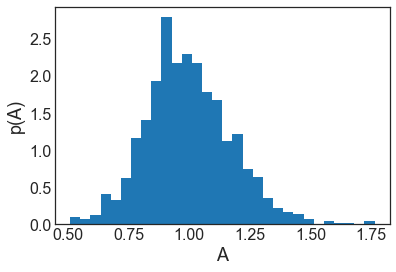

In [37]:
_=plt.hist(mcmc_results.T[0],bins=30,density=True)
plt.xlabel("A")
plt.ylabel("p(A)")
print(mcmc_results.T[0].mean())
print(mcmc_results.T[0].std())

0.9974226662272885
0.17600815904307665


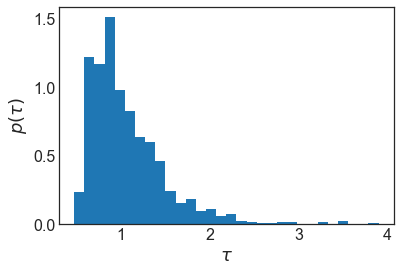

In [38]:
_=plt.hist(mcmc_results.T[1],bins=30,density=True)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
print(mcmc_results.T[0].mean())
print(mcmc_results.T[0].std())

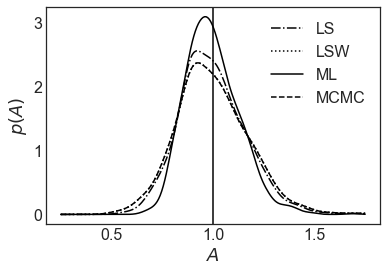

In [39]:
# amplitude KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0.25,1.75,200)
densityLS = gaussian_kde(result_array.T[2])
densityLSW = gaussian_kde(result_array.T[8])
densityML = gaussian_kde(result_Bayes_array.T[0])
densityMCMC = gaussian_kde(mcmc_results.T[0])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.plot(xs,densityMCMC(xs),"k--",label="MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
plt.savefig("A_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

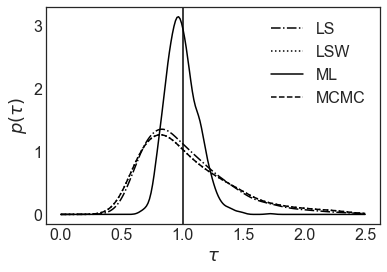

In [40]:
# decay time KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0,2.5,200)
densityLS = gaussian_kde(result_array.T[0])
densityLSW = gaussian_kde(result_array.T[6])
densityML = gaussian_kde(result_Bayes_array.T[2])
densityMCMC = gaussian_kde(mcmc_results.T[1])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.plot(xs,densityMCMC(xs),"k--",label="MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.savefig("tau_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(1000, 12)
(1000, 4)
(0.7694777542272538, 1.528226690495239e-196)


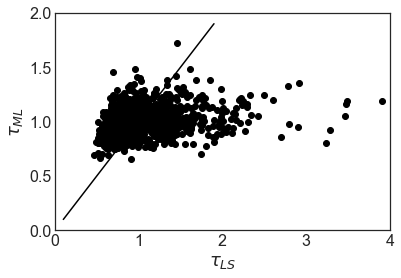

In [47]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(mcmc_results.T[1],result_Bayes_array.T[2],color="k")
plt.plot([0.1,1.9],[0.1,1.9],"k")
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(mcmc_results.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corrMCMC300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.7730869910426363, 1.5990992917433005e-199)


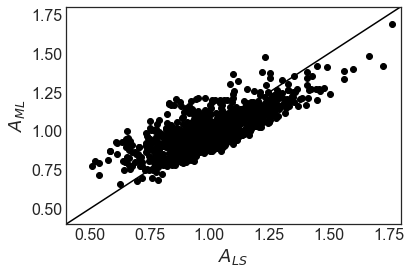

In [48]:
# amplitude correlation
plt.scatter(mcmc_results.T[0],result_Bayes_array.T[0],color="k")
plt.plot([0,1.8],[0,1.8],"k")
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(mcmc_results.T[0],result_Bayes_array.T[0]))
plt.savefig("A_corrMCMC300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [45]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())
print("Amplitude MCMC mean (real):",mcmc_results.T[0].mean())
print("Amplitude MCMC std (real):",mcmc_results.T[0].std())
print("Amplitude MCMC std (fit):",mcmc_results.T[2].mean())

Amplitude LS mean (real): 0.9984105682703185
Amplitude LS std (real): 0.16181660243234747
Amplitude LS stderr (real): 0.0016181660243234748
Amplitude LS std (fit): 0.01145025908410378
Amplitude LS std (fit corrected): 0.0113979437567719
Amplitude LSW mean (real): 4.692624086158618
Amplitude LSW std (real): 8.3673321023892
Amplitude LSW stderr (real): 0.08367332102389201
Amplitude LSW std (fit): 0.9950832668790089
Amplitude LSW std (fit corrected): 0.0113979437567719
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702
Amplitude MCMC mean (real): 0.9974226662272885
Amplitude MCMC std (real): 0.17600815904307665
Amplitude MCMC std (fit): 0.025037702155675804


In [46]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())
print("Decay time MCMC mean (real):",mcmc_results.T[1].mean())
print("Decay time MCMC std (real):",mcmc_results.T[1].std())
print("Decay time MCMC std (fit):",mcmc_results.T[2].mean())

Decay time LS mean (real): 1.0511330280624347
Decay time LS std (real): 0.3905818920277206
Decay time LS stderr (real): 0.0039058189202772057
Decay time (mean-true)/stderr: 13.091499914902776
Decay time LS std (fit): 0.016478751794738906
Decay time LS std (fit corrected): 0.01657870257363243
Decay time LSW mean (real): 1.953151405981036
Decay time LSW std (real): 2.062856350876919
Decay time LSW stderr (real): 0.020628563508769193
Decay time (mean-true)/stderr: 46.20541830631357
Decay time LSW std (fit): 0.10150797451666932
Decay time LSW std (fit corrected): 0.01657870257363243
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101
Decay time MCMC mean (real): 1.0678648772550798
Decay time MCMC std (real): 0.43877768113209276
Decay time MCMC std (fit): 0.025037702155675804
